# Explanation

This notebook explores various different RNN architectures to solve the damped sum problem, that is to calculate the exponentially weighted sum of a sequence (where the most recent term has full weight 1).

# Dataset generation

In [1]:
import logging
from sys import stdout
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np

%matplotlib inline

def writeLog(message, logObject):
    timestamp = datetime.now()
    logObject.info("[{0}]: {1}".format(str(timestamp), message))
    return

logger = logging.getLogger()
logging.basicConfig(level=logging.INFO, stream=stdout)
logger.addHandler(logging.FileHandler("logJupyterRNNDS.txt"))
writeLog("Running jupyter RNN experiment damped sum", logger)

def generateDatapoint(length, dampingFactor):
    x = np.random.randn(length)
    dampers = np.flip(np.power(dampingFactor, np.arange(length)))
    y = np.sum(x * dampers)
    return torch.tensor(x, dtype=torch.float), torch.tensor([y], dtype=torch.float)

class Data2D(Dataset):
    def __init__(self, length, size, dampingFactor):
        self.x = torch.zeros(size, length)
        self.y = torch.zeros(size, dtype=torch.float)
        for i in range(size):
            x, y = generateDatapoint(length, dampingFactor)
            self.x[i,:] = x
            self.y[i] = y
        self.len = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

INFO:root:[2020-05-14 16:06:34.541290]: Running jupyter RNN experiment damped sum


In [5]:
generateDatapoint(5, 0.5)

(tensor([-1.0781,  0.7477, -1.8564, -0.2856,  1.3592]), tensor([0.7783]))

In [6]:
1.3592 - 0.2856/2 - 1.8564/4 + 0.7477/8 - 1.0781/16

0.77838125

# Model classes and loss definition

In [2]:
class RNNElman(nn.Module):
    def __init__(self, hiddenSize, weight_std=1.0):
        super().__init__()
        self.name = 'Elman'
        self.hiddenSize = hiddenSize
        self.previousHiddenPlusInputToHidden = nn.Linear(self.hiddenSize + 1, self.hiddenSize)
        self.hiddenToOutput = nn.Linear(self.hiddenSize, 1)
        self.trainLosses = []
        self.validLosses = []
        self.initialiseWeights(weight_std)
    
    def initialiseWeights(self, weight_std):
        torch.nn.init.normal_(self.previousHiddenPlusInputToHidden.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.previousHiddenPlusInputToHidden.bias.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.hiddenToOutput.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.hiddenToOutput.bias.data, mean=0.0, std=weight_std)
        
    def __str__(self):
        return 'model of type {0} with {1} hidden units'.format(self.name, self.hiddenSize)
        
    def forward(self, x):
        batchSize = x.shape[0]
        sequenceLength = x.shape[1]
        hiddenState = torch.zeros(batchSize, self.hiddenSize)
        for i in range(sequenceLength):
            inputs = x[:,i].unsqueeze(1)
            concatenation = torch.clamp(torch.cat((hiddenState, inputs), dim=1), min=-5, max=5)
            hiddenState = torch.tanh(self.previousHiddenPlusInputToHidden(concatenation))
        outputState = self.hiddenToOutput(hiddenState)
        return outputState


class GRU(nn.Module):
    def __init__(self, hiddenSize, weight_std=1.0):
        super().__init__()
        self.name = 'GRU'
        self.hiddenSize = hiddenSize
        self.relevancyMap = nn.Linear(self.hiddenSize + 1, self.hiddenSize)
        self.candidateMap = nn.Linear(self.hiddenSize + 1, self.hiddenSize)
        self.updateMap = nn.Linear(self.hiddenSize + 1, self.hiddenSize)
        self.hiddenToOutput = nn.Linear(self.hiddenSize, 1)
        self.trainLosses = []
        self.validLosses = []
        self.initialiseWeights(weight_std)
    
    def initialiseWeights(self, weight_std):
        torch.nn.init.normal_(self.relevancyMap.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.relevancyMap.bias.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.candidateMap.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.candidateMap.bias.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.updateMap.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.updateMap.bias.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.hiddenToOutput.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.hiddenToOutput.bias.data, mean=0.0, std=weight_std)
                
    def __str__(self):
        return 'model of type {0} with {1} hidden units'.format(self.name, self.hiddenSize)
    
    def forward(self, x):
        batchSize = x.shape[0]
        sequenceLength = x.shape[1]
        hiddenState = torch.zeros(batchSize, self.hiddenSize)
        relevancyGate = torch.zeros(batchSize, self.hiddenSize)
        for i in range(sequenceLength):
            inputs = x[:,i].unsqueeze(1)
            relevancyConcat = torch.cat((relevancyGate*hiddenState, inputs), dim=1)
            updateConcat = torch.cat((hiddenState, inputs), dim=1)
            candidate = torch.tanh(torch.clamp(self.candidateMap(relevancyConcat), min=-5, max=5))
            updateGate = torch.sigmoid(torch.clamp(self.updateMap(updateConcat), min=-5, max=5))
            relevancyGate = torch.sigmoid(torch.clamp(self.relevancyMap(updateConcat), min=-5, max=5))
            hiddenState = updateGate*candidate + (1-updateGate)*hiddenState
        outputState = self.hiddenToOutput(hiddenState)
        return outputState


class LSTM(nn.Module):
    def __init__(self, hiddenSize, weight_std=1.0):
        super().__init__()
        self.name = 'LSTM'
        self.hiddenSize = hiddenSize
        self.candidateMap = nn.Linear(self.hiddenSize + 1, self.hiddenSize)
        self.updateMap = nn.Linear(self.hiddenSize + 1, self.hiddenSize)
        self.forgetMap = nn.Linear(self.hiddenSize + 1, self.hiddenSize)
        self.outputMap = nn.Linear(self.hiddenSize + 1, self.hiddenSize)
        self.hiddenToOutput = nn.Linear(self.hiddenSize, 1)
        self.trainLosses = []
        self.validLosses = []
        self.initialiseWeights(weight_std)
    
    def initialiseWeights(self, weight_std):
        torch.nn.init.normal_(self.candidateMap.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.candidateMap.bias.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.updateMap.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.updateMap.bias.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.forgetMap.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.forgetMap.bias.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.outputMap.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.outputMap.bias.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.hiddenToOutput.weight.data, mean=0.0, std=weight_std)
        torch.nn.init.normal_(self.hiddenToOutput.bias.data, mean=0.0, std=weight_std)
                
    def __str__(self):
        return 'model of type {0} with {1} hidden units'.format(self.name, self.hiddenSize)
        
    def forward(self, x):
        batchSize = x.shape[0]
        sequenceLength = x.shape[1]
        hiddenState = torch.zeros(batchSize, self.hiddenSize)
        cellState = torch.zeros(batchSize, self.hiddenSize)
        for i in range(sequenceLength):
            inputs = x[:,i].unsqueeze(1)
            updateConcat = torch.cat((hiddenState, inputs), dim=1)
            candidate = torch.tanh(torch.clamp(self.candidateMap(updateConcat), min=-5, max=5))
            updateGate = torch.sigmoid(torch.clamp(self.updateMap(updateConcat), min=-5, max=5))
            forgetGate = torch.sigmoid(torch.clamp(self.forgetMap(updateConcat), min=-5, max=5))
            outputGate = torch.sigmoid(torch.clamp(self.outputMap(updateConcat), min=-5, max=5))
            cellState = updateGate*candidate + forgetGate*cellState
            hiddenState = outputGate * torch.tanh(torch.clamp(cellState, min=-5, max=5))
        outputState = self.hiddenToOutput(hiddenState)
        return outputState
    
    

lossFunction = nn.MSELoss()

# Training and evaluation functions

I'll use the pretraining/warm start idea to first train for a little bit on shorter sequences, then gradually increase the sequence length and the number of epochs I train over, going up to sequences of length 20. Later, I'll evaluate on sequences much longer than the model has seen, though because of the exponential damping, most of the early terms won't matter too much to the answer.

In [8]:
def train(model, sequenceLength, epochs, dampingFactor):
    trainDataset = Data2D(sequenceLength, 1000 * sequenceLength, dampingFactor)
    trainLoader = DataLoader(trainDataset, batch_size=1024)
    validDataset = Data2D(sequenceLength, 500 * sequenceLength, dampingFactor)
    validLoader = DataLoader(validDataset, batch_size=1024)
    optimizer = Adam(model.parameters(), lr=0.1)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    optimizer.zero_grad()
    trainLosses = []
    validLosses = []
    writeLog('Training {0} with sequence length {1}'.format(model, sequenceLength), logger)
    for epoch in range(epochs):
        now = datetime.now()
        writeLog('Epoch: {0}'.format(epoch), logger)
        writeLog('Training on {0} batches and validating on {1} batches'.format(len(trainLoader), len(validLoader)), logger)

        model.train()
        totalLoss = 0
        for xb, yb in trainLoader:
            outputs = model(xb)
            loss = lossFunction(outputs, yb.unsqueeze(1))
            loss.backward()
            totalLoss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
        trainLoss = totalLoss / len(trainLoader)
        writeLog('Training loss: {0}'.format(trainLoss), logger)
        trainLosses.append(trainLoss)
        model.trainLosses.append(trainLoss)

        model.eval()
        with torch.no_grad():
            validLoss = 0
            for xb, yb in validLoader:
                outputs = model(xb)
                validLoss += lossFunction(outputs, yb.unsqueeze(1))
        validLoss = validLoss / len(validLoader)
        validLosses.append(validLoss)
        model.validLosses.append(validLoss)
        writeLog('Validation loss: {0}'.format(validLoss), logger)

        seconds = (datetime.now() - now).total_seconds()
        writeLog('Epoch took: {0} seconds'.format(seconds), logger)
        scheduler.step(validLoss)
        
    _, ax = plt.subplots()
    ax.plot(range(epochs), trainLosses, label='Training')
    ax.plot(range(epochs), validLosses, label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Learning curve for {0} with sequence length {1}'.format(model, sequenceLength))
    ax.legend()
    plt.show()
    
def trainSchedule(model, dampingFactor):
    writeLog('Training {0} with a damping factor of {1}'.format(model, dampingFactor), logger)
    sequenceLengths = [2,5,10,20]
    epochLengths = [10,10,25,50]
    for sequenceLength, epochs in zip(sequenceLengths,epochLengths):
        train(model, sequenceLength, epochs, dampingFactor)
    
def evaluateOnUnseenData(model, sequenceLength, dampingFactor, numExamples=5000):
    unseenDataset=Data2D(sequenceLength, numExamples, dampingFactor)
    unseenLoader = DataLoader(unseenDataset, batch_size=1024)
    with torch.no_grad():
        loss = 0
        for xb, yb in unseenLoader:
            outputs = model(xb)
            loss += lossFunction(outputs, yb.unsqueeze(1))
    return loss.item()/len(unseenLoader)

def zeroClassifierLoss(sequenceLength, dampingFactor, numExamples=5000):
    unseenDataset=Data2D(sequenceLength, numExamples, dampingFactor)
    unseenLoader = DataLoader(unseenDataset, batch_size=1024)
    with torch.no_grad():
        loss = 0
        for xb, yb in unseenLoader:
            outputs = torch.zeros(yb.shape[0], 1)
            loss += lossFunction(outputs, yb.unsqueeze(1))
    return loss.item()/len(unseenLoader)

# Investigating model types

INFO:root:[2020-05-14 16:27:56.460657]: Training model of type Elman with 2 hidden units
INFO:root:[2020-05-14 16:27:56.461505]: Training model of type Elman with 2 hidden units with a damping factor of 0.5
INFO:root:[2020-05-14 16:27:56.615236]: Training model of type Elman with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:27:56.616197]: Epoch: 0
INFO:root:[2020-05-14 16:27:56.616973]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:27:56.642844]: Training loss: 2.468042492866516
INFO:root:[2020-05-14 16:27:56.655199]: Validation loss: 1.6814168691635132
INFO:root:[2020-05-14 16:27:56.656385]: Epoch took: 0.040179 seconds
INFO:root:[2020-05-14 16:27:56.657717]: Epoch: 1
INFO:root:[2020-05-14 16:27:56.658274]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:27:56.683445]: Training loss: 1.6285746097564697
INFO:root:[2020-05-14 16:27:56.695187]: Validation loss: 1.134247064590454
INFO:root:[2020-05-14 16:27:56.69597

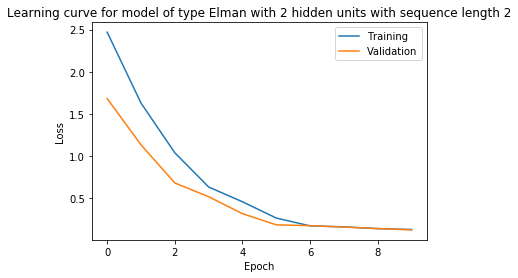

INFO:root:[2020-05-14 16:27:57.505958]: Training model of type Elman with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:27:57.506827]: Epoch: 0
INFO:root:[2020-05-14 16:27:57.507813]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:27:57.553863]: Training loss: 0.6786850571632386
INFO:root:[2020-05-14 16:27:57.577784]: Validation loss: 0.2889077663421631
INFO:root:[2020-05-14 16:27:57.578561]: Epoch took: 0.071731 seconds
INFO:root:[2020-05-14 16:27:57.579118]: Epoch: 1
INFO:root:[2020-05-14 16:27:57.579697]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:27:57.630207]: Training loss: 0.2753358095884323
INFO:root:[2020-05-14 16:27:57.653318]: Validation loss: 0.22943252325057983
INFO:root:[2020-05-14 16:27:57.654107]: Epoch took: 0.074985 seconds
INFO:root:[2020-05-14 16:27:57.654752]: Epoch: 2
INFO:root:[2020-05-14 16:27:57.655416]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:27:57.7

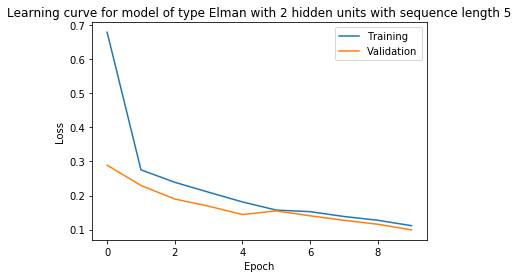

INFO:root:[2020-05-14 16:27:59.226957]: Training model of type Elman with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:27:59.227534]: Epoch: 0
INFO:root:[2020-05-14 16:27:59.228449]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:27:59.322559]: Training loss: 0.08422254323959351
INFO:root:[2020-05-14 16:27:59.361570]: Validation loss: 0.05286785960197449
INFO:root:[2020-05-14 16:27:59.362401]: Epoch took: 0.134861 seconds
INFO:root:[2020-05-14 16:27:59.363035]: Epoch: 1
INFO:root:[2020-05-14 16:27:59.363481]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:27:59.451532]: Training loss: 0.033689637761563064
INFO:root:[2020-05-14 16:27:59.490471]: Validation loss: 0.026959097012877464
INFO:root:[2020-05-14 16:27:59.491392]: Epoch took: 0.12835 seconds
INFO:root:[2020-05-14 16:27:59.492126]: Epoch: 2
INFO:root:[2020-05-14 16:27:59.492598]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16

INFO:root:[2020-05-14 16:28:02.484520]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:02.572800]: Training loss: 0.002419100550469011
INFO:root:[2020-05-14 16:28:02.610113]: Validation loss: 0.002941110637038946
INFO:root:[2020-05-14 16:28:02.610619]: Epoch took: 0.126535 seconds
INFO:root:[2020-05-14 16:28:02.611346]: Epoch: 23
INFO:root:[2020-05-14 16:28:02.611759]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:02.699774]: Training loss: 0.002395899873226881
INFO:root:[2020-05-14 16:28:02.738879]: Validation loss: 0.0029127171728760004
INFO:root:[2020-05-14 16:28:02.739652]: Epoch took: 0.128303 seconds
INFO:root:[2020-05-14 16:28:02.740288]: Epoch: 24
INFO:root:[2020-05-14 16:28:02.740749]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:02.837858]: Training loss: 0.00237135230563581
INFO:root:[2020-05-14 16:28:02.878781]: Validation loss: 0.0028836296405643225
INFO:root:[2020-05-14 16:2

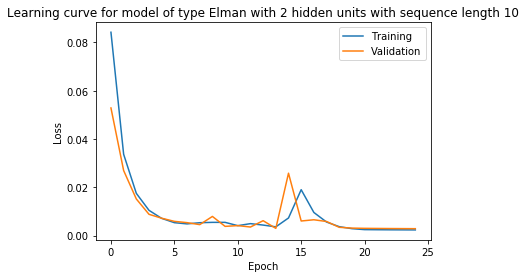

INFO:root:[2020-05-14 16:28:04.502560]: Training model of type Elman with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:28:04.503129]: Epoch: 0
INFO:root:[2020-05-14 16:28:04.504137]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:04.718372]: Training loss: 0.20822404869832098
INFO:root:[2020-05-14 16:28:04.799536]: Validation loss: 0.06551356613636017
INFO:root:[2020-05-14 16:28:04.800355]: Epoch took: 0.297221 seconds
INFO:root:[2020-05-14 16:28:04.801037]: Epoch: 1
INFO:root:[2020-05-14 16:28:04.801693]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:05.008013]: Training loss: 0.03181320116855204
INFO:root:[2020-05-14 16:28:05.141764]: Validation loss: 0.023580027744174004
INFO:root:[2020-05-14 16:28:05.142408]: Epoch took: 0.341365 seconds
INFO:root:[2020-05-14 16:28:05.143231]: Epoch: 2
INFO:root:[2020-05-14 16:28:05.143693]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14

INFO:root:[2020-05-14 16:28:11.884530]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:12.112648]: Training loss: 0.0014556616253685207
INFO:root:[2020-05-14 16:28:12.254825]: Validation loss: 0.0021468899212777615
INFO:root:[2020-05-14 16:28:12.255412]: Epoch took: 0.371415 seconds
INFO:root:[2020-05-14 16:28:12.256220]: Epoch: 23
INFO:root:[2020-05-14 16:28:12.257106]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:12.502333]: Training loss: 0.0018453284807037561
INFO:root:[2020-05-14 16:28:12.585618]: Validation loss: 0.003172981319949031
INFO:root:[2020-05-14 16:28:12.586327]: Epoch took: 0.330104 seconds
INFO:root:[2020-05-14 16:28:12.586940]: Epoch: 24
INFO:root:[2020-05-14 16:28:12.587453]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:12.827827]: Training loss: 0.004804637725464999
INFO:root:[2020-05-14 16:28:12.966037]: Validation loss: 0.0030819436069577932
INFO:root:[2020-05-1

INFO:root:[2020-05-14 16:28:19.535482]: Training loss: 0.0009635994530981407
INFO:root:[2020-05-14 16:28:19.622530]: Validation loss: 0.0008779771742410958
INFO:root:[2020-05-14 16:28:19.623063]: Epoch took: 0.312929 seconds
INFO:root:[2020-05-14 16:28:19.623854]: Epoch: 45
INFO:root:[2020-05-14 16:28:19.624370]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:19.848404]: Training loss: 0.0009571606089593843
INFO:root:[2020-05-14 16:28:19.986262]: Validation loss: 0.0008719221805222332
INFO:root:[2020-05-14 16:28:19.987028]: Epoch took: 0.363169 seconds
INFO:root:[2020-05-14 16:28:19.987800]: Epoch: 46
INFO:root:[2020-05-14 16:28:19.988300]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:20.225996]: Training loss: 0.0009507722279522568
INFO:root:[2020-05-14 16:28:20.313892]: Validation loss: 0.0008658735314384103
INFO:root:[2020-05-14 16:28:20.314424]: Epoch took: 0.326621 seconds
INFO:root:[2020-05-14 16:28:20.314857]: E

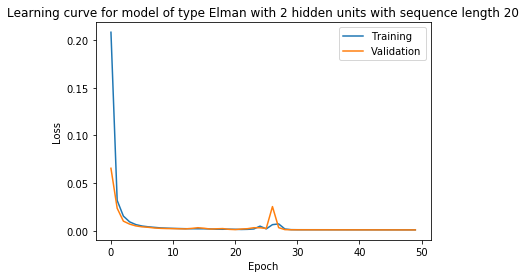

INFO:root:[2020-05-14 16:28:21.441941]: Training model of type GRU with 2 hidden units
INFO:root:[2020-05-14 16:28:21.442571]: Training model of type GRU with 2 hidden units with a damping factor of 0.5
INFO:root:[2020-05-14 16:28:21.585132]: Training model of type GRU with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:28:21.585978]: Epoch: 0
INFO:root:[2020-05-14 16:28:21.586501]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:28:21.607620]: Training loss: 1.6841649413108826
INFO:root:[2020-05-14 16:28:21.618139]: Validation loss: 1.246455430984497
INFO:root:[2020-05-14 16:28:21.618767]: Epoch took: 0.032784 seconds
INFO:root:[2020-05-14 16:28:21.619518]: Epoch: 1
INFO:root:[2020-05-14 16:28:21.620058]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:28:21.639873]: Training loss: 1.0269635021686554
INFO:root:[2020-05-14 16:28:21.649679]: Validation loss: 0.7221594452857971
INFO:root:[2020-05-14 16:28:21.650383]: E

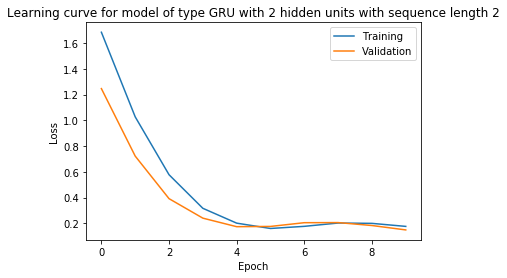

INFO:root:[2020-05-14 16:28:22.434358]: Training model of type GRU with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:28:22.434937]: Epoch: 0
INFO:root:[2020-05-14 16:28:22.435690]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:28:22.490887]: Training loss: 0.2341499775648117
INFO:root:[2020-05-14 16:28:22.513571]: Validation loss: 0.15264292061328888
INFO:root:[2020-05-14 16:28:22.514220]: Epoch took: 0.079278 seconds
INFO:root:[2020-05-14 16:28:22.514925]: Epoch: 1
INFO:root:[2020-05-14 16:28:22.515487]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:28:22.570835]: Training loss: 0.13576247543096542
INFO:root:[2020-05-14 16:28:22.592742]: Validation loss: 0.10888093709945679
INFO:root:[2020-05-14 16:28:22.593389]: Epoch took: 0.078459 seconds
INFO:root:[2020-05-14 16:28:22.594118]: Epoch: 2
INFO:root:[2020-05-14 16:28:22.594756]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:28:22.6

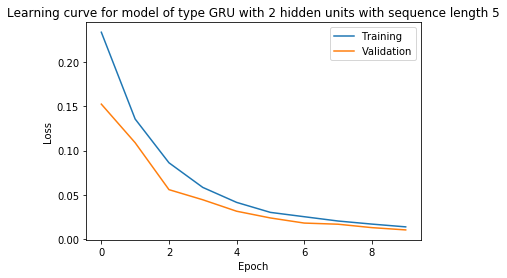

INFO:root:[2020-05-14 16:28:24.103996]: Training model of type GRU with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:28:24.104895]: Epoch: 0
INFO:root:[2020-05-14 16:28:24.105653]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:24.240514]: Training loss: 0.1710815981030464
INFO:root:[2020-05-14 16:28:24.286039]: Validation loss: 0.1554044932126999
INFO:root:[2020-05-14 16:28:24.286886]: Epoch took: 0.181985 seconds
INFO:root:[2020-05-14 16:28:24.287553]: Epoch: 1
INFO:root:[2020-05-14 16:28:24.288063]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:24.420440]: Training loss: 0.07157820798456668
INFO:root:[2020-05-14 16:28:24.519382]: Validation loss: 0.030343640595674515
INFO:root:[2020-05-14 16:28:24.519958]: Epoch took: 0.232403 seconds
INFO:root:[2020-05-14 16:28:24.520717]: Epoch: 2
INFO:root:[2020-05-14 16:28:24.521188]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:

INFO:root:[2020-05-14 16:28:28.519227]: Training loss: 0.0021887787734158337
INFO:root:[2020-05-14 16:28:28.564363]: Validation loss: 0.002676767995581031
INFO:root:[2020-05-14 16:28:28.564893]: Epoch took: 0.175958 seconds
INFO:root:[2020-05-14 16:28:28.565638]: Epoch: 23
INFO:root:[2020-05-14 16:28:28.566263]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:28.696122]: Training loss: 0.0022023470140993596
INFO:root:[2020-05-14 16:28:28.741670]: Validation loss: 0.002443233970552683
INFO:root:[2020-05-14 16:28:28.742243]: Epoch took: 0.176601 seconds
INFO:root:[2020-05-14 16:28:28.743044]: Epoch: 24
INFO:root:[2020-05-14 16:28:28.743762]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:28.876698]: Training loss: 0.001991708728019148
INFO:root:[2020-05-14 16:28:28.961098]: Validation loss: 0.0017409423599019647
INFO:root:[2020-05-14 16:28:28.961631]: Epoch took: 0.218584 seconds


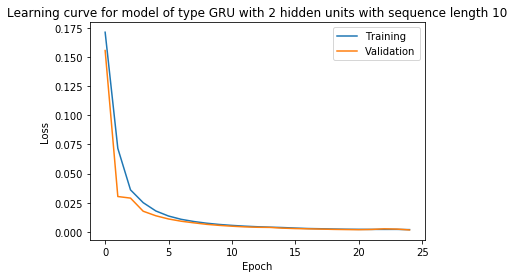

INFO:root:[2020-05-14 16:28:30.542395]: Training model of type GRU with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:28:30.543355]: Epoch: 0
INFO:root:[2020-05-14 16:28:30.544207]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:30.937696]: Training loss: 0.2125714002060704
INFO:root:[2020-05-14 16:28:31.054573]: Validation loss: 0.06319823861122131
INFO:root:[2020-05-14 16:28:31.055394]: Epoch took: 0.51205 seconds
INFO:root:[2020-05-14 16:28:31.056015]: Epoch: 1
INFO:root:[2020-05-14 16:28:31.056625]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:31.497196]: Training loss: 0.03360777162015438
INFO:root:[2020-05-14 16:28:31.613785]: Validation loss: 0.020999489352107048
INFO:root:[2020-05-14 16:28:31.614599]: Epoch took: 0.558579 seconds
INFO:root:[2020-05-14 16:28:31.615164]: Epoch: 2
INFO:root:[2020-05-14 16:28:31.615769]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:

INFO:root:[2020-05-14 16:28:42.054315]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:42.449997]: Training loss: 0.0005260746751446277
INFO:root:[2020-05-14 16:28:42.610947]: Validation loss: 0.0005880772368982434
INFO:root:[2020-05-14 16:28:42.611685]: Epoch took: 0.557894 seconds
INFO:root:[2020-05-14 16:28:42.612562]: Epoch: 23
INFO:root:[2020-05-14 16:28:42.613139]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:43.006518]: Training loss: 0.0004913479016977363
INFO:root:[2020-05-14 16:28:43.116681]: Validation loss: 0.0005356414476409554
INFO:root:[2020-05-14 16:28:43.117256]: Epoch took: 0.504692 seconds
INFO:root:[2020-05-14 16:28:43.117993]: Epoch: 24
INFO:root:[2020-05-14 16:28:43.118472]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:43.562020]: Training loss: 0.00046340672561200335
INFO:root:[2020-05-14 16:28:43.679508]: Validation loss: 0.0004996799980290234
INFO:root:[2020-0

INFO:root:[2020-05-14 16:28:54.179527]: Validation loss: 0.0030029206536710262
INFO:root:[2020-05-14 16:28:54.180048]: Epoch took: 0.486414 seconds
INFO:root:[2020-05-14 16:28:54.180750]: Epoch: 45
INFO:root:[2020-05-14 16:28:54.181388]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:54.595735]: Training loss: 0.0013499211316229775
INFO:root:[2020-05-14 16:28:54.710956]: Validation loss: 0.0018986662616953254
INFO:root:[2020-05-14 16:28:54.711536]: Epoch took: 0.530781 seconds
INFO:root:[2020-05-14 16:28:54.712200]: Epoch: 46
INFO:root:[2020-05-14 16:28:54.712787]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:28:55.090762]: Training loss: 0.0007065953686833382
INFO:root:[2020-05-14 16:28:55.201869]: Validation loss: 0.00022171348973643035
INFO:root:[2020-05-14 16:28:55.202388]: Epoch took: 0.490185 seconds
INFO:root:[2020-05-14 16:28:55.203071]: Epoch: 47
INFO:root:[2020-05-14 16:28:55.203514]: Training on 20 batches and 

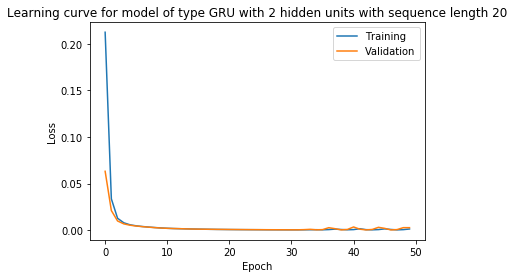

INFO:root:[2020-05-14 16:28:56.837979]: Training model of type LSTM with 2 hidden units
INFO:root:[2020-05-14 16:28:56.838920]: Training model of type LSTM with 2 hidden units with a damping factor of 0.5
INFO:root:[2020-05-14 16:28:56.979998]: Training model of type LSTM with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:28:56.980879]: Epoch: 0
INFO:root:[2020-05-14 16:28:56.981614]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:28:57.004246]: Training loss: 1.113712728023529
INFO:root:[2020-05-14 16:28:57.013160]: Validation loss: 1.0085391998291016
INFO:root:[2020-05-14 16:28:57.013991]: Epoch took: 0.033104 seconds
INFO:root:[2020-05-14 16:28:57.014691]: Epoch: 1
INFO:root:[2020-05-14 16:28:57.015147]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:28:57.035672]: Training loss: 0.9222052991390228
INFO:root:[2020-05-14 16:28:57.044703]: Validation loss: 0.8722071051597595
INFO:root:[2020-05-14 16:28:57.045261]

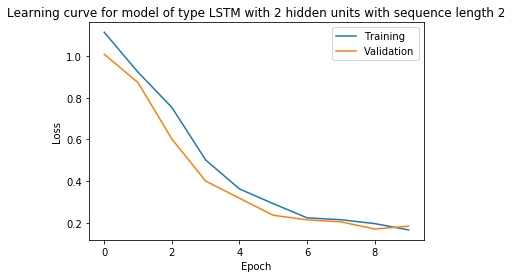

INFO:root:[2020-05-14 16:28:57.823672]: Training model of type LSTM with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:28:57.824286]: Epoch: 0
INFO:root:[2020-05-14 16:28:57.825080]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:28:57.884035]: Training loss: 0.2583006709814072
INFO:root:[2020-05-14 16:28:57.907649]: Validation loss: 0.16914570331573486
INFO:root:[2020-05-14 16:28:57.908219]: Epoch took: 0.083929 seconds
INFO:root:[2020-05-14 16:28:57.909013]: Epoch: 1
INFO:root:[2020-05-14 16:28:57.909601]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:28:57.968485]: Training loss: 0.15046262741088867
INFO:root:[2020-05-14 16:28:57.992269]: Validation loss: 0.11627567559480667
INFO:root:[2020-05-14 16:28:57.993015]: Epoch took: 0.083997 seconds
INFO:root:[2020-05-14 16:28:57.993668]: Epoch: 2
INFO:root:[2020-05-14 16:28:57.994196]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:28:58.

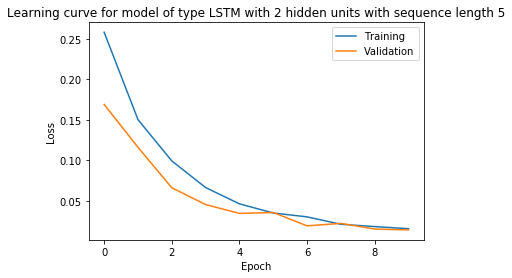

INFO:root:[2020-05-14 16:28:59.529975]: Training model of type LSTM with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:28:59.530892]: Epoch: 0
INFO:root:[2020-05-14 16:28:59.531664]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:59.723074]: Training loss: 0.3310811333358288
INFO:root:[2020-05-14 16:28:59.772666]: Validation loss: 0.15066932141780853
INFO:root:[2020-05-14 16:28:59.773318]: Epoch took: 0.242422 seconds
INFO:root:[2020-05-14 16:28:59.774110]: Epoch: 1
INFO:root:[2020-05-14 16:28:59.774636]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:28:59.917591]: Training loss: 0.14587898552417755
INFO:root:[2020-05-14 16:28:59.965728]: Validation loss: 0.10538370907306671
INFO:root:[2020-05-14 16:28:59.966565]: Epoch took: 0.192448 seconds
INFO:root:[2020-05-14 16:28:59.967256]: Epoch: 2
INFO:root:[2020-05-14 16:28:59.967860]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:29

INFO:root:[2020-05-14 16:29:04.369343]: Training loss: 0.007675412530079484
INFO:root:[2020-05-14 16:29:04.419872]: Validation loss: 0.006289261393249035
INFO:root:[2020-05-14 16:29:04.420664]: Epoch took: 0.204291 seconds
INFO:root:[2020-05-14 16:29:04.421314]: Epoch: 23
INFO:root:[2020-05-14 16:29:04.421820]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:29:04.619830]: Training loss: 0.006841705041006207
INFO:root:[2020-05-14 16:29:04.670316]: Validation loss: 0.00815028790384531
INFO:root:[2020-05-14 16:29:04.671167]: Epoch took: 0.249848 seconds
INFO:root:[2020-05-14 16:29:04.671776]: Epoch: 24
INFO:root:[2020-05-14 16:29:04.672426]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:29:04.828667]: Training loss: 0.009627313213422894
INFO:root:[2020-05-14 16:29:04.880003]: Validation loss: 0.005553653463721275
INFO:root:[2020-05-14 16:29:04.880576]: Epoch took: 0.208798 seconds


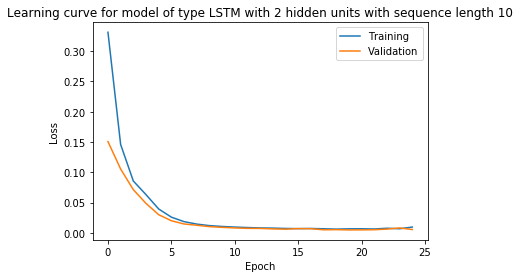

INFO:root:[2020-05-14 16:29:06.529678]: Training model of type LSTM with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:29:06.530650]: Epoch: 0
INFO:root:[2020-05-14 16:29:06.531318]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:07.027751]: Training loss: 0.8878746090224012
INFO:root:[2020-05-14 16:29:07.148619]: Validation loss: 0.2799248695373535
INFO:root:[2020-05-14 16:29:07.149187]: Epoch took: 0.618533 seconds
INFO:root:[2020-05-14 16:29:07.149983]: Epoch: 1
INFO:root:[2020-05-14 16:29:07.150423]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:07.591347]: Training loss: 0.16578881330788137
INFO:root:[2020-05-14 16:29:07.716930]: Validation loss: 0.11141295731067657
INFO:root:[2020-05-14 16:29:07.717814]: Epoch took: 0.567824 seconds
INFO:root:[2020-05-14 16:29:07.718511]: Epoch: 2
INFO:root:[2020-05-14 16:29:07.719094]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:

INFO:root:[2020-05-14 16:29:19.665674]: Training loss: 0.0036211642203852535
INFO:root:[2020-05-14 16:29:19.819416]: Validation loss: 0.003683158429339528
INFO:root:[2020-05-14 16:29:19.819961]: Epoch took: 0.581306 seconds
INFO:root:[2020-05-14 16:29:19.820587]: Epoch: 23
INFO:root:[2020-05-14 16:29:19.821040]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:20.243384]: Training loss: 0.0034145854064263404
INFO:root:[2020-05-14 16:29:20.359864]: Validation loss: 0.0035031531006097794
INFO:root:[2020-05-14 16:29:20.360391]: Epoch took: 0.5398 seconds
INFO:root:[2020-05-14 16:29:20.361108]: Epoch: 24
INFO:root:[2020-05-14 16:29:20.361569]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:20.819532]: Training loss: 0.0032350428751669823
INFO:root:[2020-05-14 16:29:20.932076]: Validation loss: 0.0033414040226489305
INFO:root:[2020-05-14 16:29:20.932615]: Epoch took: 0.571502 seconds
INFO:root:[2020-05-14 16:29:20.933291]: Epoc

INFO:root:[2020-05-14 16:29:32.356832]: Validation loss: 0.0019608382135629654
INFO:root:[2020-05-14 16:29:32.357558]: Epoch took: 0.556267 seconds
INFO:root:[2020-05-14 16:29:32.358088]: Epoch: 45
INFO:root:[2020-05-14 16:29:32.358694]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:32.831585]: Training loss: 0.0018462926556821913
INFO:root:[2020-05-14 16:29:32.953822]: Validation loss: 0.001965451519936323
INFO:root:[2020-05-14 16:29:32.954373]: Epoch took: 0.596283 seconds
INFO:root:[2020-05-14 16:29:32.955057]: Epoch: 46
INFO:root:[2020-05-14 16:29:32.955681]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:33.391736]: Training loss: 0.0018428567505907266
INFO:root:[2020-05-14 16:29:33.508113]: Validation loss: 0.0019565927796065807
INFO:root:[2020-05-14 16:29:33.508809]: Epoch took: 0.553747 seconds
INFO:root:[2020-05-14 16:29:33.509411]: Epoch: 47
INFO:root:[2020-05-14 16:29:33.509941]: Training on 20 batches and va

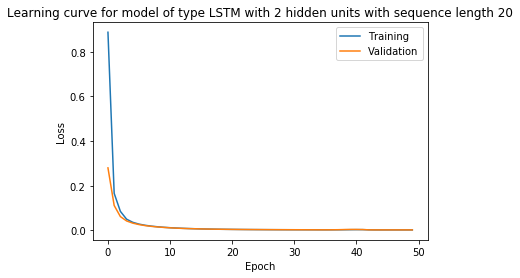

INFO:root:[2020-05-14 16:29:35.363436]: Training model of type Elman with 5 hidden units
INFO:root:[2020-05-14 16:29:35.364412]: Training model of type Elman with 5 hidden units with a damping factor of 0.5
INFO:root:[2020-05-14 16:29:35.517050]: Training model of type Elman with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:29:35.517853]: Epoch: 0
INFO:root:[2020-05-14 16:29:35.518408]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:29:35.536340]: Training loss: 3.927654981613159
INFO:root:[2020-05-14 16:29:35.546814]: Validation loss: 1.782342791557312
INFO:root:[2020-05-14 16:29:35.547403]: Epoch took: 0.029547 seconds
INFO:root:[2020-05-14 16:29:35.548046]: Epoch: 1
INFO:root:[2020-05-14 16:29:35.548631]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:29:35.568049]: Training loss: 1.5721023678779602
INFO:root:[2020-05-14 16:29:35.577405]: Validation loss: 1.1321638822555542
INFO:root:[2020-05-14 16:29:35.57861

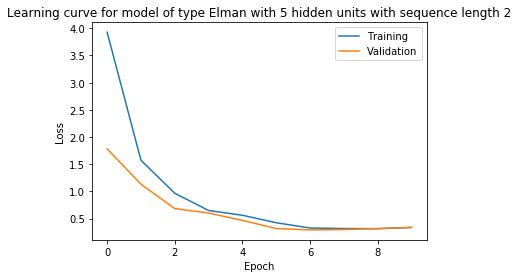

INFO:root:[2020-05-14 16:29:36.350510]: Training model of type Elman with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:29:36.351395]: Epoch: 0
INFO:root:[2020-05-14 16:29:36.351970]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:29:36.397229]: Training loss: 0.5237108588218689
INFO:root:[2020-05-14 16:29:36.418775]: Validation loss: 0.20517279207706451
INFO:root:[2020-05-14 16:29:36.419497]: Epoch took: 0.068096 seconds
INFO:root:[2020-05-14 16:29:36.420172]: Epoch: 1
INFO:root:[2020-05-14 16:29:36.420941]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:29:36.466864]: Training loss: 0.24597229957580566
INFO:root:[2020-05-14 16:29:36.488255]: Validation loss: 0.16195045411586761
INFO:root:[2020-05-14 16:29:36.489020]: Epoch took: 0.068844 seconds
INFO:root:[2020-05-14 16:29:36.489680]: Epoch: 2
INFO:root:[2020-05-14 16:29:36.490143]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:29:36

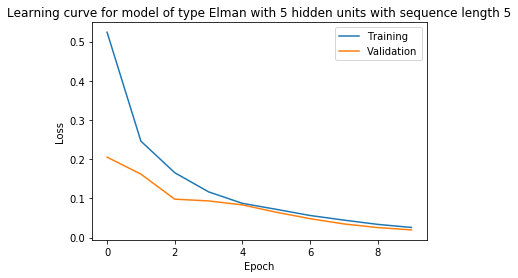

INFO:root:[2020-05-14 16:29:37.969612]: Training model of type Elman with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:29:37.970205]: Epoch: 0
INFO:root:[2020-05-14 16:29:37.970644]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:29:38.120956]: Training loss: 0.3132783368229866
INFO:root:[2020-05-14 16:29:38.163358]: Validation loss: 0.21361127495765686
INFO:root:[2020-05-14 16:29:38.164078]: Epoch took: 0.193867 seconds
INFO:root:[2020-05-14 16:29:38.164704]: Epoch: 1
INFO:root:[2020-05-14 16:29:38.165475]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:29:38.264434]: Training loss: 0.13228986784815788
INFO:root:[2020-05-14 16:29:38.307133]: Validation loss: 0.057221420109272
INFO:root:[2020-05-14 16:29:38.307915]: Epoch took: 0.143205 seconds
INFO:root:[2020-05-14 16:29:38.308690]: Epoch: 2
INFO:root:[2020-05-14 16:29:38.309136]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:29:

INFO:root:[2020-05-14 16:29:41.409094]: Training loss: 0.001730997662525624
INFO:root:[2020-05-14 16:29:41.448964]: Validation loss: 0.001739785773679614
INFO:root:[2020-05-14 16:29:41.449654]: Epoch took: 0.135198 seconds
INFO:root:[2020-05-14 16:29:41.450322]: Epoch: 23
INFO:root:[2020-05-14 16:29:41.450793]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:29:41.587984]: Training loss: 0.0015677391085773707
INFO:root:[2020-05-14 16:29:41.630468]: Validation loss: 0.0015455643879249692
INFO:root:[2020-05-14 16:29:41.630984]: Epoch took: 0.18066 seconds
INFO:root:[2020-05-14 16:29:41.631826]: Epoch: 24
INFO:root:[2020-05-14 16:29:41.632313]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:29:41.732183]: Training loss: 0.0014224015641957522
INFO:root:[2020-05-14 16:29:41.774657]: Validation loss: 0.001407817006111145
INFO:root:[2020-05-14 16:29:41.775381]: Epoch took: 0.143552 seconds


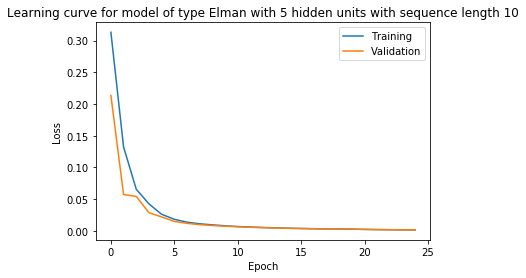

INFO:root:[2020-05-14 16:29:43.411272]: Training model of type Elman with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:29:43.412212]: Epoch: 0
INFO:root:[2020-05-14 16:29:43.412783]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:43.650655]: Training loss: 0.1051006181165576
INFO:root:[2020-05-14 16:29:43.794020]: Validation loss: 0.021974794566631317
INFO:root:[2020-05-14 16:29:43.794846]: Epoch took: 0.38263 seconds
INFO:root:[2020-05-14 16:29:43.795422]: Epoch: 1
INFO:root:[2020-05-14 16:29:43.796092]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:44.051457]: Training loss: 0.015691536478698254
INFO:root:[2020-05-14 16:29:44.143259]: Validation loss: 0.005562240723520517
INFO:root:[2020-05-14 16:29:44.144020]: Epoch took: 0.348593 seconds
INFO:root:[2020-05-14 16:29:44.144607]: Epoch: 2
INFO:root:[2020-05-14 16:29:44.145300]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14

INFO:root:[2020-05-14 16:29:51.208892]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:51.491203]: Training loss: 0.0003553539332642686
INFO:root:[2020-05-14 16:29:51.582425]: Validation loss: 0.00030182537739165127
INFO:root:[2020-05-14 16:29:51.583263]: Epoch took: 0.374968 seconds
INFO:root:[2020-05-14 16:29:51.583956]: Epoch: 23
INFO:root:[2020-05-14 16:29:51.584441]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:51.815007]: Training loss: 0.006708046844869387
INFO:root:[2020-05-14 16:29:51.902245]: Validation loss: 0.0012416500831022859
INFO:root:[2020-05-14 16:29:51.903103]: Epoch took: 0.319141 seconds
INFO:root:[2020-05-14 16:29:51.903709]: Epoch: 24
INFO:root:[2020-05-14 16:29:51.904374]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:52.192634]: Training loss: 0.0016137273021740838
INFO:root:[2020-05-14 16:29:52.280594]: Validation loss: 0.0007597747608087957
INFO:root:[2020-05

INFO:root:[2020-05-14 16:29:59.149304]: Training loss: 0.00019981863952125422
INFO:root:[2020-05-14 16:29:59.239920]: Validation loss: 0.0002121757424902171
INFO:root:[2020-05-14 16:29:59.240680]: Epoch took: 0.323088 seconds
INFO:root:[2020-05-14 16:29:59.241303]: Epoch: 45
INFO:root:[2020-05-14 16:29:59.241897]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:59.510587]: Training loss: 0.00019716380411409772
INFO:root:[2020-05-14 16:29:59.594956]: Validation loss: 0.0002093789807986468
INFO:root:[2020-05-14 16:29:59.595494]: Epoch took: 0.354187 seconds
INFO:root:[2020-05-14 16:29:59.596245]: Epoch: 46
INFO:root:[2020-05-14 16:29:59.596750]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:29:59.824128]: Training loss: 0.00019453534769127146
INFO:root:[2020-05-14 16:29:59.956403]: Validation loss: 0.00020660439622588456
INFO:root:[2020-05-14 16:29:59.957123]: Epoch took: 0.360876 seconds
INFO:root:[2020-05-14 16:29:59.957820

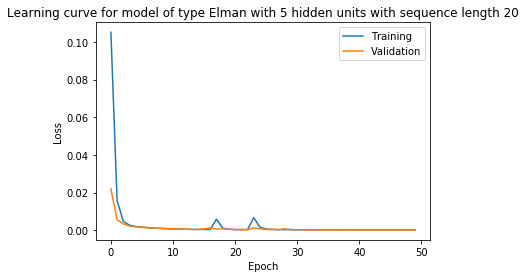

INFO:root:[2020-05-14 16:30:01.072490]: Training model of type GRU with 5 hidden units
INFO:root:[2020-05-14 16:30:01.073463]: Training model of type GRU with 5 hidden units with a damping factor of 0.5
INFO:root:[2020-05-14 16:30:01.232018]: Training model of type GRU with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:30:01.232537]: Epoch: 0
INFO:root:[2020-05-14 16:30:01.233198]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:30:01.252563]: Training loss: 0.9630701839923859
INFO:root:[2020-05-14 16:30:01.262551]: Validation loss: 0.5551741123199463
INFO:root:[2020-05-14 16:30:01.263252]: Epoch took: 0.03071 seconds
INFO:root:[2020-05-14 16:30:01.263845]: Epoch: 1
INFO:root:[2020-05-14 16:30:01.264455]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:30:01.284580]: Training loss: 0.4331490099430084
INFO:root:[2020-05-14 16:30:01.293997]: Validation loss: 0.35208195447921753
INFO:root:[2020-05-14 16:30:01.294851]: 

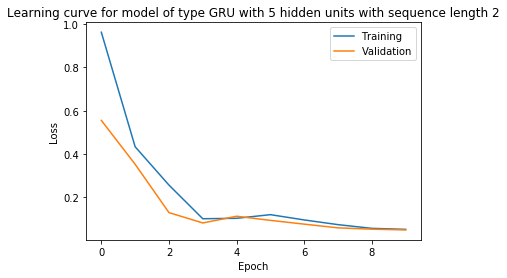

INFO:root:[2020-05-14 16:30:02.107022]: Training model of type GRU with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:30:02.107966]: Epoch: 0
INFO:root:[2020-05-14 16:30:02.108704]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:30:02.165209]: Training loss: 0.17728396356105805
INFO:root:[2020-05-14 16:30:02.189577]: Validation loss: 0.1250373274087906
INFO:root:[2020-05-14 16:30:02.190141]: Epoch took: 0.082171 seconds
INFO:root:[2020-05-14 16:30:02.190932]: Epoch: 1
INFO:root:[2020-05-14 16:30:02.191640]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:30:02.247856]: Training loss: 0.08305248469114304
INFO:root:[2020-05-14 16:30:02.271435]: Validation loss: 0.07562103867530823
INFO:root:[2020-05-14 16:30:02.272146]: Epoch took: 0.081209 seconds
INFO:root:[2020-05-14 16:30:02.272764]: Epoch: 2
INFO:root:[2020-05-14 16:30:02.273499]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:30:02.3

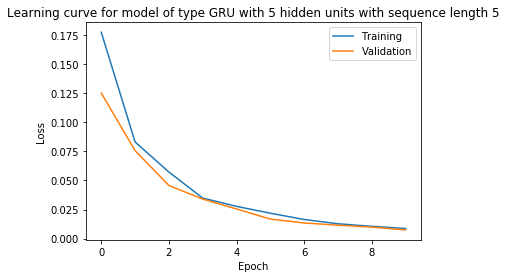

INFO:root:[2020-05-14 16:30:03.870648]: Training model of type GRU with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:30:03.871226]: Epoch: 0
INFO:root:[2020-05-14 16:30:03.871924]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:04.077277]: Training loss: 0.11017510835081339
INFO:root:[2020-05-14 16:30:04.127826]: Validation loss: 0.08569979667663574
INFO:root:[2020-05-14 16:30:04.128403]: Epoch took: 0.257174 seconds
INFO:root:[2020-05-14 16:30:04.129189]: Epoch: 1
INFO:root:[2020-05-14 16:30:04.129640]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:04.280857]: Training loss: 0.041089197248220445
INFO:root:[2020-05-14 16:30:04.332540]: Validation loss: 0.03797372803092003
INFO:root:[2020-05-14 16:30:04.333338]: Epoch took: 0.204143 seconds
INFO:root:[2020-05-14 16:30:04.333976]: Epoch: 2
INFO:root:[2020-05-14 16:30:04.334803]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:3

INFO:root:[2020-05-14 16:30:08.550107]: Training loss: 0.0006314212223514915
INFO:root:[2020-05-14 16:30:08.597580]: Validation loss: 0.0006452379748225212
INFO:root:[2020-05-14 16:30:08.598088]: Epoch took: 0.186318 seconds
INFO:root:[2020-05-14 16:30:08.598726]: Epoch: 23
INFO:root:[2020-05-14 16:30:08.599216]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:08.776916]: Training loss: 0.0005903671204578132
INFO:root:[2020-05-14 16:30:08.823324]: Validation loss: 0.0006202096701599658
INFO:root:[2020-05-14 16:30:08.823874]: Epoch took: 0.225146 seconds
INFO:root:[2020-05-14 16:30:08.824594]: Epoch: 24
INFO:root:[2020-05-14 16:30:08.825392]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:08.963560]: Training loss: 0.0005520288279512898
INFO:root:[2020-05-14 16:30:09.010563]: Validation loss: 0.0006002563750371337
INFO:root:[2020-05-14 16:30:09.011075]: Epoch took: 0.186478 seconds


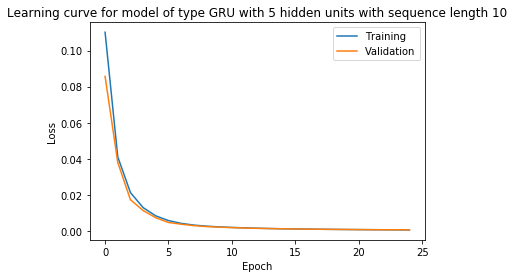

INFO:root:[2020-05-14 16:30:10.504072]: Training model of type GRU with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:30:10.504930]: Epoch: 0
INFO:root:[2020-05-14 16:30:10.505733]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:10.961000]: Training loss: 0.1361039051640546
INFO:root:[2020-05-14 16:30:11.076188]: Validation loss: 0.02312617376446724
INFO:root:[2020-05-14 16:30:11.077051]: Epoch took: 0.572116 seconds
INFO:root:[2020-05-14 16:30:11.077686]: Epoch: 1
INFO:root:[2020-05-14 16:30:11.078184]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:11.481684]: Training loss: 0.021612853975966573
INFO:root:[2020-05-14 16:30:11.596518]: Validation loss: 0.00966115202754736
INFO:root:[2020-05-14 16:30:11.597149]: Epoch took: 0.519459 seconds
INFO:root:[2020-05-14 16:30:11.597833]: Epoch: 2
INFO:root:[2020-05-14 16:30:11.598486]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16

INFO:root:[2020-05-14 16:30:22.998311]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:23.411599]: Training loss: 0.00026287897853762845
INFO:root:[2020-05-14 16:30:23.576151]: Validation loss: 0.0002824266266543418
INFO:root:[2020-05-14 16:30:23.576705]: Epoch took: 0.579118 seconds
INFO:root:[2020-05-14 16:30:23.577497]: Epoch: 23
INFO:root:[2020-05-14 16:30:23.577946]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:23.984546]: Training loss: 0.0002422543395368848
INFO:root:[2020-05-14 16:30:24.099788]: Validation loss: 0.0002598555583972484
INFO:root:[2020-05-14 16:30:24.100322]: Epoch took: 0.522822 seconds
INFO:root:[2020-05-14 16:30:24.101044]: Epoch: 24
INFO:root:[2020-05-14 16:30:24.101777]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:24.547563]: Training loss: 0.00022489526309072972
INFO:root:[2020-05-14 16:30:24.663220]: Validation loss: 0.00024416582891717553
INFO:root:[2020

INFO:root:[2020-05-14 16:30:35.938954]: Validation loss: 8.948781032813713e-05
INFO:root:[2020-05-14 16:30:35.939683]: Epoch took: 0.581421 seconds
INFO:root:[2020-05-14 16:30:35.940227]: Epoch: 45
INFO:root:[2020-05-14 16:30:35.940997]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:36.362471]: Training loss: 7.427377531712409e-05
INFO:root:[2020-05-14 16:30:36.516479]: Validation loss: 8.61853695823811e-05
INFO:root:[2020-05-14 16:30:36.517207]: Epoch took: 0.576976 seconds
INFO:root:[2020-05-14 16:30:36.517757]: Epoch: 46
INFO:root:[2020-05-14 16:30:36.518369]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:36.925779]: Training loss: 6.88191139488481e-05
INFO:root:[2020-05-14 16:30:37.049560]: Validation loss: 8.410979353357106e-05
INFO:root:[2020-05-14 16:30:37.050290]: Epoch took: 0.532528 seconds
INFO:root:[2020-05-14 16:30:37.050847]: Epoch: 47
INFO:root:[2020-05-14 16:30:37.051342]: Training on 20 batches and val

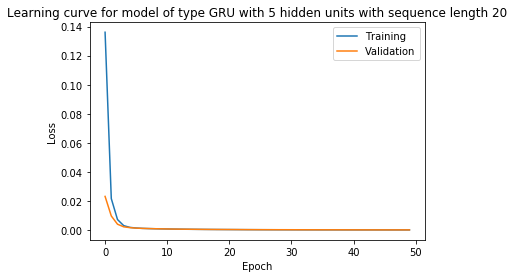

INFO:root:[2020-05-14 16:30:38.803965]: Training model of type LSTM with 5 hidden units
INFO:root:[2020-05-14 16:30:38.805059]: Training model of type LSTM with 5 hidden units with a damping factor of 0.5
INFO:root:[2020-05-14 16:30:38.947156]: Training model of type LSTM with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:30:38.948050]: Epoch: 0
INFO:root:[2020-05-14 16:30:38.948541]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:30:38.972202]: Training loss: 0.9555961787700653
INFO:root:[2020-05-14 16:30:38.982083]: Validation loss: 0.292561411857605
INFO:root:[2020-05-14 16:30:38.982915]: Epoch took: 0.034859 seconds
INFO:root:[2020-05-14 16:30:38.983519]: Epoch: 1
INFO:root:[2020-05-14 16:30:38.984320]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:30:39.005802]: Training loss: 0.3398502618074417
INFO:root:[2020-05-14 16:30:39.015441]: Validation loss: 0.4021838903427124
INFO:root:[2020-05-14 16:30:39.016410]

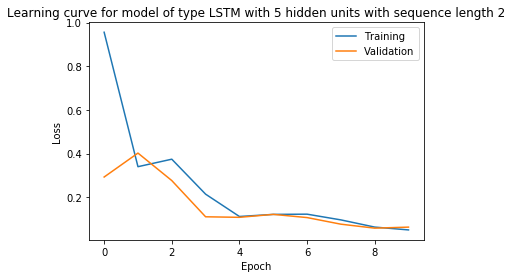

INFO:root:[2020-05-14 16:30:39.841117]: Training model of type LSTM with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:30:39.842176]: Epoch: 0
INFO:root:[2020-05-14 16:30:39.843005]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:30:39.904459]: Training loss: 0.31897965669631956
INFO:root:[2020-05-14 16:30:39.927382]: Validation loss: 0.261466383934021
INFO:root:[2020-05-14 16:30:39.928131]: Epoch took: 0.08595 seconds
INFO:root:[2020-05-14 16:30:39.928750]: Epoch: 1
INFO:root:[2020-05-14 16:30:39.929223]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:30:39.991406]: Training loss: 0.15201133638620376
INFO:root:[2020-05-14 16:30:40.015167]: Validation loss: 0.14922581613063812
INFO:root:[2020-05-14 16:30:40.015917]: Epoch took: 0.08716 seconds
INFO:root:[2020-05-14 16:30:40.016631]: Epoch: 2
INFO:root:[2020-05-14 16:30:40.017099]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:30:40.078

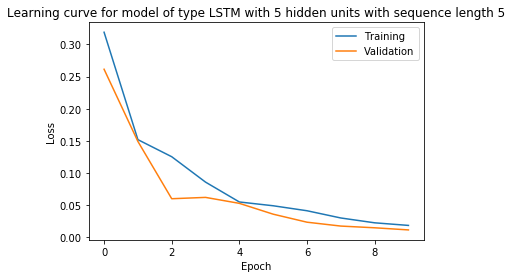

INFO:root:[2020-05-14 16:30:41.670714]: Training model of type LSTM with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:30:41.672223]: Epoch: 0
INFO:root:[2020-05-14 16:30:41.673265]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:41.842935]: Training loss: 0.146370161883533
INFO:root:[2020-05-14 16:30:41.897123]: Validation loss: 0.1349954754114151
INFO:root:[2020-05-14 16:30:41.897888]: Epoch took: 0.225661 seconds
INFO:root:[2020-05-14 16:30:41.898735]: Epoch: 1
INFO:root:[2020-05-14 16:30:41.899317]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:42.057021]: Training loss: 0.0671218141913414
INFO:root:[2020-05-14 16:30:42.150056]: Validation loss: 0.026065751910209656
INFO:root:[2020-05-14 16:30:42.150803]: Epoch took: 0.252065 seconds
INFO:root:[2020-05-14 16:30:42.151426]: Epoch: 2
INFO:root:[2020-05-14 16:30:42.152046]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:4

INFO:root:[2020-05-14 16:30:46.655557]: Training loss: 0.0008587100659497082
INFO:root:[2020-05-14 16:30:46.703812]: Validation loss: 0.0007661777199245989
INFO:root:[2020-05-14 16:30:46.704347]: Epoch took: 0.200641 seconds
INFO:root:[2020-05-14 16:30:46.705056]: Epoch: 23
INFO:root:[2020-05-14 16:30:46.705569]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:46.857684]: Training loss: 0.0008070385083556175
INFO:root:[2020-05-14 16:30:46.906908]: Validation loss: 0.0007120550144463778
INFO:root:[2020-05-14 16:30:46.907533]: Epoch took: 0.202474 seconds
INFO:root:[2020-05-14 16:30:46.908233]: Epoch: 24
INFO:root:[2020-05-14 16:30:46.908731]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:30:47.061057]: Training loss: 0.0007627083105035126
INFO:root:[2020-05-14 16:30:47.150660]: Validation loss: 0.0006774042849428952
INFO:root:[2020-05-14 16:30:47.151382]: Epoch took: 0.243147 seconds


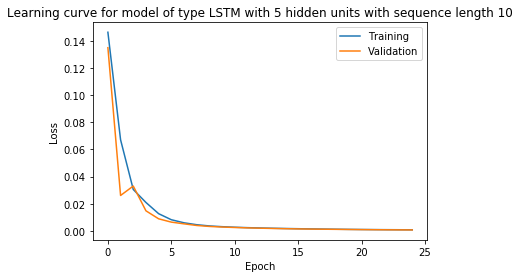

INFO:root:[2020-05-14 16:30:48.660228]: Training model of type LSTM with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:30:48.661203]: Epoch: 0
INFO:root:[2020-05-14 16:30:48.662016]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:49.118240]: Training loss: 0.05983951071975753
INFO:root:[2020-05-14 16:30:49.241875]: Validation loss: 0.02358308993279934
INFO:root:[2020-05-14 16:30:49.242689]: Epoch took: 0.581479 seconds
INFO:root:[2020-05-14 16:30:49.243295]: Epoch: 1
INFO:root:[2020-05-14 16:30:49.243934]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:30:49.747657]: Training loss: 0.008092097810003907
INFO:root:[2020-05-14 16:30:49.870115]: Validation loss: 0.0040954784490168095
INFO:root:[2020-05-14 16:30:49.870693]: Epoch took: 0.627396 seconds
INFO:root:[2020-05-14 16:30:49.871330]: Epoch: 2
INFO:root:[2020-05-14 16:30:49.872104]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-1

INFO:root:[2020-05-14 16:31:01.947458]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:31:02.399986]: Training loss: 0.00013831096002832056
INFO:root:[2020-05-14 16:31:02.520398]: Validation loss: 0.00015398499090224504
INFO:root:[2020-05-14 16:31:02.521182]: Epoch took: 0.57452 seconds
INFO:root:[2020-05-14 16:31:02.521767]: Epoch: 23
INFO:root:[2020-05-14 16:31:02.522392]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:31:02.975303]: Training loss: 0.0001317835402005585
INFO:root:[2020-05-14 16:31:03.145367]: Validation loss: 0.00014991729403845966
INFO:root:[2020-05-14 16:31:03.146159]: Epoch took: 0.624387 seconds
INFO:root:[2020-05-14 16:31:03.146727]: Epoch: 24
INFO:root:[2020-05-14 16:31:03.147396]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:31:03.603132]: Training loss: 0.00012403596228978132
INFO:root:[2020-05-14 16:31:03.725739]: Validation loss: 0.00013727336772717535
INFO:root:[202

INFO:root:[2020-05-14 16:31:16.251407]: Validation loss: 6.457819108618423e-05
INFO:root:[2020-05-14 16:31:16.252086]: Epoch took: 0.647654 seconds
INFO:root:[2020-05-14 16:31:16.252490]: Epoch: 45
INFO:root:[2020-05-14 16:31:16.253279]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:31:16.738055]: Training loss: 5.415989307948621e-05
INFO:root:[2020-05-14 16:31:16.872062]: Validation loss: 6.225517427083105e-05
INFO:root:[2020-05-14 16:31:16.872850]: Epoch took: 0.620357 seconds
INFO:root:[2020-05-14 16:31:16.873426]: Epoch: 46
INFO:root:[2020-05-14 16:31:16.873973]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:31:17.383249]: Training loss: 5.184641486266628e-05
INFO:root:[2020-05-14 16:31:17.516817]: Validation loss: 5.740848064306192e-05
INFO:root:[2020-05-14 16:31:17.517557]: Epoch took: 0.644125 seconds
INFO:root:[2020-05-14 16:31:17.518231]: Epoch: 47
INFO:root:[2020-05-14 16:31:17.518672]: Training on 20 batches and v

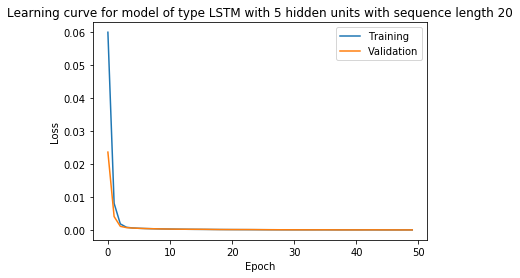

In [9]:
modelTypes = [RNNElman(2), GRU(2), LSTM(2), RNNElman(5), GRU(5), LSTM(5)]

for modelType in modelTypes:
    writeLog('Training {0}'.format(modelType), logger)
    trainSchedule(modelType, dampingFactor=0.5)

INFO:root:[2020-05-14 16:32:31.590220]: model of type Elman with 2 hidden units
INFO:root:[2020-05-14 16:32:34.111616]: model of type GRU with 2 hidden units
INFO:root:[2020-05-14 16:32:36.901270]: model of type LSTM with 2 hidden units
INFO:root:[2020-05-14 16:32:39.812556]: model of type Elman with 5 hidden units
INFO:root:[2020-05-14 16:32:42.341672]: model of type GRU with 5 hidden units
INFO:root:[2020-05-14 16:32:45.255845]: model of type LSTM with 5 hidden units


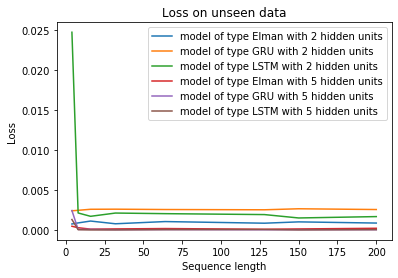

In [13]:
allModelLosses = []
for modelType in modelTypes:
    writeLog(modelType, logger)
    sequenceLengths = [4,8,16,32,64,128,150,200]
    losses = []
    for sequenceLength in sequenceLengths:
        losses.append(evaluateOnUnseenData(modelType, sequenceLength, dampingFactor=0.5))
    allModelLosses.append(losses)
_, ax = plt.subplots()
ax.plot(sequenceLengths, allModelLosses[0], label=str(modelTypes[0]))
ax.plot(sequenceLengths, allModelLosses[1], label=str(modelTypes[1]))
ax.plot(sequenceLengths, allModelLosses[2], label=str(modelTypes[2]))
ax.plot(sequenceLengths, allModelLosses[3], label=str(modelTypes[3]))
ax.plot(sequenceLengths, allModelLosses[4], label=str(modelTypes[4]))
ax.plot(sequenceLengths, allModelLosses[5], label=str(modelTypes[5]))
ax.set_xlabel('Sequence length')
ax.set_ylabel('Loss')
ax.set_title('Loss on unseen data with damping factor 0.5')
ax.legend()
plt.show()

Let's evaluate these on really long sequences.

In [42]:
for modelType in modelTypes:
    writeLog(str(modelType) + ': ' + str(evaluateOnUnseenData(modelType, 1000, dampingFactor=0.5)), logger)

INFO:root:[2020-05-14 18:50:42.436752]: model of type Elman with 2 hidden units: 0.0009096295572817326
INFO:root:[2020-05-14 18:50:44.010979]: model of type GRU with 2 hidden units: 0.0025688769295811654
INFO:root:[2020-05-14 18:50:45.585054]: model of type LSTM with 2 hidden units: 0.0017553906887769698
INFO:root:[2020-05-14 18:50:46.502661]: model of type Elman with 5 hidden units: 0.00014823427191004157
INFO:root:[2020-05-14 18:50:48.104392]: model of type GRU with 5 hidden units: 0.00010293887462466955
INFO:root:[2020-05-14 18:50:50.054661]: model of type LSTM with 5 hidden units: 6.412318325601518e-05


So all models seem to work pretty well for low damping factor. Let's up the damping factor to try and distinguish them.

INFO:root:[2020-05-14 16:35:42.419255]: Training model of type Elman with 2 hidden units
INFO:root:[2020-05-14 16:35:42.420178]: Training model of type Elman with 2 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:35:42.573387]: Training model of type Elman with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:35:42.574355]: Epoch: 0
INFO:root:[2020-05-14 16:35:42.574874]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:35:42.598323]: Training loss: 1.8113277554512024
INFO:root:[2020-05-14 16:35:42.610967]: Validation loss: 1.28640615940094
INFO:root:[2020-05-14 16:35:42.611702]: Epoch took: 0.03734 seconds
INFO:root:[2020-05-14 16:35:42.612380]: Epoch: 1
INFO:root:[2020-05-14 16:35:42.614108]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:35:42.638862]: Training loss: 1.0356413125991821
INFO:root:[2020-05-14 16:35:42.649523]: Validation loss: 0.7396554350852966
INFO:root:[2020-05-14 16:35:42.650774

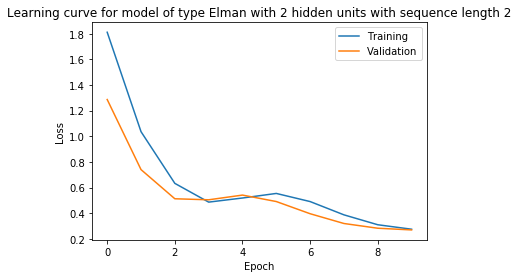

INFO:root:[2020-05-14 16:35:43.544710]: Training model of type Elman with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:35:43.545337]: Epoch: 0
INFO:root:[2020-05-14 16:35:43.546034]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:35:43.592105]: Training loss: 1.203090238571167
INFO:root:[2020-05-14 16:35:43.611850]: Validation loss: 0.9123093485832214
INFO:root:[2020-05-14 16:35:43.612750]: Epoch took: 0.067405 seconds
INFO:root:[2020-05-14 16:35:43.613466]: Epoch: 1
INFO:root:[2020-05-14 16:35:43.614215]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:35:43.668191]: Training loss: 0.8715680241584778
INFO:root:[2020-05-14 16:35:43.692022]: Validation loss: 0.7268762588500977
INFO:root:[2020-05-14 16:35:43.692576]: Epoch took: 0.079105 seconds
INFO:root:[2020-05-14 16:35:43.693303]: Epoch: 2
INFO:root:[2020-05-14 16:35:43.694175]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:35:43.742

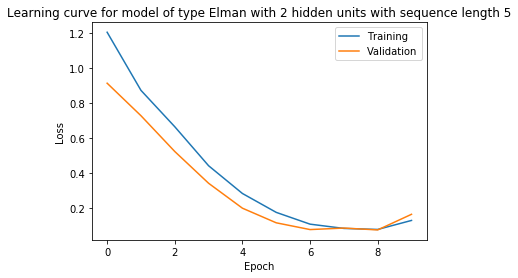

INFO:root:[2020-05-14 16:35:45.225340]: Training model of type Elman with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:35:45.226145]: Epoch: 0
INFO:root:[2020-05-14 16:35:45.226511]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:35:45.372051]: Training loss: 2.8052306294441225
INFO:root:[2020-05-14 16:35:45.413989]: Validation loss: 2.4067118167877197
INFO:root:[2020-05-14 16:35:45.414535]: Epoch took: 0.188385 seconds
INFO:root:[2020-05-14 16:35:45.415240]: Epoch: 1
INFO:root:[2020-05-14 16:35:45.415901]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:35:45.512370]: Training loss: 1.4227050721645356
INFO:root:[2020-05-14 16:35:45.553625]: Validation loss: 0.6050575971603394
INFO:root:[2020-05-14 16:35:45.554365]: Epoch took: 0.139121 seconds
INFO:root:[2020-05-14 16:35:45.554990]: Epoch: 2
INFO:root:[2020-05-14 16:35:45.555502]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:35:4

INFO:root:[2020-05-14 16:35:48.745350]: Training loss: 0.07736302614212036
INFO:root:[2020-05-14 16:35:48.787742]: Validation loss: 0.06536991894245148
INFO:root:[2020-05-14 16:35:48.788453]: Epoch took: 0.141361 seconds
INFO:root:[2020-05-14 16:35:48.789233]: Epoch: 23
INFO:root:[2020-05-14 16:35:48.790005]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:35:48.891645]: Training loss: 0.06930366922169924
INFO:root:[2020-05-14 16:35:48.933386]: Validation loss: 0.10486213117837906
INFO:root:[2020-05-14 16:35:48.933913]: Epoch took: 0.144678 seconds
INFO:root:[2020-05-14 16:35:48.934648]: Epoch: 24
INFO:root:[2020-05-14 16:35:48.935357]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:35:49.070877]: Training loss: 0.06298599503934384
INFO:root:[2020-05-14 16:35:49.110503]: Validation loss: 0.057803213596343994
INFO:root:[2020-05-14 16:35:49.111029]: Epoch took: 0.176375 seconds
Epoch    25: reducing learning rate of group 0 to 1.00

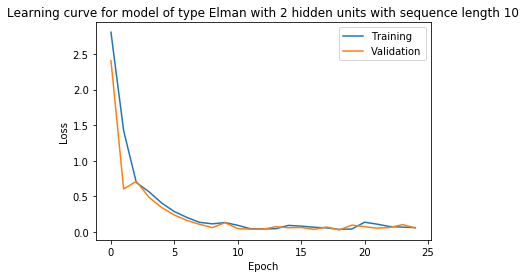

INFO:root:[2020-05-14 16:35:50.672035]: Training model of type Elman with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:35:50.672901]: Epoch: 0
INFO:root:[2020-05-14 16:35:50.673429]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:35:50.904605]: Training loss: 5.0762584827840325
INFO:root:[2020-05-14 16:35:51.004109]: Validation loss: 4.084961891174316
INFO:root:[2020-05-14 16:35:51.005341]: Epoch took: 0.332428 seconds
INFO:root:[2020-05-14 16:35:51.005995]: Epoch: 1
INFO:root:[2020-05-14 16:35:51.006499]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:35:51.270202]: Training loss: 4.000337898731232
INFO:root:[2020-05-14 16:35:51.359577]: Validation loss: 3.9281508922576904
INFO:root:[2020-05-14 16:35:51.360093]: Epoch took: 0.354096 seconds
INFO:root:[2020-05-14 16:35:51.360799]: Epoch: 2
INFO:root:[2020-05-14 16:35:51.361483]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:35:

INFO:root:[2020-05-14 16:35:58.338094]: Training loss: 0.18398693650960923
INFO:root:[2020-05-14 16:35:58.426224]: Validation loss: 0.10294346511363983
INFO:root:[2020-05-14 16:35:58.426802]: Epoch took: 0.348462 seconds
INFO:root:[2020-05-14 16:35:58.427639]: Epoch: 23
INFO:root:[2020-05-14 16:35:58.428093]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:35:58.649070]: Training loss: 0.09739316403865814
INFO:root:[2020-05-14 16:35:58.736977]: Validation loss: 0.07995332777500153
INFO:root:[2020-05-14 16:35:58.737848]: Epoch took: 0.310203 seconds
INFO:root:[2020-05-14 16:35:58.739729]: Epoch: 24
INFO:root:[2020-05-14 16:35:58.740349]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:35:58.954991]: Training loss: 0.06723138280212879
INFO:root:[2020-05-14 16:35:59.079464]: Validation loss: 0.056399665772914886
INFO:root:[2020-05-14 16:35:59.080197]: Epoch took: 0.340468 seconds
Epoch    25: reducing learning rate of group 0 to 1.

INFO:root:[2020-05-14 16:36:05.762303]: Epoch took: 0.382243 seconds
INFO:root:[2020-05-14 16:36:05.763019]: Epoch: 45
INFO:root:[2020-05-14 16:36:05.763650]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:05.994637]: Training loss: 0.03445985009893775
INFO:root:[2020-05-14 16:36:06.081564]: Validation loss: 0.029877271503210068
INFO:root:[2020-05-14 16:36:06.082117]: Epoch took: 0.319094 seconds
INFO:root:[2020-05-14 16:36:06.082734]: Epoch: 46
INFO:root:[2020-05-14 16:36:06.083507]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:06.342737]: Training loss: 0.033761628065258266
INFO:root:[2020-05-14 16:36:06.435260]: Validation loss: 0.02923635207116604
INFO:root:[2020-05-14 16:36:06.436175]: Epoch took: 0.35344 seconds
INFO:root:[2020-05-14 16:36:06.436839]: Epoch: 47
INFO:root:[2020-05-14 16:36:06.437287]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:06.674087]: Training loss: 0.03308

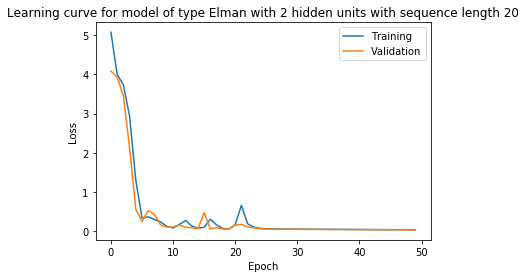

INFO:root:[2020-05-14 16:36:07.563023]: Training model of type GRU with 2 hidden units
INFO:root:[2020-05-14 16:36:07.563998]: Training model of type GRU with 2 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:36:07.721207]: Training model of type GRU with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:36:07.722241]: Epoch: 0
INFO:root:[2020-05-14 16:36:07.722932]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:36:07.743519]: Training loss: 2.1014435291290283
INFO:root:[2020-05-14 16:36:07.752519]: Validation loss: 1.4799253940582275
INFO:root:[2020-05-14 16:36:07.753392]: Epoch took: 0.031147 seconds
INFO:root:[2020-05-14 16:36:07.754078]: Epoch: 1
INFO:root:[2020-05-14 16:36:07.754828]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:36:07.775687]: Training loss: 1.3921725153923035
INFO:root:[2020-05-14 16:36:07.784867]: Validation loss: 1.1050280332565308
INFO:root:[2020-05-14 16:36:07.785730]: 

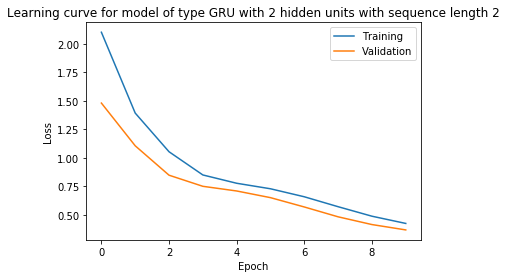

INFO:root:[2020-05-14 16:36:08.580161]: Training model of type GRU with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:36:08.581081]: Epoch: 0
INFO:root:[2020-05-14 16:36:08.581669]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:36:08.639675]: Training loss: 1.342605710029602
INFO:root:[2020-05-14 16:36:08.662945]: Validation loss: 0.8957756161689758
INFO:root:[2020-05-14 16:36:08.663525]: Epoch took: 0.08244 seconds
INFO:root:[2020-05-14 16:36:08.664310]: Epoch: 1
INFO:root:[2020-05-14 16:36:08.665213]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:36:08.726118]: Training loss: 0.6301972329616546
INFO:root:[2020-05-14 16:36:08.750030]: Validation loss: 0.36436721682548523
INFO:root:[2020-05-14 16:36:08.750599]: Epoch took: 0.086286 seconds
INFO:root:[2020-05-14 16:36:08.751252]: Epoch: 2
INFO:root:[2020-05-14 16:36:08.751931]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:36:08.81423

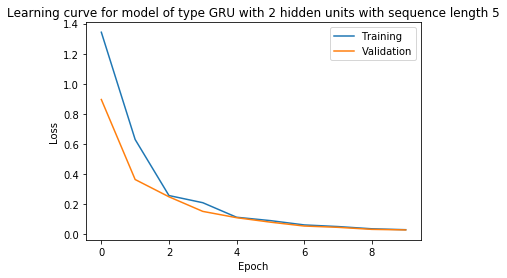

INFO:root:[2020-05-14 16:36:10.288768]: Training model of type GRU with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:36:10.289360]: Epoch: 0
INFO:root:[2020-05-14 16:36:10.290242]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:10.429705]: Training loss: 0.5910538002848625
INFO:root:[2020-05-14 16:36:10.478764]: Validation loss: 0.513715386390686
INFO:root:[2020-05-14 16:36:10.479525]: Epoch took: 0.19016 seconds
INFO:root:[2020-05-14 16:36:10.480177]: Epoch: 1
INFO:root:[2020-05-14 16:36:10.480685]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:10.619808]: Training loss: 0.23699017539620398
INFO:root:[2020-05-14 16:36:10.720473]: Validation loss: 0.21024346351623535
INFO:root:[2020-05-14 16:36:10.721280]: Epoch took: 0.241099 seconds
INFO:root:[2020-05-14 16:36:10.721875]: Epoch: 2
INFO:root:[2020-05-14 16:36:10.722552]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:10.

INFO:root:[2020-05-14 16:36:14.829762]: Training loss: 0.007929617259651422
INFO:root:[2020-05-14 16:36:14.877474]: Validation loss: 0.007551288697868586
INFO:root:[2020-05-14 16:36:14.878302]: Epoch took: 0.184086 seconds
INFO:root:[2020-05-14 16:36:14.878864]: Epoch: 23
INFO:root:[2020-05-14 16:36:14.879642]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:15.013251]: Training loss: 0.007400338491424918
INFO:root:[2020-05-14 16:36:15.060099]: Validation loss: 0.007075109984725714
INFO:root:[2020-05-14 16:36:15.061001]: Epoch took: 0.18213 seconds
INFO:root:[2020-05-14 16:36:15.061628]: Epoch: 24
INFO:root:[2020-05-14 16:36:15.062103]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:15.191890]: Training loss: 0.006907660141587257
INFO:root:[2020-05-14 16:36:15.238917]: Validation loss: 0.006615854799747467
INFO:root:[2020-05-14 16:36:15.239757]: Epoch took: 0.178122 seconds


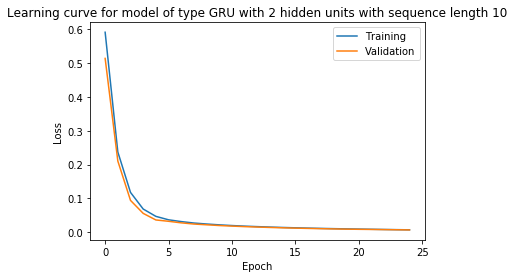

INFO:root:[2020-05-14 16:36:16.916011]: Training model of type GRU with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:36:16.916650]: Epoch: 0
INFO:root:[2020-05-14 16:36:16.917585]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:17.293295]: Training loss: 1.09360523968935
INFO:root:[2020-05-14 16:36:17.407544]: Validation loss: 0.6239562630653381
INFO:root:[2020-05-14 16:36:17.408283]: Epoch took: 0.49163 seconds
INFO:root:[2020-05-14 16:36:17.408867]: Epoch: 1
INFO:root:[2020-05-14 16:36:17.409532]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:17.778611]: Training loss: 0.25406386107206347
INFO:root:[2020-05-14 16:36:17.942004]: Validation loss: 0.0908571407198906
INFO:root:[2020-05-14 16:36:17.942575]: Epoch took: 0.533704 seconds
INFO:root:[2020-05-14 16:36:17.943333]: Epoch: 2
INFO:root:[2020-05-14 16:36:17.944011]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:18

INFO:root:[2020-05-14 16:36:28.839770]: Training loss: 0.0039862957200966775
INFO:root:[2020-05-14 16:36:28.954235]: Validation loss: 0.004343773238360882
INFO:root:[2020-05-14 16:36:28.954849]: Epoch took: 0.506838 seconds
INFO:root:[2020-05-14 16:36:28.955520]: Epoch: 23
INFO:root:[2020-05-14 16:36:28.956131]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:29.375823]: Training loss: 0.0036438203300349415
INFO:root:[2020-05-14 16:36:29.487648]: Validation loss: 0.00417348463088274
INFO:root:[2020-05-14 16:36:29.488213]: Epoch took: 0.532689 seconds
INFO:root:[2020-05-14 16:36:29.488667]: Epoch: 24
INFO:root:[2020-05-14 16:36:29.489524]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:29.879028]: Training loss: 0.0034027765970677136
INFO:root:[2020-05-14 16:36:29.992852]: Validation loss: 0.0040268851444125175
INFO:root:[2020-05-14 16:36:29.993537]: Epoch took: 0.504865 seconds
INFO:root:[2020-05-14 16:36:29.994157]: Epoc

INFO:root:[2020-05-14 16:36:40.324543]: Epoch took: 0.527512 seconds
INFO:root:[2020-05-14 16:36:40.325198]: Epoch: 45
INFO:root:[2020-05-14 16:36:40.325706]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:40.696292]: Training loss: 0.006678116839611903
INFO:root:[2020-05-14 16:36:40.807099]: Validation loss: 0.002752491505816579
INFO:root:[2020-05-14 16:36:40.807848]: Epoch took: 0.482647 seconds
INFO:root:[2020-05-14 16:36:40.808516]: Epoch: 46
INFO:root:[2020-05-14 16:36:40.809226]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:41.221819]: Training loss: 0.0017713190289214253
INFO:root:[2020-05-14 16:36:41.333088]: Validation loss: 0.0020733780693262815
INFO:root:[2020-05-14 16:36:41.333688]: Epoch took: 0.525167 seconds
INFO:root:[2020-05-14 16:36:41.334418]: Epoch: 47
INFO:root:[2020-05-14 16:36:41.335067]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:41.710556]: Training loss: 0.

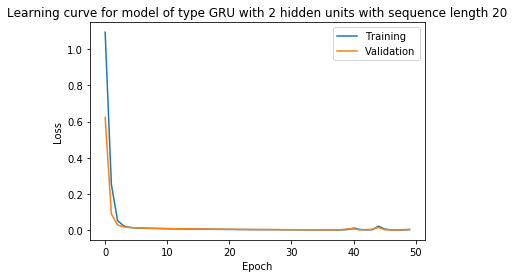

INFO:root:[2020-05-14 16:36:42.943719]: Training model of type LSTM with 2 hidden units
INFO:root:[2020-05-14 16:36:42.944641]: Training model of type LSTM with 2 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:36:43.088369]: Training model of type LSTM with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:36:43.089265]: Epoch: 0
INFO:root:[2020-05-14 16:36:43.090033]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:36:43.109898]: Training loss: 1.0680108666419983
INFO:root:[2020-05-14 16:36:43.120841]: Validation loss: 0.8907944560050964
INFO:root:[2020-05-14 16:36:43.121603]: Epoch took: 0.032334 seconds
INFO:root:[2020-05-14 16:36:43.122219]: Epoch: 1
INFO:root:[2020-05-14 16:36:43.122866]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:36:43.143189]: Training loss: 0.8159940242767334
INFO:root:[2020-05-14 16:36:43.153891]: Validation loss: 0.6685906648635864
INFO:root:[2020-05-14 16:36:43.154674

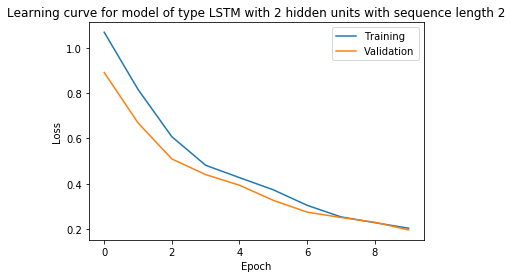

INFO:root:[2020-05-14 16:36:43.916218]: Training model of type LSTM with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:36:43.916807]: Epoch: 0
INFO:root:[2020-05-14 16:36:43.917810]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:36:43.974011]: Training loss: 0.7899171352386475
INFO:root:[2020-05-14 16:36:43.997164]: Validation loss: 0.5771538615226746
INFO:root:[2020-05-14 16:36:43.997987]: Epoch took: 0.081175 seconds
INFO:root:[2020-05-14 16:36:43.998560]: Epoch: 1
INFO:root:[2020-05-14 16:36:43.999517]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:36:44.057190]: Training loss: 0.5481795728206634
INFO:root:[2020-05-14 16:36:44.079601]: Validation loss: 0.4572376012802124
INFO:root:[2020-05-14 16:36:44.080417]: Epoch took: 0.081852 seconds
INFO:root:[2020-05-14 16:36:44.081028]: Epoch: 2
INFO:root:[2020-05-14 16:36:44.081804]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:36:44.142

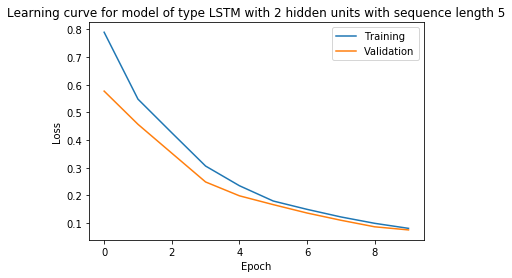

INFO:root:[2020-05-14 16:36:45.614048]: Training model of type LSTM with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:36:45.615145]: Epoch: 0
INFO:root:[2020-05-14 16:36:45.615860]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:45.766848]: Training loss: 0.8103662729263306
INFO:root:[2020-05-14 16:36:45.816836]: Validation loss: 0.5923315286636353
INFO:root:[2020-05-14 16:36:45.817695]: Epoch took: 0.202544 seconds
INFO:root:[2020-05-14 16:36:45.818329]: Epoch: 1
INFO:root:[2020-05-14 16:36:45.818857]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:46.018989]: Training loss: 0.3658828794956207
INFO:root:[2020-05-14 16:36:46.066677]: Validation loss: 0.32661524415016174
INFO:root:[2020-05-14 16:36:46.067196]: Epoch took: 0.248865 seconds
INFO:root:[2020-05-14 16:36:46.067921]: Epoch: 2
INFO:root:[2020-05-14 16:36:46.068586]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:4

INFO:root:[2020-05-14 16:36:50.267449]: Training loss: 0.0451634481549263
INFO:root:[2020-05-14 16:36:50.315062]: Validation loss: 0.03652596473693848
INFO:root:[2020-05-14 16:36:50.315780]: Epoch took: 0.193871 seconds
INFO:root:[2020-05-14 16:36:50.316405]: Epoch: 23
INFO:root:[2020-05-14 16:36:50.316896]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:50.457996]: Training loss: 0.04394598044455052
INFO:root:[2020-05-14 16:36:50.504537]: Validation loss: 0.04093807935714722
INFO:root:[2020-05-14 16:36:50.505056]: Epoch took: 0.188648 seconds
INFO:root:[2020-05-14 16:36:50.506056]: Epoch: 24
INFO:root:[2020-05-14 16:36:50.506658]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:36:50.649892]: Training loss: 0.03870044685900211
INFO:root:[2020-05-14 16:36:50.738825]: Validation loss: 0.03576267510652542
INFO:root:[2020-05-14 16:36:50.739579]: Epoch took: 0.233519 seconds


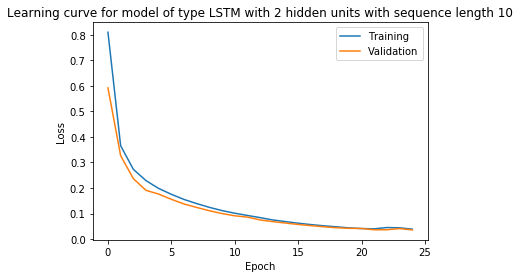

INFO:root:[2020-05-14 16:36:52.268958]: Training model of type LSTM with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:36:52.270531]: Epoch: 0
INFO:root:[2020-05-14 16:36:52.271514]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:52.685713]: Training loss: 2.2996897965669634
INFO:root:[2020-05-14 16:36:52.799420]: Validation loss: 0.43327802419662476
INFO:root:[2020-05-14 16:36:52.800234]: Epoch took: 0.529699 seconds
INFO:root:[2020-05-14 16:36:52.800808]: Epoch: 1
INFO:root:[2020-05-14 16:36:52.801484]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:36:53.264013]: Training loss: 0.4599928312003613
INFO:root:[2020-05-14 16:36:53.378327]: Validation loss: 0.19814515113830566
INFO:root:[2020-05-14 16:36:53.379147]: Epoch took: 0.578332 seconds
INFO:root:[2020-05-14 16:36:53.379830]: Epoch: 2
INFO:root:[2020-05-14 16:36:53.380583]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:

INFO:root:[2020-05-14 16:37:05.275619]: Training loss: 0.029577729385346176
INFO:root:[2020-05-14 16:37:05.434810]: Validation loss: 0.026021327823400497
INFO:root:[2020-05-14 16:37:05.435502]: Epoch took: 0.58251 seconds
INFO:root:[2020-05-14 16:37:05.436245]: Epoch: 23
INFO:root:[2020-05-14 16:37:05.436781]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:05.849922]: Training loss: 0.028150143288075923
INFO:root:[2020-05-14 16:37:05.965476]: Validation loss: 0.024724429473280907
INFO:root:[2020-05-14 16:37:05.966003]: Epoch took: 0.529756 seconds
INFO:root:[2020-05-14 16:37:05.966673]: Epoch: 24
INFO:root:[2020-05-14 16:37:05.967332]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:06.383251]: Training loss: 0.02691021328791976
INFO:root:[2020-05-14 16:37:06.538788]: Validation loss: 0.0235238429158926
INFO:root:[2020-05-14 16:37:06.539510]: Epoch took: 0.572832 seconds
INFO:root:[2020-05-14 16:37:06.540143]: Epoch: 25
I

INFO:root:[2020-05-14 16:37:17.887337]: Epoch took: 0.594669 seconds
INFO:root:[2020-05-14 16:37:17.887963]: Epoch: 45
INFO:root:[2020-05-14 16:37:17.888914]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:18.332351]: Training loss: 0.015296855522319675
INFO:root:[2020-05-14 16:37:18.448038]: Validation loss: 0.013352538459002972
INFO:root:[2020-05-14 16:37:18.448590]: Epoch took: 0.560622 seconds
INFO:root:[2020-05-14 16:37:18.449318]: Epoch: 46
INFO:root:[2020-05-14 16:37:18.450111]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:18.874285]: Training loss: 0.015204475680366158
INFO:root:[2020-05-14 16:37:19.038521]: Validation loss: 0.013272495940327644
INFO:root:[2020-05-14 16:37:19.039076]: Epoch took: 0.589754 seconds
INFO:root:[2020-05-14 16:37:19.039536]: Epoch: 47
INFO:root:[2020-05-14 16:37:19.040460]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:19.496800]: Training loss: 0.01

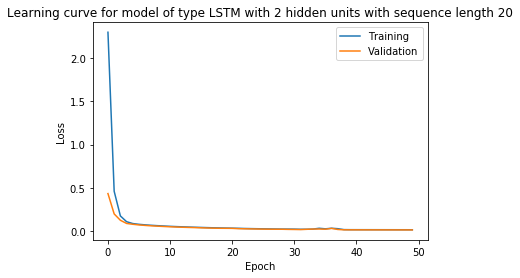

INFO:root:[2020-05-14 16:37:20.941923]: Training model of type Elman with 5 hidden units
INFO:root:[2020-05-14 16:37:20.942874]: Training model of type Elman with 5 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:37:21.100644]: Training model of type Elman with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:37:21.101156]: Epoch: 0
INFO:root:[2020-05-14 16:37:21.101906]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:37:21.119752]: Training loss: 1.1163083612918854
INFO:root:[2020-05-14 16:37:21.129107]: Validation loss: 0.3324255347251892
INFO:root:[2020-05-14 16:37:21.130273]: Epoch took: 0.029108 seconds
INFO:root:[2020-05-14 16:37:21.131022]: Epoch: 1
INFO:root:[2020-05-14 16:37:21.131577]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:37:21.149760]: Training loss: 0.3622974306344986
INFO:root:[2020-05-14 16:37:21.159138]: Validation loss: 0.31929871439933777
INFO:root:[2020-05-14 16:37:21.15

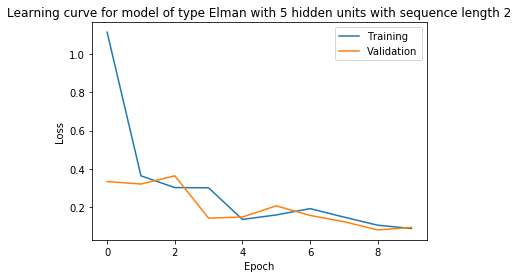

INFO:root:[2020-05-14 16:37:21.912691]: Training model of type Elman with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:37:21.913611]: Epoch: 0
INFO:root:[2020-05-14 16:37:21.914306]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:37:21.960897]: Training loss: 3.6095529794692993
INFO:root:[2020-05-14 16:37:21.982694]: Validation loss: 1.4593815803527832
INFO:root:[2020-05-14 16:37:21.983286]: Epoch took: 0.069669 seconds
INFO:root:[2020-05-14 16:37:21.984053]: Epoch: 1
INFO:root:[2020-05-14 16:37:21.984752]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:37:22.031182]: Training loss: 1.1219140768051148
INFO:root:[2020-05-14 16:37:22.051772]: Validation loss: 0.8639848828315735
INFO:root:[2020-05-14 16:37:22.052342]: Epoch took: 0.068287 seconds
INFO:root:[2020-05-14 16:37:22.053015]: Epoch: 2
INFO:root:[2020-05-14 16:37:22.053647]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:37:22.15

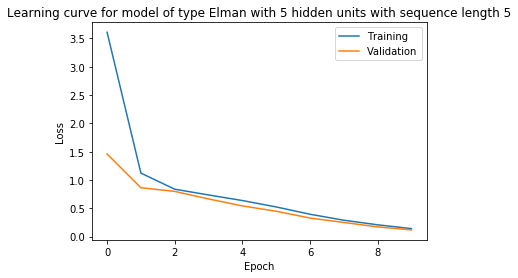

INFO:root:[2020-05-14 16:37:23.453429]: Training model of type Elman with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:37:23.454357]: Epoch: 0
INFO:root:[2020-05-14 16:37:23.455123]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:23.613291]: Training loss: 3.0111554503440856
INFO:root:[2020-05-14 16:37:23.654155]: Validation loss: 2.868631362915039
INFO:root:[2020-05-14 16:37:23.654983]: Epoch took: 0.200622 seconds
INFO:root:[2020-05-14 16:37:23.655615]: Epoch: 1
INFO:root:[2020-05-14 16:37:23.656231]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:23.752493]: Training loss: 2.4198933482170104
INFO:root:[2020-05-14 16:37:23.793843]: Validation loss: 1.8057973384857178
INFO:root:[2020-05-14 16:37:23.794679]: Epoch took: 0.139057 seconds
INFO:root:[2020-05-14 16:37:23.795370]: Epoch: 2
INFO:root:[2020-05-14 16:37:23.796130]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:23

INFO:root:[2020-05-14 16:37:26.928669]: Training loss: 0.07637008838355541
INFO:root:[2020-05-14 16:37:26.971815]: Validation loss: 0.12307028472423553
INFO:root:[2020-05-14 16:37:26.972420]: Epoch took: 0.146515 seconds
INFO:root:[2020-05-14 16:37:26.973142]: Epoch: 23
INFO:root:[2020-05-14 16:37:26.973792]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:27.117611]: Training loss: 0.07879852764308452
INFO:root:[2020-05-14 16:37:27.160408]: Validation loss: 0.03481388837099075
INFO:root:[2020-05-14 16:37:27.161251]: Epoch took: 0.188105 seconds
INFO:root:[2020-05-14 16:37:27.161848]: Epoch: 24
INFO:root:[2020-05-14 16:37:27.162346]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:27.261781]: Training loss: 0.040316329710185526
INFO:root:[2020-05-14 16:37:27.305296]: Validation loss: 0.043055880814790726
INFO:root:[2020-05-14 16:37:27.305943]: Epoch took: 0.144091 seconds


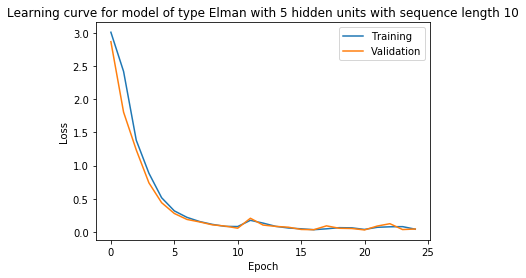

INFO:root:[2020-05-14 16:37:28.917234]: Training model of type Elman with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:37:28.917874]: Epoch: 0
INFO:root:[2020-05-14 16:37:28.918782]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:29.207803]: Training loss: 4.368079653382301
INFO:root:[2020-05-14 16:37:29.303018]: Validation loss: 2.463473081588745
INFO:root:[2020-05-14 16:37:29.303791]: Epoch took: 0.385911 seconds
INFO:root:[2020-05-14 16:37:29.304370]: Epoch: 1
INFO:root:[2020-05-14 16:37:29.304895]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:29.547138]: Training loss: 2.2631691336631774
INFO:root:[2020-05-14 16:37:29.636965]: Validation loss: 2.037414073944092
INFO:root:[2020-05-14 16:37:29.637753]: Epoch took: 0.333379 seconds
INFO:root:[2020-05-14 16:37:29.638300]: Epoch: 2
INFO:root:[2020-05-14 16:37:29.639008]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:2

INFO:root:[2020-05-14 16:37:36.672636]: Training loss: 0.052873780205845836
INFO:root:[2020-05-14 16:37:36.798926]: Validation loss: 0.05547725409269333
INFO:root:[2020-05-14 16:37:36.799618]: Epoch took: 0.358141 seconds
INFO:root:[2020-05-14 16:37:36.800193]: Epoch: 23
INFO:root:[2020-05-14 16:37:36.800812]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:37.028212]: Training loss: 0.04820357672870159
INFO:root:[2020-05-14 16:37:37.115054]: Validation loss: 0.0517958402633667
INFO:root:[2020-05-14 16:37:37.115565]: Epoch took: 0.315369 seconds
INFO:root:[2020-05-14 16:37:37.116356]: Epoch: 24
INFO:root:[2020-05-14 16:37:37.117051]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:37.386440]: Training loss: 0.045964562334120274
INFO:root:[2020-05-14 16:37:37.471766]: Validation loss: 0.049507882446050644
INFO:root:[2020-05-14 16:37:37.472290]: Epoch took: 0.355932 seconds
INFO:root:[2020-05-14 16:37:37.473051]: Epoch: 25
I

INFO:root:[2020-05-14 16:37:44.347540]: Epoch: 45
INFO:root:[2020-05-14 16:37:44.348183]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:44.580001]: Training loss: 0.023950714990496634
INFO:root:[2020-05-14 16:37:44.667693]: Validation loss: 0.02615318074822426
INFO:root:[2020-05-14 16:37:44.668209]: Epoch took: 0.320666 seconds
INFO:root:[2020-05-14 16:37:44.669008]: Epoch: 46
INFO:root:[2020-05-14 16:37:44.669507]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:44.944315]: Training loss: 0.023310895869508387
INFO:root:[2020-05-14 16:37:45.035894]: Validation loss: 0.02548293210566044
INFO:root:[2020-05-14 16:37:45.036431]: Epoch took: 0.36742 seconds
INFO:root:[2020-05-14 16:37:45.037248]: Epoch: 47
INFO:root:[2020-05-14 16:37:45.037698]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:45.269842]: Training loss: 0.022700980864465238
INFO:root:[2020-05-14 16:37:45.400679]: Validation loss

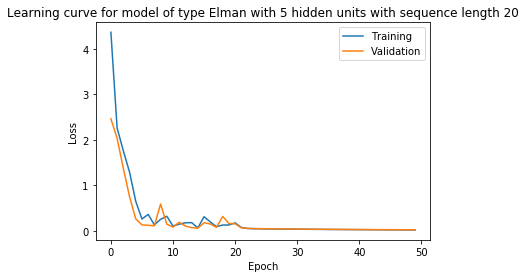

INFO:root:[2020-05-14 16:37:46.194622]: Training model of type GRU with 5 hidden units
INFO:root:[2020-05-14 16:37:46.195544]: Training model of type GRU with 5 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:37:46.342394]: Training model of type GRU with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:37:46.343518]: Epoch: 0
INFO:root:[2020-05-14 16:37:46.344267]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:37:46.365217]: Training loss: 1.9442628026008606
INFO:root:[2020-05-14 16:37:46.376491]: Validation loss: 1.1086925268173218
INFO:root:[2020-05-14 16:37:46.377432]: Epoch took: 0.033911 seconds
INFO:root:[2020-05-14 16:37:46.378076]: Epoch: 1
INFO:root:[2020-05-14 16:37:46.378691]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:37:46.397857]: Training loss: 0.9181240499019623
INFO:root:[2020-05-14 16:37:46.407271]: Validation loss: 0.6000250577926636
INFO:root:[2020-05-14 16:37:46.408044]: 

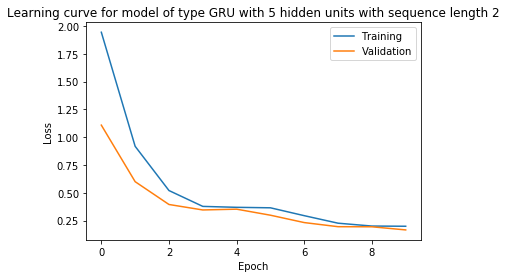

INFO:root:[2020-05-14 16:37:47.129597]: Training model of type GRU with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:37:47.130511]: Epoch: 0
INFO:root:[2020-05-14 16:37:47.131281]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:37:47.243097]: Training loss: 2.04420063495636
INFO:root:[2020-05-14 16:37:47.266420]: Validation loss: 1.267377495765686
INFO:root:[2020-05-14 16:37:47.267136]: Epoch took: 0.13662 seconds
INFO:root:[2020-05-14 16:37:47.267787]: Epoch: 1
INFO:root:[2020-05-14 16:37:47.268478]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:37:47.324859]: Training loss: 0.8361967325210571
INFO:root:[2020-05-14 16:37:47.347865]: Validation loss: 0.8310567736625671
INFO:root:[2020-05-14 16:37:47.348450]: Epoch took: 0.08066 seconds
INFO:root:[2020-05-14 16:37:47.349158]: Epoch: 2
INFO:root:[2020-05-14 16:37:47.349790]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:37:47.406816]: 

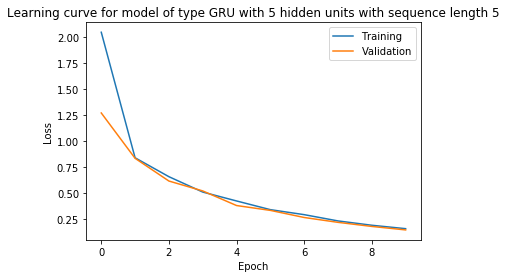

INFO:root:[2020-05-14 16:37:48.867499]: Training model of type GRU with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:37:48.868218]: Epoch: 0
INFO:root:[2020-05-14 16:37:48.869126]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:49.008788]: Training loss: 0.6850585371255875
INFO:root:[2020-05-14 16:37:49.056543]: Validation loss: 0.49124354124069214
INFO:root:[2020-05-14 16:37:49.057390]: Epoch took: 0.189165 seconds
INFO:root:[2020-05-14 16:37:49.058075]: Epoch: 1
INFO:root:[2020-05-14 16:37:49.058824]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:49.198051]: Training loss: 0.3386348783969879
INFO:root:[2020-05-14 16:37:49.247335]: Validation loss: 0.2616198658943176
INFO:root:[2020-05-14 16:37:49.248169]: Epoch took: 0.190088 seconds
INFO:root:[2020-05-14 16:37:49.248842]: Epoch: 2
INFO:root:[2020-05-14 16:37:49.249520]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:49

INFO:root:[2020-05-14 16:37:53.513746]: Training loss: 0.003378838417120278
INFO:root:[2020-05-14 16:37:53.561924]: Validation loss: 0.005492489319294691
INFO:root:[2020-05-14 16:37:53.562696]: Epoch took: 0.187992 seconds
INFO:root:[2020-05-14 16:37:53.563395]: Epoch: 23
INFO:root:[2020-05-14 16:37:53.564063]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:53.702859]: Training loss: 0.004076709016226232
INFO:root:[2020-05-14 16:37:53.751215]: Validation loss: 0.011982040479779243
INFO:root:[2020-05-14 16:37:53.751910]: Epoch took: 0.188513 seconds
INFO:root:[2020-05-14 16:37:53.752480]: Epoch: 24
INFO:root:[2020-05-14 16:37:53.753116]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:37:53.892726]: Training loss: 0.014930243464186787
INFO:root:[2020-05-14 16:37:53.940534]: Validation loss: 0.013511458411812782
INFO:root:[2020-05-14 16:37:53.941587]: Epoch took: 0.189101 seconds


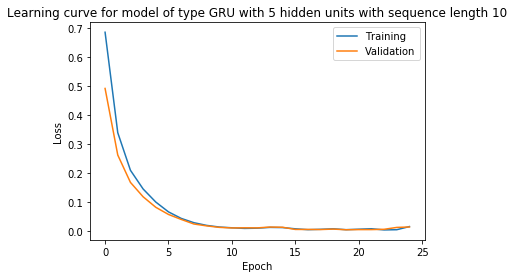

INFO:root:[2020-05-14 16:37:55.472954]: Training model of type GRU with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:37:55.474755]: Epoch: 0
INFO:root:[2020-05-14 16:37:55.475719]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:55.931637]: Training loss: 1.088799698650837
INFO:root:[2020-05-14 16:37:56.047181]: Validation loss: 0.4043698310852051
INFO:root:[2020-05-14 16:37:56.048069]: Epoch took: 0.573327 seconds
INFO:root:[2020-05-14 16:37:56.048728]: Epoch: 1
INFO:root:[2020-05-14 16:37:56.049221]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37:56.501607]: Training loss: 0.23100685216486455
INFO:root:[2020-05-14 16:37:56.619366]: Validation loss: 0.12843072414398193
INFO:root:[2020-05-14 16:37:56.620144]: Epoch took: 0.571411 seconds
INFO:root:[2020-05-14 16:37:56.620841]: Epoch: 2
INFO:root:[2020-05-14 16:37:56.621361]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:37

INFO:root:[2020-05-14 16:38:08.196503]: Training loss: 0.001824074552860111
INFO:root:[2020-05-14 16:38:08.313303]: Validation loss: 0.0015779563691467047
INFO:root:[2020-05-14 16:38:08.314042]: Epoch took: 0.535107 seconds
INFO:root:[2020-05-14 16:38:08.314652]: Epoch: 23
INFO:root:[2020-05-14 16:38:08.315140]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:08.746249]: Training loss: 0.001729013561271131
INFO:root:[2020-05-14 16:38:08.922538]: Validation loss: 0.0015058353310450912
INFO:root:[2020-05-14 16:38:08.923320]: Epoch took: 0.608665 seconds
INFO:root:[2020-05-14 16:38:08.923960]: Epoch: 24
INFO:root:[2020-05-14 16:38:08.924608]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:09.357200]: Training loss: 0.001645475992700085
INFO:root:[2020-05-14 16:38:09.481594]: Validation loss: 0.0014595210086554289
INFO:root:[2020-05-14 16:38:09.482305]: Epoch took: 0.558341 seconds
INFO:root:[2020-05-14 16:38:09.483013]: Epoc

INFO:root:[2020-05-14 16:38:21.051329]: Epoch took: 0.593491 seconds
INFO:root:[2020-05-14 16:38:21.051891]: Epoch: 45
INFO:root:[2020-05-14 16:38:21.052551]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:21.467046]: Training loss: 0.0028519958519609644
INFO:root:[2020-05-14 16:38:21.584896]: Validation loss: 0.0011681478936225176
INFO:root:[2020-05-14 16:38:21.585437]: Epoch took: 0.533542 seconds
INFO:root:[2020-05-14 16:38:21.586117]: Epoch: 46
INFO:root:[2020-05-14 16:38:21.586601]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:22.046526]: Training loss: 0.0011143512499984353
INFO:root:[2020-05-14 16:38:22.163607]: Validation loss: 0.0008609074866399169
INFO:root:[2020-05-14 16:38:22.164174]: Epoch took: 0.578054 seconds
INFO:root:[2020-05-14 16:38:22.164870]: Epoch: 47
INFO:root:[2020-05-14 16:38:22.165523]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:22.581212]: Training loss: 

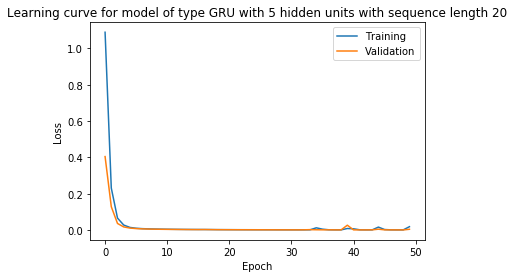

INFO:root:[2020-05-14 16:38:23.928629]: Training model of type LSTM with 5 hidden units
INFO:root:[2020-05-14 16:38:23.929544]: Training model of type LSTM with 5 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:38:24.076919]: Training model of type LSTM with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:38:24.077532]: Epoch: 0
INFO:root:[2020-05-14 16:38:24.078143]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:38:24.101142]: Training loss: 4.3225767612457275
INFO:root:[2020-05-14 16:38:24.109961]: Validation loss: 2.8739075660705566
INFO:root:[2020-05-14 16:38:24.110715]: Epoch took: 0.033179 seconds
INFO:root:[2020-05-14 16:38:24.111398]: Epoch: 1
INFO:root:[2020-05-14 16:38:24.111803]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:38:24.184948]: Training loss: 2.8177452087402344
INFO:root:[2020-05-14 16:38:24.195642]: Validation loss: 2.0423076152801514
INFO:root:[2020-05-14 16:38:24.196906

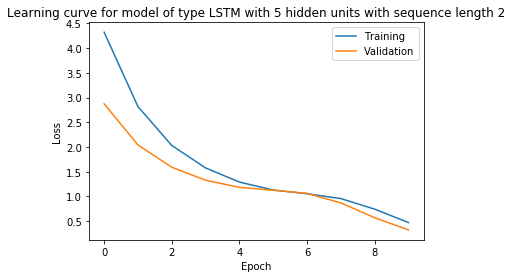

INFO:root:[2020-05-14 16:38:24.939624]: Training model of type LSTM with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:38:24.940997]: Epoch: 0
INFO:root:[2020-05-14 16:38:24.941875]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:38:25.007505]: Training loss: 0.6465716123580932
INFO:root:[2020-05-14 16:38:25.032001]: Validation loss: 0.42426228523254395
INFO:root:[2020-05-14 16:38:25.032741]: Epoch took: 0.09174 seconds
INFO:root:[2020-05-14 16:38:25.033386]: Epoch: 1
INFO:root:[2020-05-14 16:38:25.034008]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:38:25.145248]: Training loss: 0.3488083600997925
INFO:root:[2020-05-14 16:38:25.169100]: Validation loss: 0.2615359127521515
INFO:root:[2020-05-14 16:38:25.170014]: Epoch took: 0.136626 seconds
INFO:root:[2020-05-14 16:38:25.170674]: Epoch: 2
INFO:root:[2020-05-14 16:38:25.171165]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:38:25.232

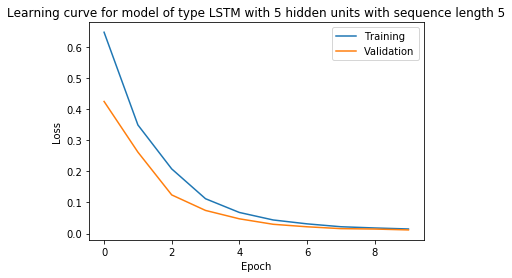

INFO:root:[2020-05-14 16:38:26.748718]: Training model of type LSTM with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:38:26.749593]: Epoch: 0
INFO:root:[2020-05-14 16:38:26.750315]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:38:26.905094]: Training loss: 0.9512302182614804
INFO:root:[2020-05-14 16:38:26.954601]: Validation loss: 0.7477084398269653
INFO:root:[2020-05-14 16:38:26.955411]: Epoch took: 0.20581 seconds
INFO:root:[2020-05-14 16:38:26.956028]: Epoch: 1
INFO:root:[2020-05-14 16:38:26.956658]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:38:27.114690]: Training loss: 0.41869535893201826
INFO:root:[2020-05-14 16:38:27.166145]: Validation loss: 0.2124050408601761
INFO:root:[2020-05-14 16:38:27.166792]: Epoch took: 0.21076 seconds
INFO:root:[2020-05-14 16:38:27.167470]: Epoch: 2
INFO:root:[2020-05-14 16:38:27.168074]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:38:27.

INFO:root:[2020-05-14 16:38:31.857442]: Training loss: 0.006297556636855006
INFO:root:[2020-05-14 16:38:31.912185]: Validation loss: 0.005797906778752804
INFO:root:[2020-05-14 16:38:31.912727]: Epoch took: 0.220983 seconds
INFO:root:[2020-05-14 16:38:31.913550]: Epoch: 23
INFO:root:[2020-05-14 16:38:31.914083]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:38:32.108286]: Training loss: 0.00586550529114902
INFO:root:[2020-05-14 16:38:32.158278]: Validation loss: 0.0053924210369586945
INFO:root:[2020-05-14 16:38:32.158790]: Epoch took: 0.245238 seconds
INFO:root:[2020-05-14 16:38:32.159487]: Epoch: 24
INFO:root:[2020-05-14 16:38:32.160217]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:38:32.313997]: Training loss: 0.0054874753579497336
INFO:root:[2020-05-14 16:38:32.364136]: Validation loss: 0.005025430582463741
INFO:root:[2020-05-14 16:38:32.364638]: Epoch took: 0.20515 seconds


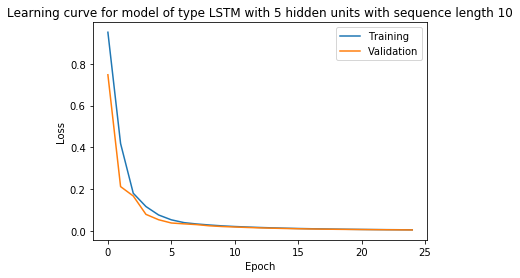

INFO:root:[2020-05-14 16:38:33.991917]: Training model of type LSTM with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:38:33.992530]: Epoch: 0
INFO:root:[2020-05-14 16:38:33.993430]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:34.511347]: Training loss: 1.5032232046592982
INFO:root:[2020-05-14 16:38:34.643286]: Validation loss: 0.786922812461853
INFO:root:[2020-05-14 16:38:34.644164]: Epoch took: 0.65163 seconds
INFO:root:[2020-05-14 16:38:34.644698]: Epoch: 1
INFO:root:[2020-05-14 16:38:34.645354]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:35.124735]: Training loss: 0.36238059028983116
INFO:root:[2020-05-14 16:38:35.260761]: Validation loss: 0.17468707263469696
INFO:root:[2020-05-14 16:38:35.261575]: Epoch took: 0.61687 seconds
INFO:root:[2020-05-14 16:38:35.262330]: Epoch: 2
INFO:root:[2020-05-14 16:38:35.263292]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:

INFO:root:[2020-05-14 16:38:48.212218]: Training loss: 0.003045017377007753
INFO:root:[2020-05-14 16:38:48.377064]: Validation loss: 0.0030360568780452013
INFO:root:[2020-05-14 16:38:48.377767]: Epoch took: 0.641678 seconds
INFO:root:[2020-05-14 16:38:48.378320]: Epoch: 23
INFO:root:[2020-05-14 16:38:48.378855]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:48.849593]: Training loss: 0.0027678396319970487
INFO:root:[2020-05-14 16:38:48.972457]: Validation loss: 0.0027572258841246367
INFO:root:[2020-05-14 16:38:48.973155]: Epoch took: 0.594829 seconds
INFO:root:[2020-05-14 16:38:48.973786]: Epoch: 24
INFO:root:[2020-05-14 16:38:48.974463]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:38:49.476427]: Training loss: 0.002502655377611518
INFO:root:[2020-05-14 16:38:49.598976]: Validation loss: 0.0025017624720931053
INFO:root:[2020-05-14 16:38:49.599736]: Epoch took: 0.625946 seconds
INFO:root:[2020-05-14 16:38:49.600533]: Epo

INFO:root:[2020-05-14 16:39:01.724741]: Epoch took: 0.621439 seconds
INFO:root:[2020-05-14 16:39:01.725457]: Epoch: 45
INFO:root:[2020-05-14 16:39:01.725918]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:39:02.187833]: Training loss: 0.0032382506469730288
INFO:root:[2020-05-14 16:39:02.310027]: Validation loss: 0.0009605885716155171
INFO:root:[2020-05-14 16:39:02.310702]: Epoch took: 0.585241 seconds
INFO:root:[2020-05-14 16:39:02.311288]: Epoch: 46
INFO:root:[2020-05-14 16:39:02.311873]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:39:02.812129]: Training loss: 0.004649399005575106
INFO:root:[2020-05-14 16:39:02.934715]: Validation loss: 0.0011864586267620325
INFO:root:[2020-05-14 16:39:02.935392]: Epoch took: 0.624099 seconds
INFO:root:[2020-05-14 16:39:02.936038]: Epoch: 47
INFO:root:[2020-05-14 16:39:02.936692]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:39:03.393680]: Training loss: 0

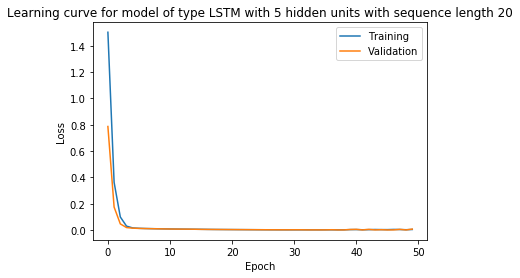

In [14]:
modelTypesHigherDamping = [RNNElman(2), GRU(2), LSTM(2), RNNElman(5), GRU(5), LSTM(5)]

for modelType in modelTypesHigherDamping:
    writeLog('Training {0}'.format(modelType), logger)
    trainSchedule(modelType, dampingFactor=0.9)

INFO:root:[2020-05-14 16:39:04.884235]: model of type Elman with 2 hidden units
INFO:root:[2020-05-14 16:39:07.397421]: model of type GRU with 2 hidden units
INFO:root:[2020-05-14 16:39:10.316750]: model of type LSTM with 2 hidden units
INFO:root:[2020-05-14 16:39:13.329279]: model of type Elman with 5 hidden units
INFO:root:[2020-05-14 16:39:15.885195]: model of type GRU with 5 hidden units
INFO:root:[2020-05-14 16:39:18.900845]: model of type LSTM with 5 hidden units


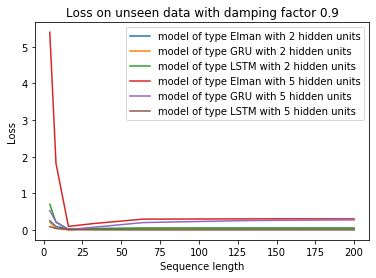

In [15]:
allModelLossesHigherDamping = []
for modelType in modelTypesHigherDamping:
    writeLog(modelType, logger)
    sequenceLengths = [4,8,16,32,64,128,150,200]
    losses = []
    for sequenceLength in sequenceLengths:
        losses.append(evaluateOnUnseenData(modelType, sequenceLength, dampingFactor=0.9))
    allModelLossesHigherDamping.append(losses)
_, ax = plt.subplots()
ax.plot(sequenceLengths, allModelLossesHigherDamping[0], label=str(modelTypesHigherDamping[0]))
ax.plot(sequenceLengths, allModelLossesHigherDamping[1], label=str(modelTypesHigherDamping[1]))
ax.plot(sequenceLengths, allModelLossesHigherDamping[2], label=str(modelTypesHigherDamping[2]))
ax.plot(sequenceLengths, allModelLossesHigherDamping[3], label=str(modelTypesHigherDamping[3]))
ax.plot(sequenceLengths, allModelLossesHigherDamping[4], label=str(modelTypesHigherDamping[4]))
ax.plot(sequenceLengths, allModelLossesHigherDamping[5], label=str(modelTypesHigherDamping[5]))
ax.set_xlabel('Sequence length')
ax.set_ylabel('Loss')
ax.set_title('Loss on unseen data with damping factor 0.9')
ax.legend()
plt.show()

In [43]:
for modelType in modelTypesHigherDamping:
    writeLog(str(modelType) + ': ' + str(evaluateOnUnseenData(modelType, 1000, dampingFactor=0.9)), logger)

INFO:root:[2020-05-14 18:51:14.147183]: model of type Elman with 2 hidden units: 0.04681316018104553
INFO:root:[2020-05-14 18:51:15.686589]: model of type GRU with 2 hidden units: 0.03509969115257263
INFO:root:[2020-05-14 18:51:17.306240]: model of type LSTM with 2 hidden units: 0.049142873287200926
INFO:root:[2020-05-14 18:51:18.271301]: model of type Elman with 5 hidden units: 0.30702269077301025
INFO:root:[2020-05-14 18:51:19.915822]: model of type GRU with 5 hidden units: 0.29775271415710447
INFO:root:[2020-05-14 18:51:21.734857]: model of type LSTM with 5 hidden units: 0.0019636964425444603


In [17]:
print(zeroClassifierLoss(1000, dampingFactor=0.9))

5.259027099609375


An LSTM with more units is the clear winner. The other 2 model types actually do worse when increasing the size. However, all models still perform much better than the expected loss from the zero classifier, which would be 1/(1-DAMPING_FACTOR^2).

For fun let's also do this with no damping at all, so the network is forced to remember the entire sequence to do well.

INFO:root:[2020-05-14 16:44:56.060171]: Training model of type Elman with 2 hidden units
INFO:root:[2020-05-14 16:44:56.061391]: Training model of type Elman with 2 hidden units with a damping factor of 1
INFO:root:[2020-05-14 16:44:56.210467]: Training model of type Elman with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:44:56.211449]: Epoch: 0
INFO:root:[2020-05-14 16:44:56.212165]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:44:56.231638]: Training loss: 3.9597235918045044
INFO:root:[2020-05-14 16:44:56.240339]: Validation loss: 2.9489920139312744
INFO:root:[2020-05-14 16:44:56.241201]: Epoch took: 0.029746 seconds
INFO:root:[2020-05-14 16:44:56.241937]: Epoch: 1
INFO:root:[2020-05-14 16:44:56.243018]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:44:56.270978]: Training loss: 2.6878093481063843
INFO:root:[2020-05-14 16:44:56.281752]: Validation loss: 2.298478841781616
INFO:root:[2020-05-14 16:44:56.282812

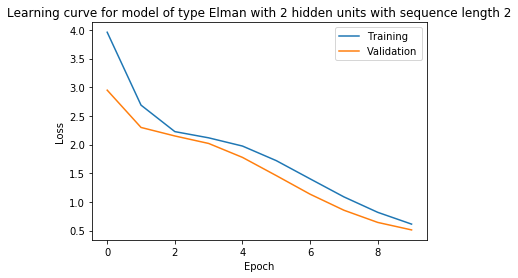

INFO:root:[2020-05-14 16:44:57.100749]: Training model of type Elman with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:44:57.102013]: Epoch: 0
INFO:root:[2020-05-14 16:44:57.102774]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:44:57.151158]: Training loss: 2.442496657371521
INFO:root:[2020-05-14 16:44:57.171645]: Validation loss: 1.7298283576965332
INFO:root:[2020-05-14 16:44:57.172564]: Epoch took: 0.070563 seconds
INFO:root:[2020-05-14 16:44:57.173196]: Epoch: 1
INFO:root:[2020-05-14 16:44:57.173740]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:44:57.225540]: Training loss: 1.75885910987854
INFO:root:[2020-05-14 16:44:57.249975]: Validation loss: 1.7687262296676636
INFO:root:[2020-05-14 16:44:57.250592]: Epoch took: 0.077393 seconds
INFO:root:[2020-05-14 16:44:57.251375]: Epoch: 2
INFO:root:[2020-05-14 16:44:57.251947]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:44:57.36189

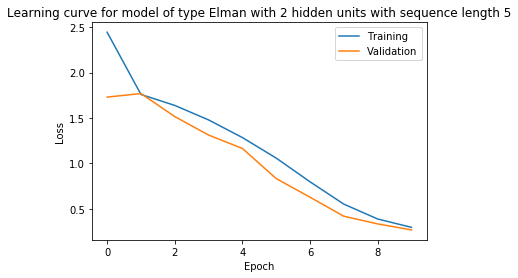

INFO:root:[2020-05-14 16:44:58.749983]: Training model of type Elman with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:44:58.750699]: Epoch: 0
INFO:root:[2020-05-14 16:44:58.751177]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:44:58.903574]: Training loss: 5.415731680393219
INFO:root:[2020-05-14 16:44:58.943461]: Validation loss: 4.423219680786133
INFO:root:[2020-05-14 16:44:58.944188]: Epoch took: 0.193484 seconds
INFO:root:[2020-05-14 16:44:58.944863]: Epoch: 1
INFO:root:[2020-05-14 16:44:58.945349]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:44:59.036780]: Training loss: 3.2893402338027955
INFO:root:[2020-05-14 16:44:59.076413]: Validation loss: 2.865201234817505
INFO:root:[2020-05-14 16:44:59.076939]: Epoch took: 0.132073 seconds
INFO:root:[2020-05-14 16:44:59.077670]: Epoch: 2
INFO:root:[2020-05-14 16:44:59.078280]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:44:59.1

INFO:root:[2020-05-14 16:45:02.159796]: Training loss: 0.2733521029353142
INFO:root:[2020-05-14 16:45:02.199426]: Validation loss: 0.2960226535797119
INFO:root:[2020-05-14 16:45:02.199940]: Epoch took: 0.137033 seconds
INFO:root:[2020-05-14 16:45:02.200749]: Epoch: 23
INFO:root:[2020-05-14 16:45:02.201225]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:02.332803]: Training loss: 0.2534410163760185
INFO:root:[2020-05-14 16:45:02.372825]: Validation loss: 0.29108911752700806
INFO:root:[2020-05-14 16:45:02.373337]: Epoch took: 0.172586 seconds
INFO:root:[2020-05-14 16:45:02.374085]: Epoch: 24
INFO:root:[2020-05-14 16:45:02.374780]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:02.469977]: Training loss: 0.2462494820356369
INFO:root:[2020-05-14 16:45:02.511908]: Validation loss: 0.2880389392375946
INFO:root:[2020-05-14 16:45:02.512417]: Epoch took: 0.138331 seconds


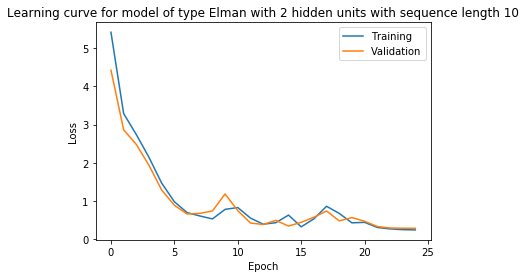

INFO:root:[2020-05-14 16:45:04.127994]: Training model of type Elman with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:45:04.128527]: Epoch: 0
INFO:root:[2020-05-14 16:45:04.129296]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:04.414222]: Training loss: 23.45636112689972
INFO:root:[2020-05-14 16:45:04.504597]: Validation loss: 17.287599563598633
INFO:root:[2020-05-14 16:45:04.505364]: Epoch took: 0.376832 seconds
INFO:root:[2020-05-14 16:45:04.506156]: Epoch: 1
INFO:root:[2020-05-14 16:45:04.506787]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:04.731330]: Training loss: 14.53300518989563
INFO:root:[2020-05-14 16:45:04.817799]: Validation loss: 11.111523628234863
INFO:root:[2020-05-14 16:45:04.818465]: Epoch took: 0.312307 seconds
INFO:root:[2020-05-14 16:45:04.819124]: Epoch: 2
INFO:root:[2020-05-14 16:45:04.819806]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:

INFO:root:[2020-05-14 16:45:11.821395]: Training loss: 2.1662024676799776
INFO:root:[2020-05-14 16:45:11.946693]: Validation loss: 1.9103381633758545
INFO:root:[2020-05-14 16:45:11.947408]: Epoch took: 0.344844 seconds
INFO:root:[2020-05-14 16:45:11.948083]: Epoch: 23
INFO:root:[2020-05-14 16:45:11.948681]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:12.168105]: Training loss: 1.959681087732315
INFO:root:[2020-05-14 16:45:12.261104]: Validation loss: 1.7480357885360718
INFO:root:[2020-05-14 16:45:12.261774]: Epoch took: 0.313686 seconds
INFO:root:[2020-05-14 16:45:12.262585]: Epoch: 24
INFO:root:[2020-05-14 16:45:12.263000]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:12.535894]: Training loss: 1.84271000623703
INFO:root:[2020-05-14 16:45:12.622006]: Validation loss: 1.654232382774353
INFO:root:[2020-05-14 16:45:12.622554]: Epoch took: 0.359964 seconds
INFO:root:[2020-05-14 16:45:12.623025]: Epoch: 25
INFO:root:[20

INFO:root:[2020-05-14 16:45:19.763462]: Training loss: 0.9370911628007889
INFO:root:[2020-05-14 16:45:19.852862]: Validation loss: 0.8247129321098328
INFO:root:[2020-05-14 16:45:19.853411]: Epoch took: 0.313196 seconds
INFO:root:[2020-05-14 16:45:19.854106]: Epoch: 46
INFO:root:[2020-05-14 16:45:19.854773]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:20.119009]: Training loss: 0.9084775537252426
INFO:root:[2020-05-14 16:45:20.207674]: Validation loss: 0.7981218695640564
INFO:root:[2020-05-14 16:45:20.208350]: Epoch took: 0.354242 seconds
INFO:root:[2020-05-14 16:45:20.209077]: Epoch: 47
INFO:root:[2020-05-14 16:45:20.209859]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:20.435589]: Training loss: 0.8799555718898773
INFO:root:[2020-05-14 16:45:20.570097]: Validation loss: 0.7714164853096008
INFO:root:[2020-05-14 16:45:20.570662]: Epoch took: 0.36158 seconds
INFO:root:[2020-05-14 16:45:20.571507]: Epoch: 48
INFO:root:

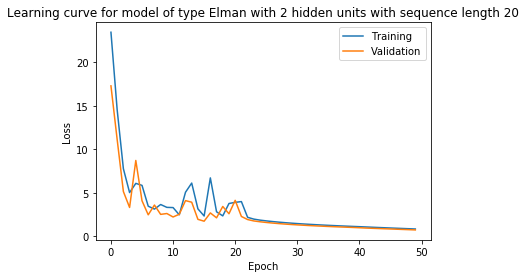

INFO:root:[2020-05-14 16:45:21.340495]: Training model of type GRU with 2 hidden units
INFO:root:[2020-05-14 16:45:21.341501]: Training model of type GRU with 2 hidden units with a damping factor of 1
INFO:root:[2020-05-14 16:45:21.491113]: Training model of type GRU with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:45:21.492033]: Epoch: 0
INFO:root:[2020-05-14 16:45:21.492697]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:45:21.513155]: Training loss: 3.1568111181259155
INFO:root:[2020-05-14 16:45:21.523159]: Validation loss: 2.3089206218719482
INFO:root:[2020-05-14 16:45:21.523889]: Epoch took: 0.031851 seconds
INFO:root:[2020-05-14 16:45:21.524538]: Epoch: 1
INFO:root:[2020-05-14 16:45:21.525307]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:45:21.545861]: Training loss: 2.3347413539886475
INFO:root:[2020-05-14 16:45:21.555824]: Validation loss: 1.8408619165420532
INFO:root:[2020-05-14 16:45:21.556602]: Ep

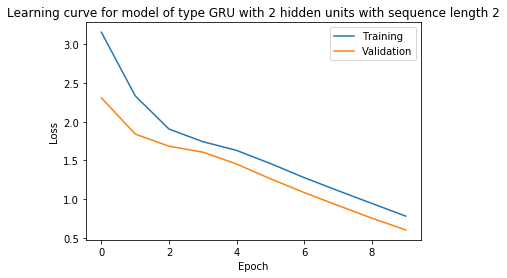

INFO:root:[2020-05-14 16:45:22.285960]: Training model of type GRU with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:45:22.286869]: Epoch: 0
INFO:root:[2020-05-14 16:45:22.287606]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:45:22.392904]: Training loss: 2.808289098739624
INFO:root:[2020-05-14 16:45:22.416507]: Validation loss: 2.1520779132843018
INFO:root:[2020-05-14 16:45:22.417346]: Epoch took: 0.130469 seconds
INFO:root:[2020-05-14 16:45:22.418022]: Epoch: 1
INFO:root:[2020-05-14 16:45:22.418536]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:45:22.474940]: Training loss: 1.760053324699402
INFO:root:[2020-05-14 16:45:22.498136]: Validation loss: 1.4294233322143555
INFO:root:[2020-05-14 16:45:22.498858]: Epoch took: 0.080831 seconds
INFO:root:[2020-05-14 16:45:22.499485]: Epoch: 2
INFO:root:[2020-05-14 16:45:22.499982]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:45:22.559406

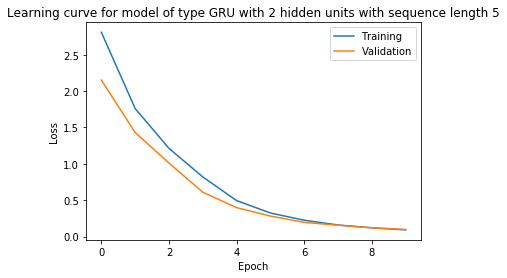

INFO:root:[2020-05-14 16:45:24.011265]: Training model of type GRU with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:45:24.012229]: Epoch: 0
INFO:root:[2020-05-14 16:45:24.012923]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:24.150776]: Training loss: 0.8795936405658722
INFO:root:[2020-05-14 16:45:24.199877]: Validation loss: 0.35677605867385864
INFO:root:[2020-05-14 16:45:24.200494]: Epoch took: 0.188261 seconds
INFO:root:[2020-05-14 16:45:24.201246]: Epoch: 1
INFO:root:[2020-05-14 16:45:24.201784]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:24.340215]: Training loss: 0.45515423715114595
INFO:root:[2020-05-14 16:45:24.389254]: Validation loss: 0.3722495436668396
INFO:root:[2020-05-14 16:45:24.389876]: Epoch took: 0.188626 seconds
INFO:root:[2020-05-14 16:45:24.390608]: Epoch: 2
INFO:root:[2020-05-14 16:45:24.391075]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:2

INFO:root:[2020-05-14 16:45:28.576941]: Training loss: 0.02114013722166419
INFO:root:[2020-05-14 16:45:28.623039]: Validation loss: 0.029236406087875366
INFO:root:[2020-05-14 16:45:28.623587]: Epoch took: 0.181357 seconds
INFO:root:[2020-05-14 16:45:28.624243]: Epoch: 23
INFO:root:[2020-05-14 16:45:28.624715]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:28.756129]: Training loss: 0.04520747996866703
INFO:root:[2020-05-14 16:45:28.802540]: Validation loss: 0.03561853617429733
INFO:root:[2020-05-14 16:45:28.803045]: Epoch took: 0.178799 seconds
INFO:root:[2020-05-14 16:45:28.803426]: Epoch: 24
INFO:root:[2020-05-14 16:45:28.804318]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:28.941551]: Training loss: 0.02377540888264775
INFO:root:[2020-05-14 16:45:28.991018]: Validation loss: 0.013133789412677288
INFO:root:[2020-05-14 16:45:28.991735]: Epoch took: 0.188305 seconds


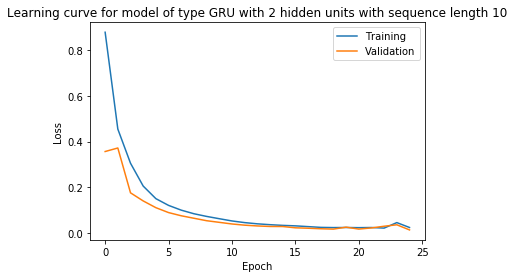

INFO:root:[2020-05-14 16:45:30.506738]: Training model of type GRU with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:45:30.507646]: Epoch: 0
INFO:root:[2020-05-14 16:45:30.508663]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:30.946248]: Training loss: 5.014282482862472
INFO:root:[2020-05-14 16:45:31.061435]: Validation loss: 1.0858888626098633
INFO:root:[2020-05-14 16:45:31.062021]: Epoch took: 0.55437 seconds
INFO:root:[2020-05-14 16:45:31.062895]: Epoch: 1
INFO:root:[2020-05-14 16:45:31.063663]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:31.445511]: Training loss: 0.8890191048383713
INFO:root:[2020-05-14 16:45:31.613361]: Validation loss: 0.4925060272216797
INFO:root:[2020-05-14 16:45:31.614207]: Epoch took: 0.551309 seconds
INFO:root:[2020-05-14 16:45:31.614885]: Epoch: 2
INFO:root:[2020-05-14 16:45:31.615388]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:32

INFO:root:[2020-05-14 16:45:42.598780]: Training loss: 0.019749739160761236
INFO:root:[2020-05-14 16:45:42.706652]: Validation loss: 0.019500654190778732
INFO:root:[2020-05-14 16:45:42.707207]: Epoch took: 0.483741 seconds
INFO:root:[2020-05-14 16:45:42.707867]: Epoch: 23
INFO:root:[2020-05-14 16:45:42.708554]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:43.084753]: Training loss: 0.01879825945943594
INFO:root:[2020-05-14 16:45:43.233188]: Validation loss: 0.01817541942000389
INFO:root:[2020-05-14 16:45:43.233743]: Epoch took: 0.525872 seconds
INFO:root:[2020-05-14 16:45:43.234376]: Epoch: 24
INFO:root:[2020-05-14 16:45:43.234866]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:43.609197]: Training loss: 0.018128209421411155
INFO:root:[2020-05-14 16:45:43.721525]: Validation loss: 0.019820373505353928
INFO:root:[2020-05-14 16:45:43.722048]: Epoch took: 0.48767 seconds
INFO:root:[2020-05-14 16:45:43.722824]: Epoch: 25


INFO:root:[2020-05-14 16:45:53.838553]: Epoch took: 0.483547 seconds
INFO:root:[2020-05-14 16:45:53.839347]: Epoch: 45
INFO:root:[2020-05-14 16:45:53.839977]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:54.255414]: Training loss: 0.010805464419536292
INFO:root:[2020-05-14 16:45:54.368526]: Validation loss: 0.010579767636954784
INFO:root:[2020-05-14 16:45:54.369121]: Epoch took: 0.529771 seconds
INFO:root:[2020-05-14 16:45:54.369863]: Epoch: 46
INFO:root:[2020-05-14 16:45:54.370539]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:54.751367]: Training loss: 0.010738238529302179
INFO:root:[2020-05-14 16:45:54.860560]: Validation loss: 0.01050922367721796
INFO:root:[2020-05-14 16:45:54.861116]: Epoch took: 0.49125 seconds
INFO:root:[2020-05-14 16:45:54.861860]: Epoch: 47
INFO:root:[2020-05-14 16:45:54.862354]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:45:55.287645]: Training loss: 0.0106

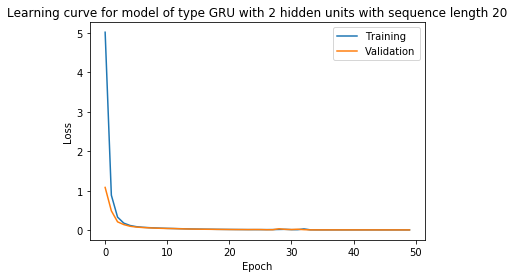

INFO:root:[2020-05-14 16:45:56.612789]: Training model of type LSTM with 2 hidden units
INFO:root:[2020-05-14 16:45:56.613851]: Training model of type LSTM with 2 hidden units with a damping factor of 1
INFO:root:[2020-05-14 16:45:56.765235]: Training model of type LSTM with 2 hidden units with sequence length 2
INFO:root:[2020-05-14 16:45:56.765926]: Epoch: 0
INFO:root:[2020-05-14 16:45:56.766611]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:45:56.787624]: Training loss: 5.298545598983765
INFO:root:[2020-05-14 16:45:56.797596]: Validation loss: 3.6966805458068848
INFO:root:[2020-05-14 16:45:56.798322]: Epoch took: 0.032389 seconds
INFO:root:[2020-05-14 16:45:56.799078]: Epoch: 1
INFO:root:[2020-05-14 16:45:56.799572]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:45:56.820316]: Training loss: 3.6737054586410522
INFO:root:[2020-05-14 16:45:56.830336]: Validation loss: 2.549379825592041
INFO:root:[2020-05-14 16:45:56.831160]: E

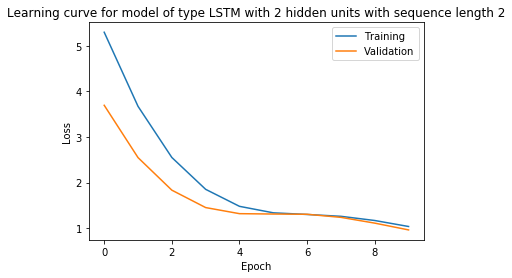

INFO:root:[2020-05-14 16:45:57.571252]: Training model of type LSTM with 2 hidden units with sequence length 5
INFO:root:[2020-05-14 16:45:57.572101]: Epoch: 0
INFO:root:[2020-05-14 16:45:57.572617]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:45:57.684735]: Training loss: 2.683754730224609
INFO:root:[2020-05-14 16:45:57.710053]: Validation loss: 1.9090205430984497
INFO:root:[2020-05-14 16:45:57.710945]: Epoch took: 0.138824 seconds
INFO:root:[2020-05-14 16:45:57.711728]: Epoch: 1
INFO:root:[2020-05-14 16:45:57.712356]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:45:57.775132]: Training loss: 1.6747193336486816
INFO:root:[2020-05-14 16:45:57.799601]: Validation loss: 1.4326342344284058
INFO:root:[2020-05-14 16:45:57.800153]: Epoch took: 0.088424 seconds
INFO:root:[2020-05-14 16:45:57.800869]: Epoch: 2
INFO:root:[2020-05-14 16:45:57.801450]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:45:57.8650

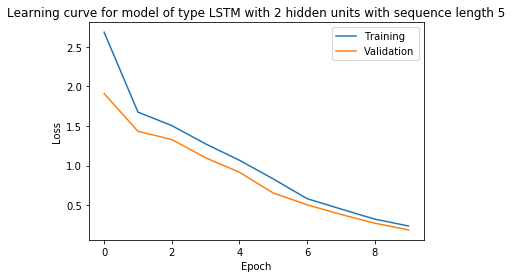

INFO:root:[2020-05-14 16:45:59.332681]: Training model of type LSTM with 2 hidden units with sequence length 10
INFO:root:[2020-05-14 16:45:59.333551]: Epoch: 0
INFO:root:[2020-05-14 16:45:59.334347]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:59.476446]: Training loss: 2.5430053591728212
INFO:root:[2020-05-14 16:45:59.524146]: Validation loss: 2.2370212078094482
INFO:root:[2020-05-14 16:45:59.524993]: Epoch took: 0.191436 seconds
INFO:root:[2020-05-14 16:45:59.525613]: Epoch: 1
INFO:root:[2020-05-14 16:45:59.526406]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:59.669225]: Training loss: 1.7114511132240295
INFO:root:[2020-05-14 16:45:59.717079]: Validation loss: 1.2037588357925415
INFO:root:[2020-05-14 16:45:59.717947]: Epoch took: 0.192328 seconds
INFO:root:[2020-05-14 16:45:59.718626]: Epoch: 2
INFO:root:[2020-05-14 16:45:59.719255]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:45:59

INFO:root:[2020-05-14 16:46:04.126009]: Validation loss: 0.04922640696167946
INFO:root:[2020-05-14 16:46:04.126535]: Epoch took: 0.193588 seconds
INFO:root:[2020-05-14 16:46:04.127259]: Epoch: 23
INFO:root:[2020-05-14 16:46:04.127876]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:46:04.270177]: Training loss: 0.07015910260379314
INFO:root:[2020-05-14 16:46:04.317164]: Validation loss: 0.046544287353754044
INFO:root:[2020-05-14 16:46:04.317728]: Epoch took: 0.190467 seconds
INFO:root:[2020-05-14 16:46:04.318358]: Epoch: 24
INFO:root:[2020-05-14 16:46:04.318950]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:46:04.462500]: Training loss: 0.052580762282013895
INFO:root:[2020-05-14 16:46:04.509589]: Validation loss: 0.05854879692196846
INFO:root:[2020-05-14 16:46:04.510267]: Epoch took: 0.191905 seconds


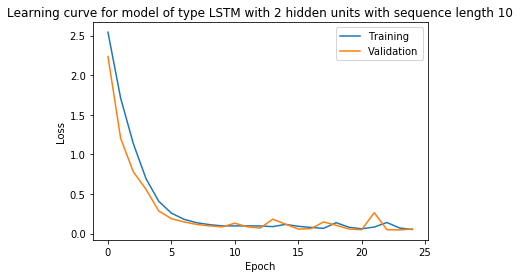

INFO:root:[2020-05-14 16:46:05.960951]: Training model of type LSTM with 2 hidden units with sequence length 20
INFO:root:[2020-05-14 16:46:05.961836]: Epoch: 0
INFO:root:[2020-05-14 16:46:05.962591]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:06.426640]: Training loss: 10.931731271743775
INFO:root:[2020-05-14 16:46:06.541629]: Validation loss: 6.5464043617248535
INFO:root:[2020-05-14 16:46:06.542461]: Epoch took: 0.580621 seconds
INFO:root:[2020-05-14 16:46:06.543043]: Epoch: 1
INFO:root:[2020-05-14 16:46:06.543709]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:06.983550]: Training loss: 4.138027381896973
INFO:root:[2020-05-14 16:46:07.164203]: Validation loss: 2.688095808029175
INFO:root:[2020-05-14 16:46:07.165051]: Epoch took: 0.622004 seconds
INFO:root:[2020-05-14 16:46:07.165660]: Epoch: 2
INFO:root:[2020-05-14 16:46:07.166254]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:0

INFO:root:[2020-05-14 16:46:19.111932]: Training loss: 0.5229413762688637
INFO:root:[2020-05-14 16:46:19.226695]: Validation loss: 0.20766706764698029
INFO:root:[2020-05-14 16:46:19.227233]: Epoch took: 0.54499 seconds
INFO:root:[2020-05-14 16:46:19.227888]: Epoch: 23
INFO:root:[2020-05-14 16:46:19.228561]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:19.646226]: Training loss: 0.2851280800998211
INFO:root:[2020-05-14 16:46:19.802853]: Validation loss: 0.17301306128501892
INFO:root:[2020-05-14 16:46:19.803610]: Epoch took: 0.575718 seconds
INFO:root:[2020-05-14 16:46:19.804196]: Epoch: 24
INFO:root:[2020-05-14 16:46:19.804708]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:20.220221]: Training loss: 0.14574717804789544
INFO:root:[2020-05-14 16:46:20.334460]: Validation loss: 0.11419934034347534
INFO:root:[2020-05-14 16:46:20.335188]: Epoch took: 0.530989 seconds
INFO:root:[2020-05-14 16:46:20.335750]: Epoch: 25
INFO:r

INFO:root:[2020-05-14 16:46:31.540473]: Epoch: 45
INFO:root:[2020-05-14 16:46:31.541216]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:31.956494]: Training loss: 0.10577103719115258
INFO:root:[2020-05-14 16:46:32.110546]: Validation loss: 0.09777270257472992
INFO:root:[2020-05-14 16:46:32.111249]: Epoch took: 0.570771 seconds
INFO:root:[2020-05-14 16:46:32.111917]: Epoch: 46
INFO:root:[2020-05-14 16:46:32.112392]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:32.528733]: Training loss: 0.0918300285935402
INFO:root:[2020-05-14 16:46:32.643444]: Validation loss: 0.08602882921695709
INFO:root:[2020-05-14 16:46:32.643982]: Epoch took: 0.532062 seconds
INFO:root:[2020-05-14 16:46:32.644725]: Epoch: 47
INFO:root:[2020-05-14 16:46:32.645417]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:33.101701]: Training loss: 0.08339564874768257
INFO:root:[2020-05-14 16:46:33.216276]: Validation loss: 0

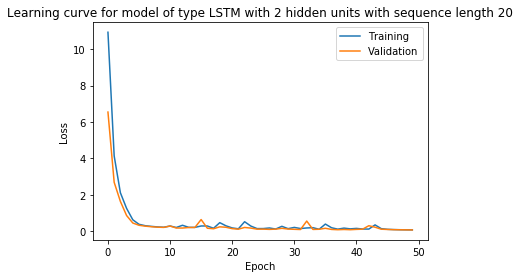

INFO:root:[2020-05-14 16:46:34.490216]: Training model of type Elman with 5 hidden units
INFO:root:[2020-05-14 16:46:34.490896]: Training model of type Elman with 5 hidden units with a damping factor of 1
INFO:root:[2020-05-14 16:46:34.638768]: Training model of type Elman with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:46:34.639536]: Epoch: 0
INFO:root:[2020-05-14 16:46:34.640021]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:46:34.657348]: Training loss: 0.8245901465415955
INFO:root:[2020-05-14 16:46:34.668914]: Validation loss: 0.4283219277858734
INFO:root:[2020-05-14 16:46:34.669679]: Epoch took: 0.030139 seconds
INFO:root:[2020-05-14 16:46:34.670339]: Epoch: 1
INFO:root:[2020-05-14 16:46:34.670828]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:46:34.689239]: Training loss: 0.40053628385066986
INFO:root:[2020-05-14 16:46:34.699822]: Validation loss: 0.4296116828918457
INFO:root:[2020-05-14 16:46:34.7009

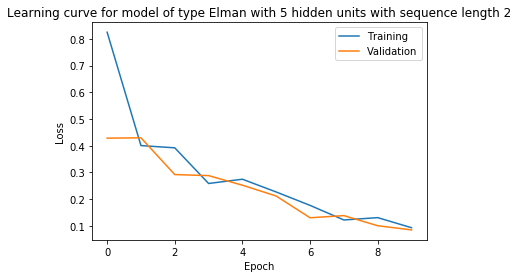

INFO:root:[2020-05-14 16:46:35.452268]: Training model of type Elman with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:46:35.453204]: Epoch: 0
INFO:root:[2020-05-14 16:46:35.453721]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:46:35.501372]: Training loss: 3.570926284790039
INFO:root:[2020-05-14 16:46:35.523443]: Validation loss: 1.627038836479187
INFO:root:[2020-05-14 16:46:35.524249]: Epoch took: 0.071039 seconds
INFO:root:[2020-05-14 16:46:35.524932]: Epoch: 1
INFO:root:[2020-05-14 16:46:35.525595]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:46:35.572001]: Training loss: 1.5885771274566651
INFO:root:[2020-05-14 16:46:35.592997]: Validation loss: 1.5165611505508423
INFO:root:[2020-05-14 16:46:35.593659]: Epoch took: 0.068722 seconds
INFO:root:[2020-05-14 16:46:35.594394]: Epoch: 2
INFO:root:[2020-05-14 16:46:35.595095]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:46:35.6434

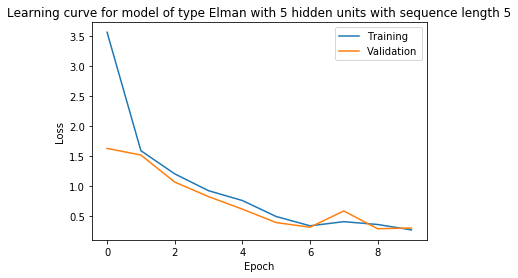

INFO:root:[2020-05-14 16:46:37.047272]: Training model of type Elman with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:46:37.047864]: Epoch: 0
INFO:root:[2020-05-14 16:46:37.048867]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:46:37.146892]: Training loss: 5.001625382900238
INFO:root:[2020-05-14 16:46:37.189388]: Validation loss: 4.6253156661987305
INFO:root:[2020-05-14 16:46:37.190254]: Epoch took: 0.142384 seconds
INFO:root:[2020-05-14 16:46:37.190993]: Epoch: 1
INFO:root:[2020-05-14 16:46:37.191575]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:46:37.287931]: Training loss: 3.3058117151260378
INFO:root:[2020-05-14 16:46:37.381971]: Validation loss: 2.646423816680908
INFO:root:[2020-05-14 16:46:37.382684]: Epoch took: 0.19169 seconds
INFO:root:[2020-05-14 16:46:37.383252]: Epoch: 2
INFO:root:[2020-05-14 16:46:37.383862]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:46:37.4

INFO:root:[2020-05-14 16:46:40.615054]: Validation loss: 0.126407191157341
INFO:root:[2020-05-14 16:46:40.615593]: Epoch took: 0.189148 seconds
INFO:root:[2020-05-14 16:46:40.616442]: Epoch: 23
INFO:root:[2020-05-14 16:46:40.617183]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:46:40.720070]: Training loss: 0.15640832111239433
INFO:root:[2020-05-14 16:46:40.764107]: Validation loss: 0.11185844987630844
INFO:root:[2020-05-14 16:46:40.764725]: Epoch took: 0.148281 seconds
INFO:root:[2020-05-14 16:46:40.765365]: Epoch: 24
INFO:root:[2020-05-14 16:46:40.766053]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:46:40.867368]: Training loss: 0.11528755128383636
INFO:root:[2020-05-14 16:46:40.909362]: Validation loss: 0.2847002446651459
INFO:root:[2020-05-14 16:46:40.909929]: Epoch took: 0.144561 seconds


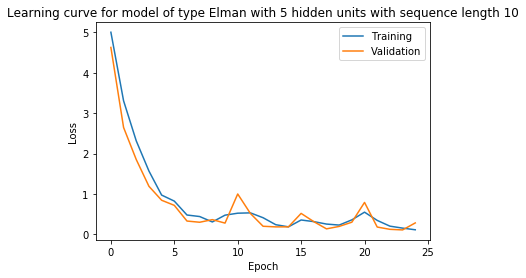

INFO:root:[2020-05-14 16:46:42.472038]: Training model of type Elman with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:46:42.472612]: Epoch: 0
INFO:root:[2020-05-14 16:46:42.473136]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:42.763496]: Training loss: 30.7994446516037
INFO:root:[2020-05-14 16:46:42.852731]: Validation loss: 20.256099700927734
INFO:root:[2020-05-14 16:46:42.853765]: Epoch took: 0.381143 seconds
INFO:root:[2020-05-14 16:46:42.854373]: Epoch: 1
INFO:root:[2020-05-14 16:46:42.854877]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:43.096948]: Training loss: 19.772411823272705
INFO:root:[2020-05-14 16:46:43.189109]: Validation loss: 19.131357192993164
INFO:root:[2020-05-14 16:46:43.189697]: Epoch took: 0.335319 seconds
INFO:root:[2020-05-14 16:46:43.190493]: Epoch: 2
INFO:root:[2020-05-14 16:46:43.190963]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:

INFO:root:[2020-05-14 16:46:50.394095]: Training loss: 19.468192291259765
INFO:root:[2020-05-14 16:46:50.483571]: Validation loss: 19.096294403076172
INFO:root:[2020-05-14 16:46:50.484113]: Epoch took: 0.359874 seconds
INFO:root:[2020-05-14 16:46:50.484862]: Epoch: 23
INFO:root:[2020-05-14 16:46:50.485332]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:50.713565]: Training loss: 19.466792106628418
INFO:root:[2020-05-14 16:46:50.800291]: Validation loss: 19.094633102416992
INFO:root:[2020-05-14 16:46:50.800852]: Epoch took: 0.315984 seconds
INFO:root:[2020-05-14 16:46:50.801578]: Epoch: 24
INFO:root:[2020-05-14 16:46:50.802108]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:51.074334]: Training loss: 19.465025234222413
INFO:root:[2020-05-14 16:46:51.159561]: Validation loss: 19.092971801757812
INFO:root:[2020-05-14 16:46:51.160076]: Epoch took: 0.358496 seconds
Epoch    25: reducing learning rate of group 0 to 1.0000e-0

INFO:root:[2020-05-14 16:46:57.927064]: Validation loss: 19.0916690826416
INFO:root:[2020-05-14 16:46:57.927601]: Epoch took: 0.358512 seconds
INFO:root:[2020-05-14 16:46:57.928342]: Epoch: 45
INFO:root:[2020-05-14 16:46:57.928903]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:58.157837]: Training loss: 19.46123847961426
INFO:root:[2020-05-14 16:46:58.245960]: Validation loss: 19.09166717529297
INFO:root:[2020-05-14 16:46:58.246718]: Epoch took: 0.318373 seconds
INFO:root:[2020-05-14 16:46:58.247362]: Epoch: 46
INFO:root:[2020-05-14 16:46:58.247880]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:46:58.517286]: Training loss: 19.461238193511964
INFO:root:[2020-05-14 16:46:58.602778]: Validation loss: 19.091665267944336
INFO:root:[2020-05-14 16:46:58.603314]: Epoch took: 0.355949 seconds
INFO:root:[2020-05-14 16:46:58.604156]: Epoch: 47
INFO:root:[2020-05-14 16:46:58.604649]: Training on 20 batches and validating on 10 bat

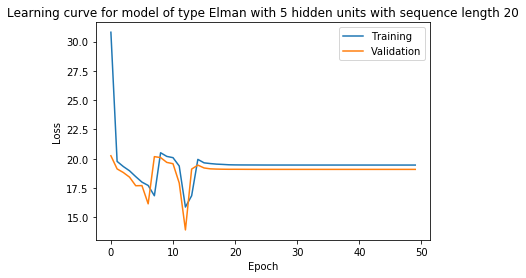

INFO:root:[2020-05-14 16:46:59.707776]: Training model of type GRU with 5 hidden units
INFO:root:[2020-05-14 16:46:59.708806]: Training model of type GRU with 5 hidden units with a damping factor of 1
INFO:root:[2020-05-14 16:46:59.851775]: Training model of type GRU with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:46:59.852652]: Epoch: 0
INFO:root:[2020-05-14 16:46:59.853392]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:46:59.873152]: Training loss: 0.8721456527709961
INFO:root:[2020-05-14 16:46:59.884442]: Validation loss: 0.4280674159526825
INFO:root:[2020-05-14 16:46:59.885232]: Epoch took: 0.032574 seconds
INFO:root:[2020-05-14 16:46:59.885834]: Epoch: 1
INFO:root:[2020-05-14 16:46:59.886431]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:46:59.906222]: Training loss: 0.34629809856414795
INFO:root:[2020-05-14 16:46:59.916763]: Validation loss: 0.24100327491760254
INFO:root:[2020-05-14 16:46:59.917509]: 

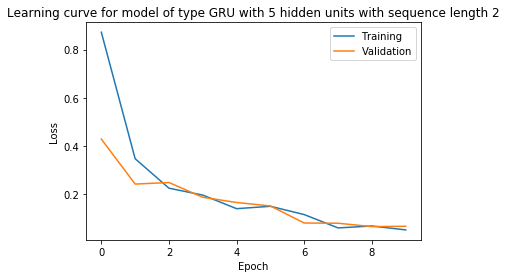

INFO:root:[2020-05-14 16:47:00.658738]: Training model of type GRU with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:47:00.659675]: Epoch: 0
INFO:root:[2020-05-14 16:47:00.660187]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:47:00.718036]: Training loss: 1.0838540196418762
INFO:root:[2020-05-14 16:47:00.740569]: Validation loss: 0.5733468532562256
INFO:root:[2020-05-14 16:47:00.741370]: Epoch took: 0.081688 seconds
INFO:root:[2020-05-14 16:47:00.742026]: Epoch: 1
INFO:root:[2020-05-14 16:47:00.742482]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:47:00.800359]: Training loss: 0.5482703506946563
INFO:root:[2020-05-14 16:47:00.822584]: Validation loss: 0.5045579075813293
INFO:root:[2020-05-14 16:47:00.823368]: Epoch took: 0.081337 seconds
INFO:root:[2020-05-14 16:47:00.823958]: Epoch: 2
INFO:root:[2020-05-14 16:47:00.824642]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:47:00.8821

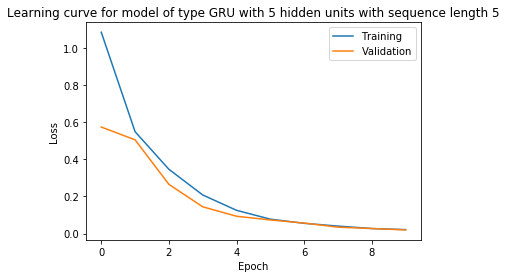

INFO:root:[2020-05-14 16:47:02.409784]: Training model of type GRU with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:47:02.410736]: Epoch: 0
INFO:root:[2020-05-14 16:47:02.411330]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:02.605797]: Training loss: 1.4027191877365113
INFO:root:[2020-05-14 16:47:02.657110]: Validation loss: 0.78066086769104
INFO:root:[2020-05-14 16:47:02.657864]: Epoch took: 0.247123 seconds
INFO:root:[2020-05-14 16:47:02.658444]: Epoch: 1
INFO:root:[2020-05-14 16:47:02.659118]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:02.802300]: Training loss: 0.5812491863965988
INFO:root:[2020-05-14 16:47:02.852585]: Validation loss: 0.3887785077095032
INFO:root:[2020-05-14 16:47:02.853385]: Epoch took: 0.194937 seconds
INFO:root:[2020-05-14 16:47:02.853963]: Epoch: 2
INFO:root:[2020-05-14 16:47:02.854625]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:02.99

INFO:root:[2020-05-14 16:47:07.238879]: Training loss: 0.013423943938687444
INFO:root:[2020-05-14 16:47:07.289676]: Validation loss: 0.012495888397097588
INFO:root:[2020-05-14 16:47:07.290395]: Epoch took: 0.200682 seconds
INFO:root:[2020-05-14 16:47:07.291082]: Epoch: 23
INFO:root:[2020-05-14 16:47:07.291547]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:07.439531]: Training loss: 0.009377539157867432
INFO:root:[2020-05-14 16:47:07.543664]: Validation loss: 0.010250265710055828
INFO:root:[2020-05-14 16:47:07.544459]: Epoch took: 0.253372 seconds
INFO:root:[2020-05-14 16:47:07.545031]: Epoch: 24
INFO:root:[2020-05-14 16:47:07.545491]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:07.699421]: Training loss: 0.0246135538443923
INFO:root:[2020-05-14 16:47:07.752083]: Validation loss: 0.011677246540784836
INFO:root:[2020-05-14 16:47:07.752892]: Epoch took: 0.207853 seconds


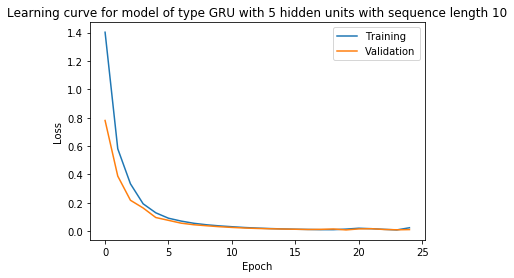

INFO:root:[2020-05-14 16:47:09.343991]: Training model of type GRU with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:47:09.344503]: Epoch: 0
INFO:root:[2020-05-14 16:47:09.345262]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:09.775041]: Training loss: 6.51947375535965
INFO:root:[2020-05-14 16:47:09.896992]: Validation loss: 1.6995846033096313
INFO:root:[2020-05-14 16:47:09.897797]: Epoch took: 0.553289 seconds
INFO:root:[2020-05-14 16:47:09.898531]: Epoch: 1
INFO:root:[2020-05-14 16:47:09.899258]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:10.385736]: Training loss: 1.5686876058578492
INFO:root:[2020-05-14 16:47:10.500502]: Validation loss: 0.9218913316726685
INFO:root:[2020-05-14 16:47:10.501324]: Epoch took: 0.602791 seconds
INFO:root:[2020-05-14 16:47:10.501949]: Epoch: 2
INFO:root:[2020-05-14 16:47:10.502424]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:10

INFO:root:[2020-05-14 16:47:22.327467]: Training loss: 0.047130304481834175
INFO:root:[2020-05-14 16:47:22.455960]: Validation loss: 0.039619360119104385
INFO:root:[2020-05-14 16:47:22.456648]: Epoch took: 0.616836 seconds
INFO:root:[2020-05-14 16:47:22.457198]: Epoch: 23
INFO:root:[2020-05-14 16:47:22.457789]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:22.877418]: Training loss: 0.03364364802837372
INFO:root:[2020-05-14 16:47:23.001826]: Validation loss: 0.02658917009830475
INFO:root:[2020-05-14 16:47:23.002527]: Epoch took: 0.545323 seconds
INFO:root:[2020-05-14 16:47:23.003234]: Epoch: 24
INFO:root:[2020-05-14 16:47:23.003634]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:23.480124]: Training loss: 0.030227554962038994
INFO:root:[2020-05-14 16:47:23.602573]: Validation loss: 0.027206188067793846
INFO:root:[2020-05-14 16:47:23.603095]: Epoch took: 0.599857 seconds
INFO:root:[2020-05-14 16:47:23.603947]: Epoch: 25

INFO:root:[2020-05-14 16:47:34.902314]: Epoch took: 0.593288 seconds
INFO:root:[2020-05-14 16:47:34.902954]: Epoch: 45
INFO:root:[2020-05-14 16:47:34.903660]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:35.320483]: Training loss: 0.011930950684472919
INFO:root:[2020-05-14 16:47:35.434978]: Validation loss: 0.00974254123866558
INFO:root:[2020-05-14 16:47:35.435708]: Epoch took: 0.53275 seconds
INFO:root:[2020-05-14 16:47:35.436431]: Epoch: 46
INFO:root:[2020-05-14 16:47:35.437141]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:35.898312]: Training loss: 0.011817735945805907
INFO:root:[2020-05-14 16:47:36.023932]: Validation loss: 0.009649137035012245
INFO:root:[2020-05-14 16:47:36.024480]: Epoch took: 0.588046 seconds
INFO:root:[2020-05-14 16:47:36.025151]: Epoch: 47
INFO:root:[2020-05-14 16:47:36.025528]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:36.449209]: Training loss: 0.0117

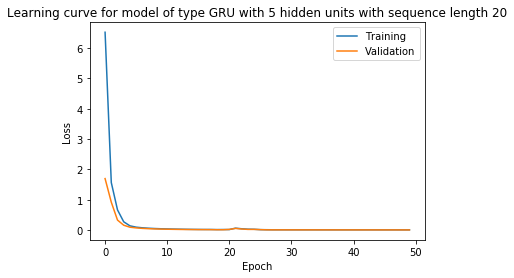

INFO:root:[2020-05-14 16:47:37.822059]: Training model of type LSTM with 5 hidden units
INFO:root:[2020-05-14 16:47:37.822885]: Training model of type LSTM with 5 hidden units with a damping factor of 1
INFO:root:[2020-05-14 16:47:37.971276]: Training model of type LSTM with 5 hidden units with sequence length 2
INFO:root:[2020-05-14 16:47:37.972164]: Epoch: 0
INFO:root:[2020-05-14 16:47:37.972764]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:47:37.994845]: Training loss: 1.8160375356674194
INFO:root:[2020-05-14 16:47:38.004534]: Validation loss: 1.3270012140274048
INFO:root:[2020-05-14 16:47:38.005582]: Epoch took: 0.033406 seconds
INFO:root:[2020-05-14 16:47:38.006995]: Epoch: 1
INFO:root:[2020-05-14 16:47:38.008094]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:47:38.030289]: Training loss: 1.1800161600112915
INFO:root:[2020-05-14 16:47:38.041760]: Validation loss: 0.7588825821876526
INFO:root:[2020-05-14 16:47:38.042644]:

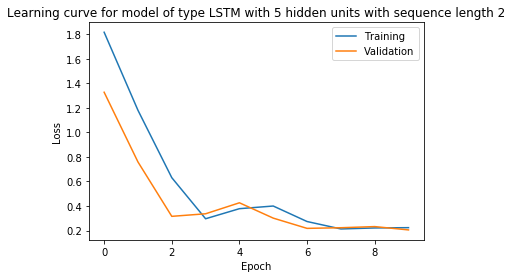

INFO:root:[2020-05-14 16:47:38.853117]: Training model of type LSTM with 5 hidden units with sequence length 5
INFO:root:[2020-05-14 16:47:38.853933]: Epoch: 0
INFO:root:[2020-05-14 16:47:38.854599]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:47:38.918374]: Training loss: 1.3897732377052308
INFO:root:[2020-05-14 16:47:38.942531]: Validation loss: 0.8562392592430115
INFO:root:[2020-05-14 16:47:38.943303]: Epoch took: 0.089364 seconds
INFO:root:[2020-05-14 16:47:38.944210]: Epoch: 1
INFO:root:[2020-05-14 16:47:38.944701]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:47:39.008924]: Training loss: 0.5970775783061981
INFO:root:[2020-05-14 16:47:39.033171]: Validation loss: 0.48891088366508484
INFO:root:[2020-05-14 16:47:39.033934]: Epoch took: 0.08972 seconds
INFO:root:[2020-05-14 16:47:39.034563]: Epoch: 2
INFO:root:[2020-05-14 16:47:39.035280]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:47:39.098

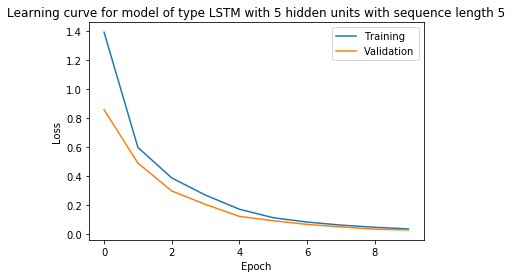

INFO:root:[2020-05-14 16:47:40.646178]: Training model of type LSTM with 5 hidden units with sequence length 10
INFO:root:[2020-05-14 16:47:40.646967]: Epoch: 0
INFO:root:[2020-05-14 16:47:40.647504]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:40.865077]: Training loss: 2.3353065967559816
INFO:root:[2020-05-14 16:47:40.918324]: Validation loss: 0.9062923192977905
INFO:root:[2020-05-14 16:47:40.919243]: Epoch took: 0.272272 seconds
INFO:root:[2020-05-14 16:47:40.919855]: Epoch: 1
INFO:root:[2020-05-14 16:47:40.920495]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:41.093625]: Training loss: 0.9620688766241073
INFO:root:[2020-05-14 16:47:41.147303]: Validation loss: 0.7370136380195618
INFO:root:[2020-05-14 16:47:41.148299]: Epoch took: 0.228437 seconds
INFO:root:[2020-05-14 16:47:41.148920]: Epoch: 2
INFO:root:[2020-05-14 16:47:41.149651]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:41

INFO:root:[2020-05-14 16:47:45.807897]: Training loss: 0.022830307856202124
INFO:root:[2020-05-14 16:47:45.859084]: Validation loss: 0.03166000172495842
INFO:root:[2020-05-14 16:47:45.859983]: Epoch took: 0.214157 seconds
INFO:root:[2020-05-14 16:47:45.860933]: Epoch: 23
INFO:root:[2020-05-14 16:47:45.861511]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:46.023499]: Training loss: 0.021861748397350313
INFO:root:[2020-05-14 16:47:46.073556]: Validation loss: 0.030958611518144608
INFO:root:[2020-05-14 16:47:46.074118]: Epoch took: 0.213184 seconds
INFO:root:[2020-05-14 16:47:46.074830]: Epoch: 24
INFO:root:[2020-05-14 16:47:46.075433]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:47:46.276137]: Training loss: 0.021435857377946378
INFO:root:[2020-05-14 16:47:46.329490]: Validation loss: 0.027135606855154037
INFO:root:[2020-05-14 16:47:46.330141]: Epoch took: 0.255307 seconds


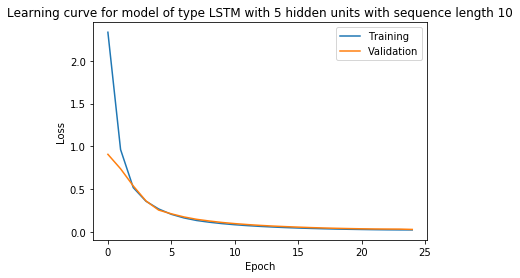

INFO:root:[2020-05-14 16:47:47.882125]: Training model of type LSTM with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 16:47:47.883036]: Epoch: 0
INFO:root:[2020-05-14 16:47:47.883742]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:48.367017]: Training loss: 6.399218708276749
INFO:root:[2020-05-14 16:47:48.500630]: Validation loss: 3.3663036823272705
INFO:root:[2020-05-14 16:47:48.501443]: Epoch took: 0.618403 seconds
INFO:root:[2020-05-14 16:47:48.502300]: Epoch: 1
INFO:root:[2020-05-14 16:47:48.502775]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:49.034108]: Training loss: 2.071921873092651
INFO:root:[2020-05-14 16:47:49.166631]: Validation loss: 1.2879289388656616
INFO:root:[2020-05-14 16:47:49.167407]: Epoch took: 0.665103 seconds
INFO:root:[2020-05-14 16:47:49.168030]: Epoch: 2
INFO:root:[2020-05-14 16:47:49.169004]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:47:4

INFO:root:[2020-05-14 16:48:02.148782]: Training loss: 0.06943707326427102
INFO:root:[2020-05-14 16:48:02.318915]: Validation loss: 0.05110210180282593
INFO:root:[2020-05-14 16:48:02.319699]: Epoch took: 0.635648 seconds
INFO:root:[2020-05-14 16:48:02.320278]: Epoch: 23
INFO:root:[2020-05-14 16:48:02.320886]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:48:02.780071]: Training loss: 0.04291101666167378
INFO:root:[2020-05-14 16:48:02.904000]: Validation loss: 0.0376834012567997
INFO:root:[2020-05-14 16:48:02.904527]: Epoch took: 0.584245 seconds
INFO:root:[2020-05-14 16:48:02.905263]: Epoch: 24
INFO:root:[2020-05-14 16:48:02.905879]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:48:03.373934]: Training loss: 0.034407027252018454
INFO:root:[2020-05-14 16:48:03.541236]: Validation loss: 0.03988040238618851
INFO:root:[2020-05-14 16:48:03.541989]: Epoch took: 0.636724 seconds
Epoch    25: reducing learning rate of group 0 to 1.0

INFO:root:[2020-05-14 16:48:15.778123]: Epoch took: 0.629747 seconds
INFO:root:[2020-05-14 16:48:15.778807]: Epoch: 45
INFO:root:[2020-05-14 16:48:15.779451]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:48:16.244261]: Training loss: 0.02167102009989321
INFO:root:[2020-05-14 16:48:16.364133]: Validation loss: 0.02035718783736229
INFO:root:[2020-05-14 16:48:16.364664]: Epoch took: 0.585854 seconds
INFO:root:[2020-05-14 16:48:16.365467]: Epoch: 46
INFO:root:[2020-05-14 16:48:16.366012]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:48:16.869673]: Training loss: 0.021456433273851872
INFO:root:[2020-05-14 16:48:16.993149]: Validation loss: 0.020146260038018227
INFO:root:[2020-05-14 16:48:16.993846]: Epoch took: 0.628375 seconds
INFO:root:[2020-05-14 16:48:16.994308]: Epoch: 47
INFO:root:[2020-05-14 16:48:16.994744]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:48:17.455702]: Training loss: 0.0212

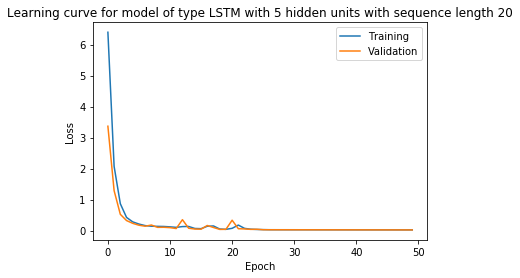

In [18]:
modelTypesNoDamping = [RNNElman(2), GRU(2), LSTM(2), RNNElman(5), GRU(5), LSTM(5)]

for modelType in modelTypesNoDamping:
    writeLog('Training {0}'.format(modelType), logger)
    trainSchedule(modelType, dampingFactor=1)

INFO:root:[2020-05-14 16:48:18.917866]: model of type Elman with 2 hidden units
INFO:root:[2020-05-14 16:48:21.381351]: model of type GRU with 2 hidden units
INFO:root:[2020-05-14 16:48:24.125214]: model of type LSTM with 2 hidden units
INFO:root:[2020-05-14 16:48:27.002158]: model of type Elman with 5 hidden units
INFO:root:[2020-05-14 16:48:29.473007]: model of type GRU with 5 hidden units
INFO:root:[2020-05-14 16:48:32.308946]: model of type LSTM with 5 hidden units


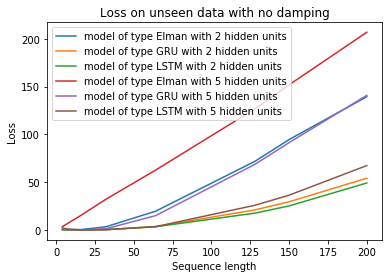

In [19]:
allModelLossesNoDamping = []
for modelType in modelTypesNoDamping:
    writeLog(modelType, logger)
    sequenceLengths = [4,8,16,32,64,128,150,200]
    losses = []
    for sequenceLength in sequenceLengths:
        losses.append(evaluateOnUnseenData(modelType, sequenceLength, dampingFactor=1))
    allModelLossesNoDamping.append(losses)
_, ax = plt.subplots()
ax.plot(sequenceLengths, allModelLossesNoDamping[0], label=str(modelTypesNoDamping[0]))
ax.plot(sequenceLengths, allModelLossesNoDamping[1], label=str(modelTypesNoDamping[1]))
ax.plot(sequenceLengths, allModelLossesNoDamping[2], label=str(modelTypesNoDamping[2]))
ax.plot(sequenceLengths, allModelLossesNoDamping[3], label=str(modelTypesNoDamping[3]))
ax.plot(sequenceLengths, allModelLossesNoDamping[4], label=str(modelTypesNoDamping[4]))
ax.plot(sequenceLengths, allModelLossesNoDamping[5], label=str(modelTypesNoDamping[5]))
ax.set_xlabel('Sequence length')
ax.set_ylabel('Loss')
ax.set_title('Loss on unseen data with no damping')
ax.legend()
plt.show()

In [44]:
for modelType in modelTypesNoDamping:
    writeLog(str(modelType) + ': ' + str(evaluateOnUnseenData(modelType, 1000, dampingFactor=1)), logger)

INFO:root:[2020-05-14 18:51:48.273023]: model of type Elman with 2 hidden units: 906.83095703125
INFO:root:[2020-05-14 18:51:49.705219]: model of type GRU with 2 hidden units: 734.357373046875
INFO:root:[2020-05-14 18:51:51.228882]: model of type LSTM with 2 hidden units: 627.34384765625
INFO:root:[2020-05-14 18:51:52.107665]: model of type Elman with 5 hidden units: 1023.340625
INFO:root:[2020-05-14 18:51:53.669875]: model of type GRU with 5 hidden units: 947.6271484375
INFO:root:[2020-05-14 18:51:55.425317]: model of type LSTM with 5 hidden units: 848.05927734375


As expected, all pretty terrible!

# Varying the hidden size

Let's stick with LSTM and explore the impact of the number of hidden states. We'll use a high damping factor to make the problem difficult, and compare with the results above.

INFO:root:[2020-05-14 16:54:24.912475]: Training model of type LSTM with 1 hidden units
INFO:root:[2020-05-14 16:54:24.913844]: Training model of type LSTM with 1 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:54:25.066363]: Training model of type LSTM with 1 hidden units with sequence length 2
INFO:root:[2020-05-14 16:54:25.067132]: Epoch: 0
INFO:root:[2020-05-14 16:54:25.068065]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:54:25.091174]: Training loss: 2.0512229204177856
INFO:root:[2020-05-14 16:54:25.103596]: Validation loss: 1.7950400114059448
INFO:root:[2020-05-14 16:54:25.105149]: Epoch took: 0.038002 seconds
INFO:root:[2020-05-14 16:54:25.106095]: Epoch: 1
INFO:root:[2020-05-14 16:54:25.106882]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:54:25.132950]: Training loss: 1.773396372795105
INFO:root:[2020-05-14 16:54:25.142166]: Validation loss: 1.522791862487793
INFO:root:[2020-05-14 16:54:25.142998]:

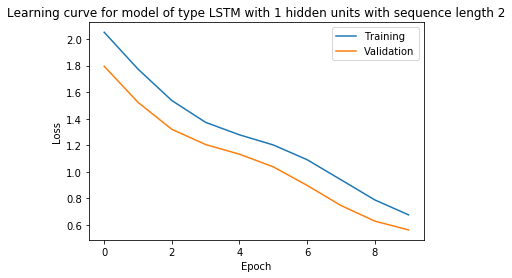

INFO:root:[2020-05-14 16:54:25.936822]: Training model of type LSTM with 1 hidden units with sequence length 5
INFO:root:[2020-05-14 16:54:25.937630]: Epoch: 0
INFO:root:[2020-05-14 16:54:25.938568]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:54:26.001466]: Training loss: 1.2789507150650024
INFO:root:[2020-05-14 16:54:26.024413]: Validation loss: 1.0712497234344482
INFO:root:[2020-05-14 16:54:26.025206]: Epoch took: 0.087573 seconds
INFO:root:[2020-05-14 16:54:26.025759]: Epoch: 1
INFO:root:[2020-05-14 16:54:26.026326]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:54:26.087725]: Training loss: 0.9259239912033081
INFO:root:[2020-05-14 16:54:26.109238]: Validation loss: 0.8220760822296143
INFO:root:[2020-05-14 16:54:26.109991]: Epoch took: 0.084228 seconds
INFO:root:[2020-05-14 16:54:26.110700]: Epoch: 2
INFO:root:[2020-05-14 16:54:26.111163]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:54:26.170

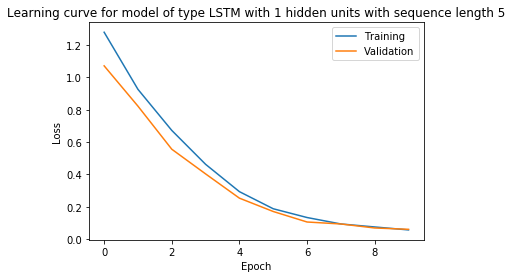

INFO:root:[2020-05-14 16:54:27.786368]: Training model of type LSTM with 1 hidden units with sequence length 10
INFO:root:[2020-05-14 16:54:27.786896]: Epoch: 0
INFO:root:[2020-05-14 16:54:27.787616]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:54:27.930846]: Training loss: 0.9188485980033875
INFO:root:[2020-05-14 16:54:27.977513]: Validation loss: 0.5717625617980957
INFO:root:[2020-05-14 16:54:27.978242]: Epoch took: 0.191341 seconds
INFO:root:[2020-05-14 16:54:27.978679]: Epoch: 1
INFO:root:[2020-05-14 16:54:27.979410]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:54:28.173932]: Training loss: 0.5029954940080643
INFO:root:[2020-05-14 16:54:28.221733]: Validation loss: 0.46854525804519653
INFO:root:[2020-05-14 16:54:28.222522]: Epoch took: 0.243838 seconds
INFO:root:[2020-05-14 16:54:28.223141]: Epoch: 2
INFO:root:[2020-05-14 16:54:28.223576]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:54:2

INFO:root:[2020-05-14 16:54:32.461965]: Training loss: 0.06561262849718333
INFO:root:[2020-05-14 16:54:32.509898]: Validation loss: 0.0832144096493721
INFO:root:[2020-05-14 16:54:32.510743]: Epoch took: 0.191621 seconds
INFO:root:[2020-05-14 16:54:32.511521]: Epoch: 23
INFO:root:[2020-05-14 16:54:32.512008]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:54:32.655368]: Training loss: 0.03469945006072521
INFO:root:[2020-05-14 16:54:32.703351]: Validation loss: 0.022632617503404617
INFO:root:[2020-05-14 16:54:32.703909]: Epoch took: 0.192386 seconds
INFO:root:[2020-05-14 16:54:32.704664]: Epoch: 24
INFO:root:[2020-05-14 16:54:32.705311]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:54:32.846624]: Training loss: 0.021225724183022977
INFO:root:[2020-05-14 16:54:32.891091]: Validation loss: 0.021082453429698944
INFO:root:[2020-05-14 16:54:32.891902]: Epoch took: 0.187233 seconds


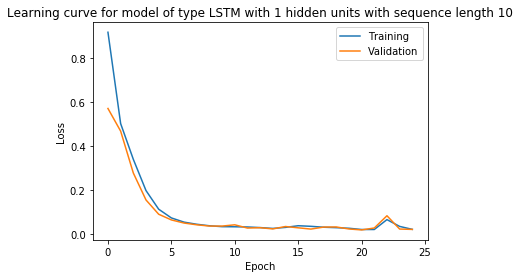

INFO:root:[2020-05-14 16:54:34.514066]: Training model of type LSTM with 1 hidden units with sequence length 20
INFO:root:[2020-05-14 16:54:34.514584]: Epoch: 0
INFO:root:[2020-05-14 16:54:34.515276]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:54:34.966826]: Training loss: 2.0569325126707554
INFO:root:[2020-05-14 16:54:35.077729]: Validation loss: 0.5668490529060364
INFO:root:[2020-05-14 16:54:35.078558]: Epoch took: 0.563968 seconds
INFO:root:[2020-05-14 16:54:35.079244]: Epoch: 1
INFO:root:[2020-05-14 16:54:35.079962]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:54:35.460856]: Training loss: 0.6405684411525726
INFO:root:[2020-05-14 16:54:35.602827]: Validation loss: 0.49352946877479553
INFO:root:[2020-05-14 16:54:35.603532]: Epoch took: 0.524285 seconds
INFO:root:[2020-05-14 16:54:35.604091]: Epoch: 2
INFO:root:[2020-05-14 16:54:35.604703]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:5

INFO:root:[2020-05-14 16:54:46.088516]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:54:46.478598]: Training loss: 0.015046848775818944
INFO:root:[2020-05-14 16:54:46.578165]: Validation loss: 0.013404053635895252
INFO:root:[2020-05-14 16:54:46.578710]: Epoch took: 0.490873 seconds
INFO:root:[2020-05-14 16:54:46.579399]: Epoch: 23
INFO:root:[2020-05-14 16:54:46.580028]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:54:46.953945]: Training loss: 0.014913121797144413
INFO:root:[2020-05-14 16:54:47.092131]: Validation loss: 0.013238678686320782
INFO:root:[2020-05-14 16:54:47.092882]: Epoch took: 0.513478 seconds
INFO:root:[2020-05-14 16:54:47.093551]: Epoch: 24
INFO:root:[2020-05-14 16:54:47.094070]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:54:47.475480]: Training loss: 0.014779453724622726
INFO:root:[2020-05-14 16:54:47.575727]: Validation loss: 0.013092000968754292
INFO:root:[2020-05-14 16

INFO:root:[2020-05-14 16:54:57.945393]: Epoch took: 0.477857 seconds
INFO:root:[2020-05-14 16:54:57.946110]: Epoch: 45
INFO:root:[2020-05-14 16:54:57.946751]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:54:58.319734]: Training loss: 0.012613911088556052
INFO:root:[2020-05-14 16:54:58.460697]: Validation loss: 0.01130259595811367
INFO:root:[2020-05-14 16:54:58.461451]: Epoch took: 0.515337 seconds
INFO:root:[2020-05-14 16:54:58.462173]: Epoch: 46
INFO:root:[2020-05-14 16:54:58.462660]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:54:58.844361]: Training loss: 0.012484939396381378
INFO:root:[2020-05-14 16:54:58.943915]: Validation loss: 0.011067713610827923
INFO:root:[2020-05-14 16:54:58.944516]: Epoch took: 0.482337 seconds
INFO:root:[2020-05-14 16:54:58.945218]: Epoch: 47
INFO:root:[2020-05-14 16:54:58.945733]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:54:59.361724]: Training loss: 0.012

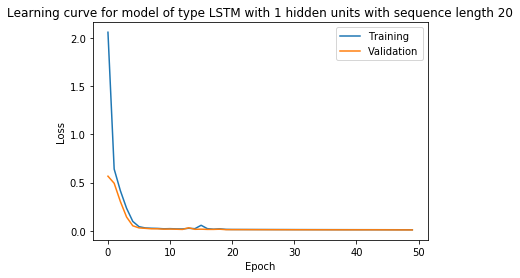

INFO:root:[2020-05-14 16:55:00.562731]: Training model of type LSTM with 10 hidden units
INFO:root:[2020-05-14 16:55:00.563743]: Training model of type LSTM with 10 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:55:00.709779]: Training model of type LSTM with 10 hidden units with sequence length 2
INFO:root:[2020-05-14 16:55:00.710374]: Epoch: 0
INFO:root:[2020-05-14 16:55:00.711376]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:55:00.739133]: Training loss: 2.6224617958068848
INFO:root:[2020-05-14 16:55:00.752252]: Validation loss: 1.1511589288711548
INFO:root:[2020-05-14 16:55:00.753097]: Epoch took: 0.042718 seconds
INFO:root:[2020-05-14 16:55:00.753750]: Epoch: 1
INFO:root:[2020-05-14 16:55:00.754427]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:55:00.782458]: Training loss: 0.9472153782844543
INFO:root:[2020-05-14 16:55:00.794075]: Validation loss: 0.4912566542625427
INFO:root:[2020-05-14 16:55:00.794

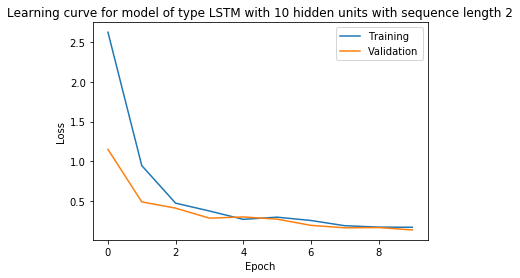

INFO:root:[2020-05-14 16:55:01.648434]: Training model of type LSTM with 10 hidden units with sequence length 5
INFO:root:[2020-05-14 16:55:01.649322]: Epoch: 0
INFO:root:[2020-05-14 16:55:01.650098]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:55:01.736262]: Training loss: 0.46586091816425323
INFO:root:[2020-05-14 16:55:01.766656]: Validation loss: 0.27953627705574036
INFO:root:[2020-05-14 16:55:01.767512]: Epoch took: 0.118185 seconds
INFO:root:[2020-05-14 16:55:01.768227]: Epoch: 1
INFO:root:[2020-05-14 16:55:01.768733]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:55:01.853355]: Training loss: 0.22214843034744264
INFO:root:[2020-05-14 16:55:01.881373]: Validation loss: 0.15473239123821259
INFO:root:[2020-05-14 16:55:01.881971]: Epoch took: 0.113742 seconds
INFO:root:[2020-05-14 16:55:01.882764]: Epoch: 2
INFO:root:[2020-05-14 16:55:01.883303]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:55:0

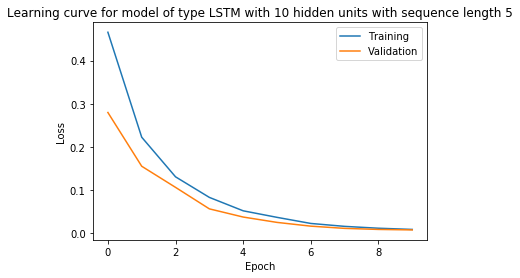

INFO:root:[2020-05-14 16:55:03.781279]: Training model of type LSTM with 10 hidden units with sequence length 10
INFO:root:[2020-05-14 16:55:03.782197]: Epoch: 0
INFO:root:[2020-05-14 16:55:03.782944]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:55:04.032809]: Training loss: 1.2619696021080018
INFO:root:[2020-05-14 16:55:04.100917]: Validation loss: 1.0032106637954712
INFO:root:[2020-05-14 16:55:04.101799]: Epoch took: 0.319595 seconds
INFO:root:[2020-05-14 16:55:04.102464]: Epoch: 1
INFO:root:[2020-05-14 16:55:04.102983]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:55:04.408088]: Training loss: 0.5542687386274338
INFO:root:[2020-05-14 16:55:04.474329]: Validation loss: 0.33201518654823303
INFO:root:[2020-05-14 16:55:04.475083]: Epoch took: 0.372615 seconds
INFO:root:[2020-05-14 16:55:04.475846]: Epoch: 2
INFO:root:[2020-05-14 16:55:04.476350]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:55:

INFO:root:[2020-05-14 16:55:11.133048]: Training loss: 0.004403449851088226
INFO:root:[2020-05-14 16:55:11.196353]: Validation loss: 0.004316896665841341
INFO:root:[2020-05-14 16:55:11.197144]: Epoch took: 0.359081 seconds
INFO:root:[2020-05-14 16:55:11.197840]: Epoch: 23
INFO:root:[2020-05-14 16:55:11.198528]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:55:11.441230]: Training loss: 0.004014758393168449
INFO:root:[2020-05-14 16:55:11.503855]: Validation loss: 0.0036215619184076786
INFO:root:[2020-05-14 16:55:11.504609]: Epoch took: 0.306765 seconds
INFO:root:[2020-05-14 16:55:11.505309]: Epoch: 24
INFO:root:[2020-05-14 16:55:11.505876]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:55:11.753334]: Training loss: 0.003571923589333892
INFO:root:[2020-05-14 16:55:11.816554]: Validation loss: 0.003145345253869891
INFO:root:[2020-05-14 16:55:11.817430]: Epoch took: 0.312114 seconds


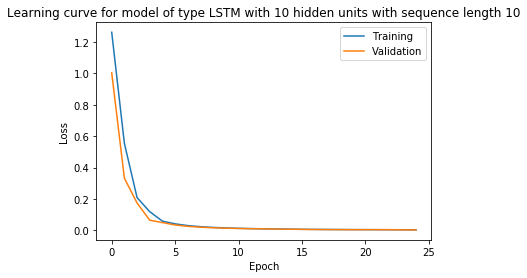

INFO:root:[2020-05-14 16:55:13.437284]: Training model of type LSTM with 10 hidden units with sequence length 20
INFO:root:[2020-05-14 16:55:13.438206]: Epoch: 0
INFO:root:[2020-05-14 16:55:13.438902]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:55:14.308236]: Training loss: 1.673399879038334
INFO:root:[2020-05-14 16:55:14.480512]: Validation loss: 0.642075777053833
INFO:root:[2020-05-14 16:55:14.481549]: Epoch took: 1.043334 seconds
INFO:root:[2020-05-14 16:55:14.482394]: Epoch: 1
INFO:root:[2020-05-14 16:55:14.483316]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:55:15.283775]: Training loss: 0.42826494872570037
INFO:root:[2020-05-14 16:55:15.456101]: Validation loss: 0.21559593081474304
INFO:root:[2020-05-14 16:55:15.457084]: Epoch took: 0.974685 seconds
INFO:root:[2020-05-14 16:55:15.457801]: Epoch: 2
INFO:root:[2020-05-14 16:55:15.458306]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:5

INFO:root:[2020-05-14 16:55:36.613647]: Training loss: 0.0046375197940506045
INFO:root:[2020-05-14 16:55:36.782413]: Validation loss: 0.005963445175439119
INFO:root:[2020-05-14 16:55:36.783206]: Epoch took: 1.01688 seconds
Epoch    23: reducing learning rate of group 0 to 1.0000e-02.
INFO:root:[2020-05-14 16:55:36.784108]: Epoch: 23
INFO:root:[2020-05-14 16:55:36.784634]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:55:37.580131]: Training loss: 0.0038245877367444336
INFO:root:[2020-05-14 16:55:37.743209]: Validation loss: 0.0031891600228846073
INFO:root:[2020-05-14 16:55:37.744079]: Epoch took: 0.959968 seconds
INFO:root:[2020-05-14 16:55:37.744678]: Epoch: 24
INFO:root:[2020-05-14 16:55:37.745432]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:55:38.592947]: Training loss: 0.0031129132723435758
INFO:root:[2020-05-14 16:55:38.760087]: Validation loss: 0.0027823150157928467
INFO:root:[2020-05-14 16:55:38.760869]: Epoch took

INFO:root:[2020-05-14 16:55:59.393793]: Validation loss: 0.002236687345430255
INFO:root:[2020-05-14 16:55:59.394365]: Epoch took: 1.060563 seconds
INFO:root:[2020-05-14 16:55:59.395117]: Epoch: 45
INFO:root:[2020-05-14 16:55:59.395610]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:56:00.226734]: Training loss: 0.0024522915831767023
INFO:root:[2020-05-14 16:56:00.405761]: Validation loss: 0.002214929088950157
INFO:root:[2020-05-14 16:56:00.406411]: Epoch took: 1.011289 seconds
INFO:root:[2020-05-14 16:56:00.407414]: Epoch: 46
INFO:root:[2020-05-14 16:56:00.408057]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:56:01.253531]: Training loss: 0.0024287897045724093
INFO:root:[2020-05-14 16:56:01.431224]: Validation loss: 0.0021932744421064854
INFO:root:[2020-05-14 16:56:01.432075]: Epoch took: 1.024658 seconds
INFO:root:[2020-05-14 16:56:01.432696]: Epoch: 47
INFO:root:[2020-05-14 16:56:01.433167]: Training on 20 batches and val

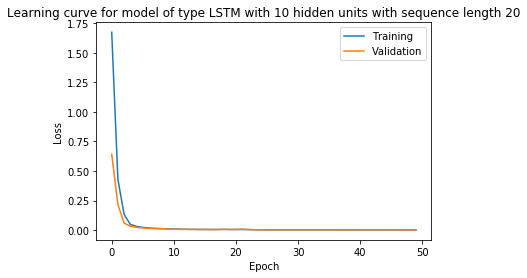

INFO:root:[2020-05-14 16:56:04.563690]: Training model of type LSTM with 20 hidden units
INFO:root:[2020-05-14 16:56:04.564469]: Training model of type LSTM with 20 hidden units with a damping factor of 0.9
INFO:root:[2020-05-14 16:56:04.715009]: Training model of type LSTM with 20 hidden units with sequence length 2
INFO:root:[2020-05-14 16:56:04.715777]: Epoch: 0
INFO:root:[2020-05-14 16:56:04.716286]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:56:04.745843]: Training loss: 3.612347722053528
INFO:root:[2020-05-14 16:56:04.758718]: Validation loss: 0.8765955567359924
INFO:root:[2020-05-14 16:56:04.759494]: Epoch took: 0.043713 seconds
INFO:root:[2020-05-14 16:56:04.760211]: Epoch: 1
INFO:root:[2020-05-14 16:56:04.760995]: Training on 2 batches and validating on 1 batches
INFO:root:[2020-05-14 16:56:04.790849]: Training loss: 0.7650561332702637
INFO:root:[2020-05-14 16:56:04.801054]: Validation loss: 0.5396390557289124
INFO:root:[2020-05-14 16:56:04.8021

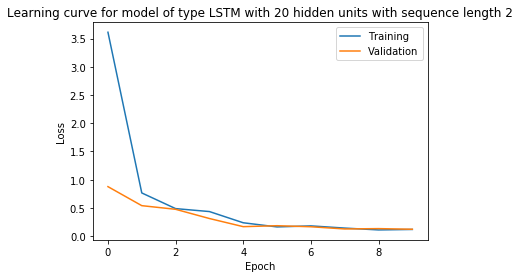

INFO:root:[2020-05-14 16:56:05.722645]: Training model of type LSTM with 20 hidden units with sequence length 5
INFO:root:[2020-05-14 16:56:05.723231]: Epoch: 0
INFO:root:[2020-05-14 16:56:05.723941]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:56:05.822950]: Training loss: 1.1020424246788025
INFO:root:[2020-05-14 16:56:05.854888]: Validation loss: 0.7549700736999512
INFO:root:[2020-05-14 16:56:05.855779]: Epoch took: 0.132543 seconds
INFO:root:[2020-05-14 16:56:05.856483]: Epoch: 1
INFO:root:[2020-05-14 16:56:05.857298]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:56:05.957601]: Training loss: 0.5122976839542389
INFO:root:[2020-05-14 16:56:05.989736]: Validation loss: 0.4303065240383148
INFO:root:[2020-05-14 16:56:05.990430]: Epoch took: 0.133951 seconds
INFO:root:[2020-05-14 16:56:05.991264]: Epoch: 2
INFO:root:[2020-05-14 16:56:05.991959]: Training on 5 batches and validating on 3 batches
INFO:root:[2020-05-14 16:56:06.09

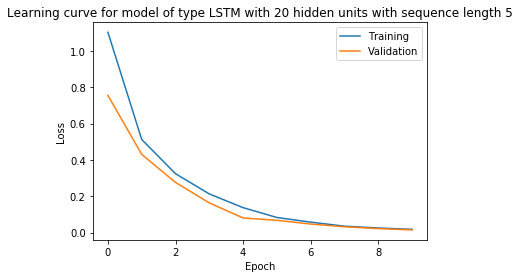

INFO:root:[2020-05-14 16:56:08.073017]: Training model of type LSTM with 20 hidden units with sequence length 10
INFO:root:[2020-05-14 16:56:08.073545]: Epoch: 0
INFO:root:[2020-05-14 16:56:08.074235]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:56:08.451519]: Training loss: 0.8334131002426147
INFO:root:[2020-05-14 16:56:08.525160]: Validation loss: 0.4229036867618561
INFO:root:[2020-05-14 16:56:08.526012]: Epoch took: 0.452462 seconds
INFO:root:[2020-05-14 16:56:08.526720]: Epoch: 1
INFO:root:[2020-05-14 16:56:08.527490]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:56:08.860228]: Training loss: 0.3561694249510765
INFO:root:[2020-05-14 16:56:08.941219]: Validation loss: 0.19606374204158783
INFO:root:[2020-05-14 16:56:08.942170]: Epoch took: 0.415446 seconds
INFO:root:[2020-05-14 16:56:08.942872]: Epoch: 2
INFO:root:[2020-05-14 16:56:08.943361]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:56:

INFO:root:[2020-05-14 16:56:17.527962]: Training loss: 0.003619878552854061
INFO:root:[2020-05-14 16:56:17.606943]: Validation loss: 0.0040571196004748344
INFO:root:[2020-05-14 16:56:17.607775]: Epoch took: 0.395519 seconds
INFO:root:[2020-05-14 16:56:17.608506]: Epoch: 23
INFO:root:[2020-05-14 16:56:17.609075]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:56:17.925688]: Training loss: 0.003470286447554827
INFO:root:[2020-05-14 16:56:18.002106]: Validation loss: 0.003976090811192989
INFO:root:[2020-05-14 16:56:18.002942]: Epoch took: 0.394432 seconds
INFO:root:[2020-05-14 16:56:18.003663]: Epoch: 24
INFO:root:[2020-05-14 16:56:18.004216]: Training on 10 batches and validating on 5 batches
INFO:root:[2020-05-14 16:56:18.365718]: Training loss: 0.003294046875089407
INFO:root:[2020-05-14 16:56:18.435537]: Validation loss: 0.0037475924473255873
INFO:root:[2020-05-14 16:56:18.436309]: Epoch took: 0.432654 seconds


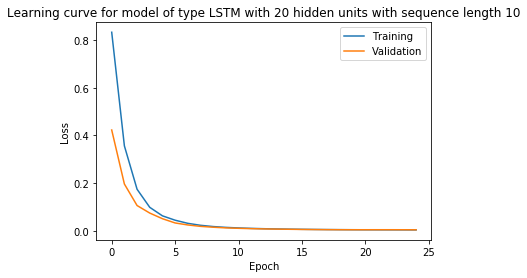

INFO:root:[2020-05-14 16:56:20.001842]: Training model of type LSTM with 20 hidden units with sequence length 20
INFO:root:[2020-05-14 16:56:20.002733]: Epoch: 0
INFO:root:[2020-05-14 16:56:20.003448]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:56:21.058015]: Training loss: 2.4946324177086354
INFO:root:[2020-05-14 16:56:21.266819]: Validation loss: 1.321079969406128
INFO:root:[2020-05-14 16:56:21.267680]: Epoch took: 1.264942 seconds
INFO:root:[2020-05-14 16:56:21.268278]: Epoch: 1
INFO:root:[2020-05-14 16:56:21.268941]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:56:22.369854]: Training loss: 0.6640862599015236
INFO:root:[2020-05-14 16:56:22.570357]: Validation loss: 0.1745602786540985
INFO:root:[2020-05-14 16:56:22.571115]: Epoch took: 1.30283 seconds
INFO:root:[2020-05-14 16:56:22.572029]: Epoch: 2
INFO:root:[2020-05-14 16:56:22.572599]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:56:

INFO:root:[2020-05-14 16:56:49.565380]: Training loss: 0.0027779302967246623
INFO:root:[2020-05-14 16:56:49.775378]: Validation loss: 0.0020949000027030706
INFO:root:[2020-05-14 16:56:49.775946]: Epoch took: 1.331511 seconds
INFO:root:[2020-05-14 16:56:49.776531]: Epoch: 23
INFO:root:[2020-05-14 16:56:49.777330]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:56:50.940857]: Training loss: 0.0025686057982966305
INFO:root:[2020-05-14 16:56:51.146455]: Validation loss: 0.0019933718722313643
INFO:root:[2020-05-14 16:56:51.147240]: Epoch took: 1.370704 seconds
INFO:root:[2020-05-14 16:56:51.147897]: Epoch: 24
INFO:root:[2020-05-14 16:56:51.148562]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:56:52.339536]: Training loss: 0.002757992403348908
INFO:root:[2020-05-14 16:56:52.563437]: Validation loss: 0.0025881826877593994
INFO:root:[2020-05-14 16:56:52.564334]: Epoch took: 1.416433 seconds
INFO:root:[2020-05-14 16:56:52.564908]: Ep

INFO:root:[2020-05-14 16:57:18.285984]: Epoch took: 1.318072 seconds
INFO:root:[2020-05-14 16:57:18.286804]: Epoch: 45
INFO:root:[2020-05-14 16:57:18.287316]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:57:19.341033]: Training loss: 0.0011526035435963423
INFO:root:[2020-05-14 16:57:19.537251]: Validation loss: 0.0011187087511643767
INFO:root:[2020-05-14 16:57:19.538014]: Epoch took: 1.251206 seconds
INFO:root:[2020-05-14 16:57:19.538613]: Epoch: 46
INFO:root:[2020-05-14 16:57:19.539114]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:57:20.572762]: Training loss: 0.0011439448047894985
INFO:root:[2020-05-14 16:57:20.811785]: Validation loss: 0.0011105772573500872
INFO:root:[2020-05-14 16:57:20.812551]: Epoch took: 1.273918 seconds
INFO:root:[2020-05-14 16:57:20.813189]: Epoch: 47
INFO:root:[2020-05-14 16:57:20.813721]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 16:57:21.848524]: Training loss: 

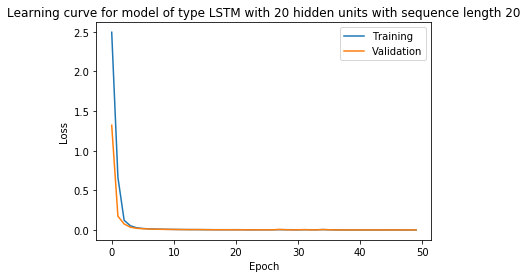

In [21]:
differentSizeLSTMS = [LSTM(1), LSTM(10), LSTM(20)]

for modelType in differentSizeLSTMS:
    writeLog('Training {0}'.format(modelType), logger)
    trainSchedule(modelType, dampingFactor=0.9)

INFO:root:[2020-05-14 16:57:31.862368]: model of type LSTM with 1 hidden units
INFO:root:[2020-05-14 16:57:34.842861]: model of type LSTM with 10 hidden units
INFO:root:[2020-05-14 16:57:38.564227]: model of type LSTM with 20 hidden units
INFO:root:[2020-05-14 16:57:42.724980]: model of type LSTM with 2 hidden units
INFO:root:[2020-05-14 16:57:46.052778]: model of type LSTM with 5 hidden units


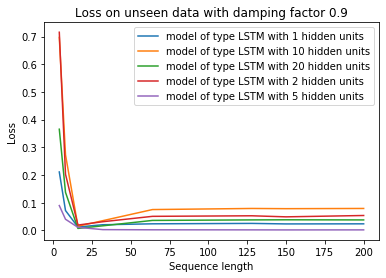

In [22]:
allModelLossesLSTMS = []
allTrainedLSTMS = differentSizeLSTMS + [modelTypesHigherDamping[2], modelTypesHigherDamping[5]]
for modelType in allTrainedLSTMS:
    writeLog(modelType, logger)
    sequenceLengths = [4,8,16,32,64,128,150,200]
    losses = []
    for sequenceLength in sequenceLengths:
        losses.append(evaluateOnUnseenData(modelType, sequenceLength, dampingFactor=0.9))
    allModelLossesLSTMS.append(losses)
_, ax = plt.subplots()
ax.plot(sequenceLengths, allModelLossesLSTMS[0], label=str(allTrainedLSTMS[0]))
ax.plot(sequenceLengths, allModelLossesLSTMS[1], label=str(allTrainedLSTMS[1]))
ax.plot(sequenceLengths, allModelLossesLSTMS[2], label=str(allTrainedLSTMS[2]))
ax.plot(sequenceLengths, allModelLossesLSTMS[3], label=str(allTrainedLSTMS[3]))
ax.plot(sequenceLengths, allModelLossesLSTMS[4], label=str(allTrainedLSTMS[4]))
ax.set_xlabel('Sequence length')
ax.set_ylabel('Loss')
ax.set_title('Loss on unseen data with damping factor 0.9')
ax.legend()
plt.show()

In [45]:
for modelType in allTrainedLSTMS:
    writeLog(str(modelType) + ': ' + str(evaluateOnUnseenData(modelType, 1000, dampingFactor=0.9)), logger)

INFO:root:[2020-05-14 18:52:14.029151]: model of type LSTM with 1 hidden units: 0.023688660562038423
INFO:root:[2020-05-14 18:52:16.406262]: model of type LSTM with 10 hidden units: 0.07763538360595704
INFO:root:[2020-05-14 18:52:19.334449]: model of type LSTM with 20 hidden units: 0.03855786919593811
INFO:root:[2020-05-14 18:52:20.949512]: model of type LSTM with 2 hidden units: 0.05120757818222046
INFO:root:[2020-05-14 18:52:22.763936]: model of type LSTM with 5 hidden units: 0.002047191932797432


These came out in a funny order. Anyway, it looks like 5 is about the sweet spot (though all did pretty well!).

Let's look at the full learning curve (across warm start boundaries) for the biggest LSTM.

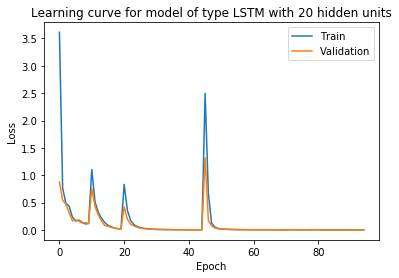

In [25]:
_, ax = plt.subplots()
ax.plot(range(len(allTrainedLSTMS[2].trainLosses)), allTrainedLSTMS[2].trainLosses, label='Train')
ax.plot(range(len(allTrainedLSTMS[2].validLosses)), allTrainedLSTMS[2].validLosses, label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Learning curve for {0}'.format(allTrainedLSTMS[2]))
ax.legend()
plt.show()

Compare with the best performing model.

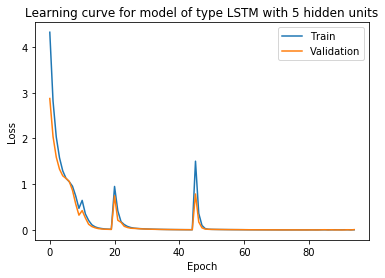

In [26]:
_, ax = plt.subplots()
ax.plot(range(len(allTrainedLSTMS[4].trainLosses)), allTrainedLSTMS[4].trainLosses, label='Train')
ax.plot(range(len(allTrainedLSTMS[4].validLosses)), allTrainedLSTMS[4].validLosses, label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Learning curve for {0}'.format(allTrainedLSTMS[4]))
ax.legend()
plt.show()

Let's explore whether the warm restart is helping.

INFO:root:[2020-05-14 18:12:28.021801]: Training model of type LSTM with 5 hidden units with sequence length 20
INFO:root:[2020-05-14 18:12:28.022743]: Epoch: 0
INFO:root:[2020-05-14 18:12:28.023600]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:12:28.537785]: Training loss: 1.9367031663656236
INFO:root:[2020-05-14 18:12:28.664601]: Validation loss: 0.711440920829773
INFO:root:[2020-05-14 18:12:28.665447]: Epoch took: 0.642696 seconds
INFO:root:[2020-05-14 18:12:28.666118]: Epoch: 1
INFO:root:[2020-05-14 18:12:28.666875]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:12:29.136721]: Training loss: 0.46765982508659365
INFO:root:[2020-05-14 18:12:29.263497]: Validation loss: 0.268804132938385
INFO:root:[2020-05-14 18:12:29.264276]: Epoch took: 0.598156 seconds
INFO:root:[2020-05-14 18:12:29.264886]: Epoch: 2
INFO:root:[2020-05-14 18:12:29.265383]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:12:

INFO:root:[2020-05-14 18:12:42.322350]: Training loss: 0.009552540211006998
INFO:root:[2020-05-14 18:12:42.450557]: Validation loss: 0.007036170922219753
INFO:root:[2020-05-14 18:12:42.451266]: Epoch took: 0.644698 seconds
INFO:root:[2020-05-14 18:12:42.451953]: Epoch: 23
INFO:root:[2020-05-14 18:12:42.452410]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:12:42.913419]: Training loss: 0.02115821319166571
INFO:root:[2020-05-14 18:12:43.036436]: Validation loss: 0.022318068891763687
INFO:root:[2020-05-14 18:12:43.036995]: Epoch took: 0.585036 seconds
INFO:root:[2020-05-14 18:12:43.037788]: Epoch: 24
INFO:root:[2020-05-14 18:12:43.038336]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:12:43.539511]: Training loss: 0.012710903096012771
INFO:root:[2020-05-14 18:12:43.661651]: Validation loss: 0.006840761750936508
INFO:root:[2020-05-14 18:12:43.662182]: Epoch took: 0.624391 seconds
INFO:root:[2020-05-14 18:12:43.662963]: Epoch: 2

INFO:root:[2020-05-14 18:12:55.813155]: Epoch took: 0.627136 seconds
INFO:root:[2020-05-14 18:12:55.813791]: Epoch: 45
INFO:root:[2020-05-14 18:12:55.814421]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:12:56.276508]: Training loss: 0.004807310539763421
INFO:root:[2020-05-14 18:12:56.398654]: Validation loss: 0.005041609052568674
INFO:root:[2020-05-14 18:12:56.399363]: Epoch took: 0.58557 seconds
INFO:root:[2020-05-14 18:12:56.399984]: Epoch: 46
INFO:root:[2020-05-14 18:12:56.400640]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:12:56.903007]: Training loss: 0.004742681328207254
INFO:root:[2020-05-14 18:12:57.028197]: Validation loss: 0.004975964315235615
INFO:root:[2020-05-14 18:12:57.028761]: Epoch took: 0.628773 seconds
INFO:root:[2020-05-14 18:12:57.029518]: Epoch: 47
INFO:root:[2020-05-14 18:12:57.030015]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:12:57.492939]: Training loss: 0.004

INFO:root:[2020-05-14 18:13:09.955454]: Training loss: 0.0035817061900161205
INFO:root:[2020-05-14 18:13:10.080122]: Validation loss: 0.003784287255257368
INFO:root:[2020-05-14 18:13:10.081013]: Epoch took: 0.602318 seconds
INFO:root:[2020-05-14 18:13:10.081585]: Epoch: 68
INFO:root:[2020-05-14 18:13:10.082058]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:13:10.549438]: Training loss: 0.003535042819567025
INFO:root:[2020-05-14 18:13:10.719424]: Validation loss: 0.0037356880493462086
INFO:root:[2020-05-14 18:13:10.720176]: Epoch took: 0.638587 seconds
INFO:root:[2020-05-14 18:13:10.720728]: Epoch: 69
INFO:root:[2020-05-14 18:13:10.721376]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:13:11.193321]: Training loss: 0.0034891101997345684
INFO:root:[2020-05-14 18:13:11.318030]: Validation loss: 0.0036877982784062624
INFO:root:[2020-05-14 18:13:11.318550]: Epoch took: 0.597819 seconds
INFO:root:[2020-05-14 18:13:11.319247]: Epo

INFO:root:[2020-05-14 18:13:23.779290]: Epoch took: 0.600841 seconds
INFO:root:[2020-05-14 18:13:23.779797]: Epoch: 90
INFO:root:[2020-05-14 18:13:23.780356]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:13:24.247133]: Training loss: 0.0026624967576935887
INFO:root:[2020-05-14 18:13:24.412036]: Validation loss: 0.002870887517929077
INFO:root:[2020-05-14 18:13:24.412764]: Epoch took: 0.632961 seconds
INFO:root:[2020-05-14 18:13:24.413376]: Epoch: 91
INFO:root:[2020-05-14 18:13:24.413843]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:13:24.886925]: Training loss: 0.0026279598940163853
INFO:root:[2020-05-14 18:13:25.012165]: Validation loss: 0.0028371368534862995
INFO:root:[2020-05-14 18:13:25.012710]: Epoch took: 0.599332 seconds
INFO:root:[2020-05-14 18:13:25.013452]: Epoch: 92
INFO:root:[2020-05-14 18:13:25.013988]: Training on 20 batches and validating on 10 batches
INFO:root:[2020-05-14 18:13:25.520537]: Training loss: 0

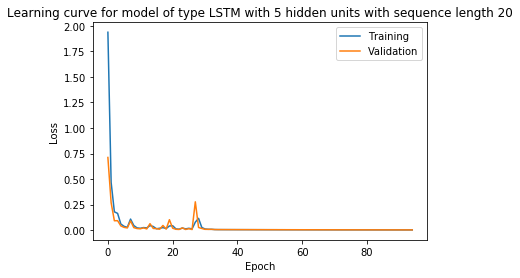

In [33]:
noWarmStartModel = LSTM(5)
train(noWarmStartModel, 20, 95, 0.9)

INFO:root:[2020-05-14 18:13:26.990739]: model of type LSTM with 5 hidden units
INFO:root:[2020-05-14 18:13:30.073900]: model of type LSTM with 5 hidden units


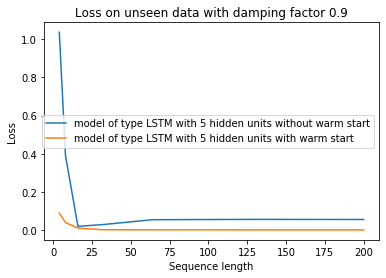

In [34]:
myLSTMS = [noWarmStartModel, allTrainedLSTMS[4]]
allModelLossesLSTMSRestartComparison = []
for modelType in myLSTMS:
    writeLog(modelType, logger)
    sequenceLengths = [4,8,16,32,64,128,150,200]
    losses = []
    for sequenceLength in sequenceLengths:
        losses.append(evaluateOnUnseenData(modelType, sequenceLength, dampingFactor=0.9))
    allModelLossesLSTMSRestartComparison.append(losses)
_, ax = plt.subplots()
ax.plot(sequenceLengths, allModelLossesLSTMSRestartComparison[0], label=str(myLSTMS[0]) + ' without warm start')
ax.plot(sequenceLengths, allModelLossesLSTMSRestartComparison[1], label=str(myLSTMS[1]) + ' with warm start')
ax.set_xlabel('Sequence length')
ax.set_ylabel('Loss')
ax.set_title('Loss on unseen data with damping factor 0.9')
ax.legend()
plt.show()

In [46]:
for modelType in myLSTMS:
    writeLog(str(modelType) + ': ' + str(evaluateOnUnseenData(modelType, 1000, dampingFactor=0.9)), logger)

INFO:root:[2020-05-14 18:52:58.312204]: model of type LSTM with 5 hidden units: 0.057733213901519774
INFO:root:[2020-05-14 18:53:00.213238]: model of type LSTM with 5 hidden units: 0.002144225873053074


So looks like the warm starting did help a fair bit, especially for shorter sequences (which makes sense!).